In [1]:
# !pip install camelot-py[cv]
# !pip install PyPDF2==2.12.1

# PDF Table Extraction and Other Data Acquisition for Pantawid Pamilyang Pilipino Program (PPPP) Analysis

In [1]:
import os
import time
import pickle
import re
import copy

from IPython.display import clear_output

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import camelot

import rasterio
import geopandas as gpd
import numpy as np
from rasterio.mask import mask
from shapely.ops import unary_union

import warnings
warnings.filterwarnings("ignore")

## Overview

Social science research often requires data extraction from unstructured sources, one of the most common being tables embedded in PDFs. Extracting these tables presents inherent challenges due to inconsistent formatting, varying table structures, and unstandardized layouts across documents. In such scenarios, having strong skills in Python and open-source tools like Pandas and Camelot is essential for effectively transforming unstructured data into usable formats. This project showcases the importance of these skills by using the Pantawid Pamilyang Pilipino Program (PPPP) reports as a case study, demonstrating how customized approaches can be applied to extract and organize quarterly data from complex PDFs. The PPPP is a conditional cash transfer (CCT) program in the Philippines aimed at reducing poverty and promoting human capital development. It provides financial assistance to low-income families, especially those with children, to help improve their health, nutrition, and education.

In this notebook, we perform both geospatial and temporal visualizations of the extracted quarterly number of households benefitting from the PPPP. The analysis performed included consideration of population density and poverty incidence for context.

## Data

1. __PPPP tables__ - The PPPP reports, from which tabular data will be extracted, can be downloaded [here](https://pantawid.dswd.gov.ph/programimplementationreport/), and are assumed to be placed in `data/PPPP/`. The reports are named by their year and quarter, e.g. `2020_Q1.pdf` for the first quarter of 2020. We focus on extracting the tables detailing number of household benefitting from the program from each geographical location in the appendix, spanning 50 to 70 pages for each report. A detailed walkthrough of the approach undertaken is given for the [2020 Q1 report](#2020_Q1), followed by custom treatment for each of the other time periods considered.

2. __Population density__ - Population density is extracted from the High Resolution Settlement Layer (HRSL) which can be downloaded [here](https://data.humdata.org/dataset/philippines-high-resolution-population-density-maps-demographic-estimates), and is assumed to be placed in `data/hrsl/`.
   
3. __Philippines geographical boundaries__ - This can be downloaded [here](https://github.com/altcoder/philippines-psgc-shapefiles) as shapefiles, and are assumed to be placed in `data/philippines-psgc-shapefiles/data/2023/`.
   
4. __Poverty incidence__ - This can be downloaded [here](https://www.psa.gov.ph/content/psa-releases-2021-city-and-municipal-level-poverty-estimates), and are assumed to be placed in `data/poverty_statistics/`

Attribution:
Facebook Connectivity Lab and Center for International Earth Science Information Network - CIESIN - Columbia University. 2016. High Resolution Settlement Layer (HRSL). Source imagery for HRSL Copyright 2016 DigitalGlobe. Accessed DAY MONTH YEAR. Data shared under: Creative Commons Attribution International.

## Helpers

In [2]:
def squeeze(df,num_header_rows,num_index_cols):
    # For 'squeezing' columns and headers with empty spaces in between
    # due to misalignment in tables.
    header = df.iloc[:num_header_rows,:].agg(''.join).replace(r'\s+', '', regex=True)  # Squeeze header vertically into single row
    header2 = header.iloc[num_index_cols:].loc[(header.iloc[num_index_cols:] != '')] # Squeeze header horizontally to remove empty columns
    header = pd.concat([header[:num_index_cols].to_frame().T,
                        header2.to_frame().T],
                       axis=1)
    header.columns = np.arange(header.shape[1])
    
    body = df.iloc[num_header_rows:,num_index_cols:]
    body = body.reset_index(drop=True)
    new_body = []
    for ind in body.index:
        row = body.loc[ind, :]
        if not (pd.isna(row).all()):
            row = row.fillna('')
            row = row.loc[row != '']
        row = row.reset_index(drop=True)
        new_body.append(row.to_frame().T)
    new_body = pd.concat(new_body,axis=0)
    new_body = pd.concat([df.iloc[num_header_rows:,:num_index_cols].reset_index(drop=True),
                          new_body],
                         axis=1)
        
    new_body.columns = np.arange(new_body.shape[1])

    return pd.concat([header,
                      new_body],axis=0)

def split_tables(df,total_rows):
    # For splitting tables based on location of 'total' rows,
    # obtained using get_total_loc functions
    previous_ind = -1
    all_dfs = []
    for ind in total_rows:
        all_dfs.append(df.iloc[previous_ind+1:ind+1,:].reset_index(drop=True))
        previous_ind = ind
    return all_dfs

def get_total_locs(df,col=0):
    # For getting locations of rows showing regional or provincial totals
    # col = 0 or 1 for regional or provincial respectively
    total_rows = []
    for i in range(len(df)):
        if (not pd.isna(df.iloc[i,col])) and ('total' in df.iloc[i,col].lower()):
            total_rows.append(i)
    return total_rows

def get_total_locs2(df,col=0):
    '''
    Variant of get_total_locs where row values are usually bottom aligned instead of center aligned
    '''
    total_rows = []
    for i in range(len(df)):
        if (not pd.isna(df.iloc[i,col])) and ('total' in df.iloc[i,col].lower()):
            if df.iloc[i,5:].isnull().all():
                total_rows.append(i+1)
            else:
                total_rows.append(i)
    return total_rows

def get_totals(df,col=0):
    '''
    Extract regional (col=0) or provincial (col=1) sums from the tables
    '''
    starter = -1
    total_row = df.iloc[starter,:]
    offset = 0
    while (df.iloc[starter-offset,5:].isnull().all()) or (df.iloc[starter-offset,5:]=='').all(): # Find number of row offsets before hitting required values. from 5 for robustness, some shifting seen in some tables
        offset += 1
    total_row.iloc[3:] = df.iloc[starter-offset,3:]    # Fill in values
    
    name_list = list(df.iloc[starter-2*offset:,col].values)
    name_list = ['' if isinstance(name, float) and math.isnan(name) else name for name in name_list]
    
    total_row.iloc[col] = ' '.join(list(name_list))    
    total_row.iloc[min(col+1,2)] = 'Total'
    total_row.iloc[min(col+2,2)] = 'Total'  
    total_row.iloc[col] = total_row.iloc[col].replace('Total','').strip()
    name = total_row.iloc[col]
    return total_row, name

def get_totals2(df_or,col=0):
    '''
    Variant of get_totals where row values are usually bottom aligned instead of center aligned
    '''
    df = df_or.copy()
    starter = -1
    total_row = df.iloc[starter,:]
    offset = 0

    while df.iloc[starter-offset-1,5:].isnull().all():
        offset += 1
        if df.shape[0] <= offset+1:
            break
    name_list = list(df.iloc[starter-offset:,col].values)
    name_list = ['' if isinstance(name, float) and math.isnan(name) else name for name in name_list]
    
    total_row.iloc[col] = ' '.join(list(name_list))    
    total_row.iloc[min(col+1,2)] = 'Total'
    total_row.iloc[min(col+2,2)] = 'Total'  
    total_row.iloc[col] = total_row.iloc[col].replace('Total','').strip()
    name = total_row.iloc[col]
    return total_row, name

def clean_province_df(df_or):
    '''
    Extract province dataframes for individual municipal records
    '''
    df = df_or.copy()
    municipality_vals = []
    row_counter = -1
    while row_counter < len(df)-1:
        row_counter += 1
        if pd.isna(df.iloc[row_counter,2]) or df.iloc[row_counter,2] == '': # Skip if no name on municipality column. Would normally have values
            continue
            
        row_val = df.iloc[row_counter,:]

        # Find number of row offsets before hitting required values
        offset = 0
        # Check if data entries are null or empty strings
        while df.iloc[row_counter+offset,5:].isnull().all() or (df.iloc[row_counter+offset,5:]=='').all():
            offset += 1
            
        row_val.iloc[3:] = df.iloc[row_counter+offset,3:]    # Fill in values
        
        name_list = list(df.iloc[row_counter:row_counter+2*offset+1:,2].values)
        name_list = ['' if isinstance(name, float) and math.isnan(name) else name for name in name_list]
        row_counter += 2*offset
        
        row_val.iloc[2] = ' '.join(list(name_list)).strip()
        if row_val.iloc[2] != 'Total':
            municipality_vals.append(row_val)
        
    return pd.DataFrame(municipality_vals)

def clean_province_df2(df_or):
    '''
    Variant of clean_province_df where row values are usually bottom aligned
    instead of center aligned to location name. Note offset not multiplied by 2
    '''
    df = df_or.copy()
    municipality_vals = []
    row_counter = -1

    while row_counter < len(df)-1:
        row_counter += 1
        if pd.isna(df.iloc[row_counter,2]) or df.iloc[row_counter,2] == '': # Skip if no name on municipality column. Would normally have values
            continue
            
        row_val = df.iloc[row_counter,:]
        
        # Find number of row offsets before hitting required values
        offset = 0
        # Check if data entries are null or empty strings
        while df.iloc[row_counter+offset,5:].isnull().all() or (df.iloc[row_counter+offset,5:]=='').all():
            offset += 1
            if df.shape[0] <= row_counter+offset+1:
                break
        row_val.iloc[3:] = df.iloc[row_counter+offset,3:]    # Fill in values
        
        name_list = list(df.iloc[row_counter:row_counter+offset+1:,2].values)
        name_list = ['' if isinstance(name, float) and math.isnan(name) else name for name in name_list]
        row_counter += offset
        
        row_val.iloc[2] = ' '.join(list(name_list)).strip()
        if row_val.iloc[2] != 'Total':
            municipality_vals.append(row_val)
        
    return pd.DataFrame(municipality_vals)

def clean_province_df3(df_or):
    '''
    Variant of clean_province_df where row values are usually top aligned
    instead of center aligned to location name.
    '''
    df = df_or.copy()
    municipality_vals = []
    row_counter = -1
    
    while row_counter < len(df)-1:
        row_counter += 1
        if pd.isna(df.iloc[row_counter,2]) or df.iloc[row_counter,2] == '': # Skip if no name on municipality column. Would normally have values
            continue
            
        row_val = df.iloc[row_counter,:].copy()
        
        # Find number of row offsets before hitting required values
        offset = 0
        # Check if data entries are null or empty strings
        while df.iloc[row_counter+offset,5:].isnull().all() or (df.iloc[row_counter+offset,5:]=='').all():
            if (not df.iloc[row_counter-1,5:].isnull().all()) and (not row_counter == 0): # Check if previous line has values
                offset = -1
                break
            offset += 1

        row_val.iloc[3:] = df.iloc[row_counter+offset,3:]    # Fill in values
        df.iloc[row_counter+offset,3:] = np.nan              # Make nan to indicate row values have been taken values
        
        if offset >=0:
            name_list = list(df.iloc[row_counter:row_counter+2*offset+1,2].values)
            name_list = ['' if isinstance(name, float) and math.isnan(name) else name for name in name_list]
            row_counter += 2*offset
            row_val.iloc[2] = ' '.join(list(name_list)).strip()
        
        if row_val.iloc[2] != 'Total':
            municipality_vals.append(row_val)
        
    return pd.DataFrame(municipality_vals)

def shift_col(df,from_col, to_col,row_inds):
    # For shifting values in one column to another in the df
    for ind in row_inds:
        df.loc[ind,to_col] = df.loc[ind,from_col]
        df.loc[ind,from_col] = ''
    return df


def convert_to_numeric_df(df):
    # Converts dataframes of mainly strings to numeric form
    df.iloc[:,3:] = df.iloc[:,3:].replace('','0')
    for i in range(3,df.shape[1]):
        df.iloc[:,i] = df.iloc[:,i].str.replace(',','')
        df.iloc[:,i] = df.iloc[:,i].str.replace('-','0')
    df.fillna(0,inplace=True)
    df = df.astype({col:'int' for col in df.columns[3:]})
    return df

def split_col_val(df_or):
    # Multi column values may be stored in a single column due to table formatting issues.
    # Splitting such erroneous multi-column entries in single columns into their
    # respective columns here
    df = df_or.copy()

    df['temp_MUNICIPALITY'] = df.apply(lambda row: row['MUNICIPALITY'].split('\n')[-1],axis=1)   # Split and place last entry in municipality
    df['temp_PROVINCE'] = df.apply(lambda row: '\n'.join(row['MUNICIPALITY'].split('\n')[:-1]),axis=1) # Split and place all but last entry in province (in case there are two splits in one entry for REGIONPROVINCEMUNICIPALITY merged columns)
    df['MUNICIPALITY'] = df['temp_MUNICIPALITY']
    df['PROVINCE'] = df.apply(lambda row: row['PROVINCE'] or row['temp_PROVINCE'],axis=1)

    df['temp_PROVINCE'] = df.apply(lambda row: row['PROVINCE'].split('\n')[-1],axis=1)   # Split and place second entry in province
    df['temp_REGION'] = df.apply(lambda row: '\n'.join(row['PROVINCE'].split('\n')[:-1]),axis=1) # Split and place first entry in region
    df['PROVINCE'] = df['temp_PROVINCE']
    df['REGION'] = df.apply(lambda row: row['REGION'] or row['temp_REGION'],axis=1)

    # MUNICIPALITY column cannot have totals, must belong to province
    df['PROVINCE'] = df.apply(lambda row: row['MUNICIPALITY'] if ('total' in row['MUNICIPALITY'].lower()) else row['PROVINCE'],axis=1)

    df.drop(columns= ['temp_REGION','temp_PROVINCE','temp_MUNICIPALITY'],inplace=True)
    return df

## Extracting Tables from PDF

### General

In [4]:
# # Define document characteristics for table extraction
# pdf_folder_path = 'data/PPPP'
# filenames = ['2020_Q1.pdf',
#              '2020_Q2.pdf',
#              '2020_Q3.pdf',
#              '2020_Q4.pdf',
#              '2021_Q1.pdf',
#              '2021_Q2.pdf',
#              '2021_Q3.pdf',
#              '2021_Q4.pdf',
#              '2022_Q1.pdf',
#              '2022_Q2.pdf',
#              '2022_Q3.pdf',
#              '2022_Q4.pdf',
#              '2023_Q2.pdf',
#              '2023_Q4.pdf']
# filepaths = [os.path.join(pdf_folder_path,filename) for filename in filenames]

# page_ranges = ['27-end',      # 2020_Q1
#                '29-end',      # 2020_Q2
#                '38-end',      # 2020_Q3
#                '38-end',      # 2020_Q4
#                '39-end',      # 2021_Q1
#                '39-end',      # 2021_Q2
#                '39-end',      # 2021_Q3
#                '40-end',      # 2021_Q4
#                '38-end',      # 2022_Q1
#                '38-end',      # 2022_Q2
#                '39-end',      # 2022_Q3
#                '39-end',      # 2022_Q4
#                '34-end',      # 2023_Q2
#                '36-end']      # 2023_Q4

# # Header matters
# num_cols = [17,      # 2020_Q1
#             17,      # 2020_Q2
#             17,      # 2020_Q3
#             18,      # 2020_Q4
#             18,      # 2021_Q1
#             18,      # 2021_Q2
#             18,      # 2021_Q3
#             18,      # 2021_Q4
#             20,      # 2022_Q1
#             20,      # 2022_Q2
#             20,      # 2022_Q3
#             22,      # 2022_Q4
#             20,      # 2023_Q2
#             20]      # 2023_Q4
# skip_rows = [(3,3),      # 2020_Q1
#              (3,3),      # 2020_Q2
#              (5,0),      # 2020_Q3
#              (4,4),      # 2020_Q4
#              (3,3),      # 2021_Q1
#              (None,None),      # 2021_Q2
#              (3,3),      # 2021_Q3
#              (3,3),      # 2021_Q4
#              (3,3),      # 2022_Q1
#              (5,3),      # 2022_Q2
#              (3,3),      # 2022_Q3
#              (3,3),      # 2022_Q4
#              (4,4),      # 2023_Q2
#              (None,None)]      # 2023_Q4

# all_table_areas = [(['20,500,840,50'],4),      # 2020_Q1
#                    (['20,500,840,50'],['20,550,840,50']),      # 2020_Q2
#                    (['20,500,840,50'],['20,550,840,50']),      # 2020_Q3
#                    (['20,500,840,50'],['20,550,840,50']),      # 2020_Q4
#                    (['20,500,840,50'],['20,550,840,50']),      # 2021_Q1
#                    (['20,500,840,50'],['20,550,840,50']),      # 2021_Q2
#                    (['20,500,840,50'],['20,550,840,50']),      # 2021_Q3
#                    (['20,515,840,50'],['20,550,840,50']),      # 2021_Q4
#                    (['20,500,840,50'],['20,550,840,50']),      # 2022_Q1
#                    (['20,500,840,50'],['20,550,840,50']),      # 2022_Q2
#                    (['20,500,840,50'],['20,550,840,50']),      # 2022_Q3
#                    (['20,500,840,50'],['20,550,840,50']),      # 2022_Q4
#                    (['20,500,840,50'],['20,550,840,50']),      # 2023_Q2
#                    (['20,455,840,50'],['20,520,840,50'])]      # 2023_Q4



# all_tables = {}

# for filename,filepath,page_range in zip(filenames,filepaths,page_ranges):
#     with open(f'{filename[:-4]}.pkl','rb') as f:
#         tables = pickle.load(f)
#     all_tables[filename[:-4]] = tables

### 2020_Q1

The tables from this series of PDFs have largely similar formatting, but differences still exist requiring customized treatment. We demonstrate the general flow as well as perform custom treatment necessary for the 2020 quarter 1 report below.

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,REGIONPROVINCEMUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,FNSP,HSF,IPsinGIDA,ItinerantIPs,GrandTotal
0,NCR FIRST,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NCR \nBINONDO,2,-,1,-,-,56,3,-,-,-,39,-,-,101
2,DISTRICT,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ERMITA,-,1,1,51,12,2,7,-,-,-,114,-,-,188
4,INTRAMUROS,-,1,-,83,-,2,122,-,-,-,47,-,-,255
5,MALATE,3,-,2,86,5,17,668,24,-,-,158,-,1,964
6,PACO,-,1,3,614,79,60,219,14,-,-,43,-,-,"1,033"
7,PANDACAN,2,-,-,354,8,18,464,27,-,-,33,-,-,906
8,PORT AREA,"1,251",7,8,241,19,"2,278",212,19,63,-,113,-,-,"4,211"


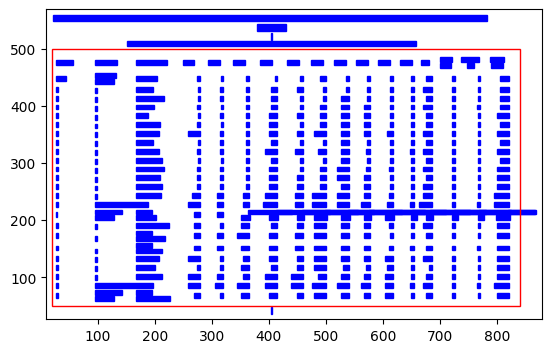

In [5]:
# Filepath
pdf_folder_path = 'data/PPPP'
filename = '2020_Q1.pdf'

# Read first table
table0 = camelot.read_pdf(
    os.path.join(pdf_folder_path,filename),
    pages='27',                        # Page for table
    flavor='stream',                   # stream preferred here, with lattice showing suboptimal performance for this pdf
    table_areas=['20,500,840,50']      # Area for table extraction
    )

camelot.plot(table0[0], kind='contour').show()
df_table0 = table0[0].df

# Squeeze first table and view output.
df_table0_new = squeeze(df_table0,3,3)
df_table0_new.head(10)

In [6]:
# Read all other tables
tables = camelot.read_pdf(
    os.path.join(pdf_folder_path,filename),
    pages='28-end',
    flavor='stream',
    table_areas=['20,550,840,50']
    )

# Check how many tables were extracted
print(f"Total tables extracted: {len(tables)}")

# Squeeze each table and combine all into a list
all_dfs = [table.df for table in tables]
all_dfs = [squeeze(df,3,3) for df in all_dfs]
all_dfs = [df_table0_new] + all_dfs

# Set column names
for df in all_dfs:
    df.columns = df.iloc[0]
all_dfs = [df[1:].reset_index(drop=True) for df in all_dfs]

# Make sure all tables have the same number of columns.
for i, df in enumerate(all_dfs):
    print(f'Table {i} has {len(df.columns)} columns')

Total tables extracted: 64
Table 0 has 15 columns
Table 1 has 16 columns
Table 2 has 17 columns
Table 3 has 17 columns
Table 4 has 16 columns
Table 5 has 16 columns
Table 6 has 17 columns
Table 7 has 17 columns
Table 8 has 17 columns
Table 9 has 16 columns
Table 10 has 17 columns
Table 11 has 17 columns
Table 12 has 16 columns
Table 13 has 17 columns
Table 14 has 17 columns
Table 15 has 17 columns
Table 16 has 17 columns
Table 17 has 17 columns
Table 18 has 17 columns
Table 19 has 16 columns
Table 20 has 17 columns
Table 21 has 17 columns
Table 22 has 16 columns
Table 23 has 16 columns
Table 24 has 16 columns
Table 25 has 16 columns
Table 26 has 16 columns
Table 27 has 17 columns
Table 28 has 16 columns
Table 29 has 17 columns
Table 30 has 17 columns
Table 31 has 17 columns
Table 32 has 17 columns
Table 33 has 17 columns
Table 34 has 17 columns
Table 35 has 16 columns
Table 36 has 17 columns
Table 37 has 17 columns
Table 38 has 17 columns
Table 39 has 16 columns
Table 40 has 17 columns

Based on visual inspection of the tables in this particular pdf, we expect 17 columns for each table.

![PPPP 2020 Q1 table view](./assets/2020_Q1_table_view.png)

We investigate why some tables have fewer than 17 columns.

In [7]:
# Inspect tables with fewer columns than expected
small_tables = []
for i, df in enumerate(all_dfs):
    if len(df.columns) != 17:
        small_tables.append(i)
        if i <= 19:
            # Show some of the tables
            print(f'\n\n\nTable {i}')
            display(df.head())




Table 0


,REGIONPROVINCEMUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,FNSP,HSF,IPsinGIDA,ItinerantIPs,GrandTotal
0,NCR FIRST,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NCR \nBINONDO,2,-,1,-,-,56,3,-,-,-,39,-,-,101
2,DISTRICT,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ERMITA,-,1,1,51,12,2,7,-,-,-,114,-,-,188
4,INTRAMUROS,-,1,-,83,-,2,122,-,-,-,47,-,-,255





Table 1


,REGION,PROVINCEMUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,FNSP,HSF,IPsinGIDA,ItinerantIPs,GrandTotal
0,,CITY OF,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,,12,15,741,647,102,"4,963","1,173",1,343,1,19,-,-,"8,017"
2,,MARIKINA,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,,CITY OF PASIG,"1,510",19,29,"1,556",108,"7,644",482,9,4,1,46,-,-,"11,408"
4,,CITY OF SAN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN





Table 4


,REGION,PROVINCEMUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,FNSP,HSF,IPsinGIDA,ItinerantIPs,GrandTotal
0,,KALINGA Total,"1,946",1,14,"2,104","4,317",732,"1,103",143,186,7,-,227,-,"10,780"
1,,MOUNTAIN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,,BARLIG,1,-,-,153,2,-,47,2,-,-,-,48,-,253
3,,PROVINCE,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,,BAUKO,2,2,4,10,"1,014",17,89,7,30,2,-,1,-,"1,178"





Table 5


,REGION,PROVINCEMUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,FNSP,HSF,IPsinGIDA,ItinerantIPs,GrandTotal
0,,PAOAY,-,-,-,3,694,32,75,4,67,-,-,-,-,875
1,,PASUQUIN,3,1,3,1,894,37,56,4,68,-,-,-,-,"1,067"
2,,PIDDIG,-,1,-,1,601,30,36,2,83,-,-,-,-,754
3,,PINILI,1,-,331,270,8,143,48,2,54,-,-,-,-,857
4,,SAN NICOLAS,-,-,3,1,8,608,47,3,53,-,-,-,-,723





Table 9


,REGION,PROVINCEMUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,FNSP,HSF,IPsinGIDA,ItinerantIPs,GrandTotal
0,,UMINGAN,3,2,6,8,28,"2,873",138,16,289,-,-,1,-,"3,364"
1,,URBIZTONDO,"1,836",1,4,8,27,301,395,27,371,-,-,-,-,"2,970"
2,,VILLASIS,4,-,1,6,23,"1,696",54,8,237,-,-,1,-,"2,030"
3,,PANGASINAN Total,"8,195",31,"3,399","7,779","45,820","39,185","12,526",690,"9,879",-,-,208,-,"127,712"
4,I Total,,"8,256","1,698","8,410","13,498","77,306","60,614","16,869","1,037","14,963",-,-,"2,468",-,"205,119"





Table 12


,REGION,PROVINCEMUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,FNSP,HSF,IPsinGIDA,ItinerantIPs,GrandTotal
0,,QUEZON,2,1,-,4,549,39,18,5,29,-,-,-,-,647
1,,SANTA FE,3,-,370,1,10,436,54,4,28,-,-,-,-,906
2,,SOLANO,5,-,3,4,699,86,15,6,33,-,-,-,-,851
3,,VILLAVERDE,-,-,-,3,373,22,14,4,28,-,-,-,-,444
4,,NUEVA VIZCAYA Total,20,1,934,"2,240","6,385","1,693",878,68,500,-,-,"2,204",-,"14,923"





Table 19


,REGIONPROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,FNSP,HSF,IPsinGIDA,ItinerantIPs,GrandTotal
0,,GEN. MARIANO,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,,6,4,308,37,53,"1,871",246,1,120,-,-,-,-,"2,646"
2,,ALVAREZ,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,,GENERAL EMILIO,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,,,-,-,216,4,9,283,21,-,18,-,-,-,-,551


We see that some tables have the `REGION` and `PROVINCE` columns merged, the `PROVINCE` and `MUNICIPALITY` columns merged, or all of `REGION`, `PROVINCE` and `MUNICIPALITY` columns merged. We first split these columns for each table, and then assign the necessary values to the appropriate columns (where possible). The latter operation is done using the `split_col_val` function.

In [8]:
# Fix tables where REGION, PROVINCE and MUNICIPALITY columns may be merged, one way or another
for i in small_tables:
    if 'REGIONPROVINCE' in all_dfs[i].columns:
        all_dfs[i].rename(columns={'REGIONPROVINCE':'PROVINCE'}, inplace=True)
        all_dfs[i] = pd.concat([pd.DataFrame('', index=all_dfs[i].index, columns=['REGION']),
                                all_dfs[i]],
                                axis=1)
    elif 'PROVINCEMUNICIPALITY' in all_dfs[i].columns:
        all_dfs[i].rename(columns={'PROVINCEMUNICIPALITY':'MUNICIPALITY'}, inplace=True)
        all_dfs[i] = pd.concat([all_dfs[i].iloc[:,0],
                                pd.DataFrame('', index=all_dfs[i].index, columns=['PROVINCE']),
                                all_dfs[i].iloc[:,1:]],
                                axis=1)
    elif 'REGIONPROVINCEMUNICIPALITY' in all_dfs[i].columns:
        all_dfs[i].rename(columns={'REGIONPROVINCEMUNICIPALITY':'MUNICIPALITY'}, inplace=True)
        all_dfs[i] = pd.concat([pd.DataFrame('', index=all_dfs[i].index, columns=['REGION','PROVINCE']),
                            all_dfs[i]],
                            axis=1)
    else:
        raise Exception('Unknown column merge type')

In [9]:
# Combine into single dataframe before further processing
df_2020_Q1 = pd.concat(all_dfs,axis=0).reset_index(drop=True)
df_2020_Q1 = split_col_val(df_2020_Q1)

We now have the correct number of columns. Unfortunately, due to the merged nature of some of the original columns, the values may not have been placed in the correct (freshly-split) column. These issues are uncovered during the checks that we perform later, and corrected manually here.

In [10]:
# Shift totals mistakenly placed in muni column instead of province
df_2020_Q1 = shift_col(df_2020_Q1,'PROVINCE','REGION',[793,892,1])
df_2020_Q1 = shift_col(df_2020_Q1,'MUNICIPALITY','PROVINCE',[0,2,2088,2170,162,191,320,445,840,
                                                             938,980,1223,1676,1849,1676,
                                                             424,435,869,997,1431,1927,
                                                             1893,1895,1917])

# Fix small issues around
df_2020_Q1.loc[892,'REGION'] = df_2020_Q1.loc[892,'REGION'].replace('TOTAL','Total')
df_2020_Q1.loc[30,'MUNICIPALITY'] = ''
df_2020_Q1.iloc[18,5:] = df_2020_Q1.iloc[19,5:]
df_2020_Q1.iloc[19,5:] = ''

Once basic cleaning is done, we extract the required records from the main dataframe, i.e. `df_2020_Q1`, namely the rows giving regional sums, provincial sums, as well as individual municipal records. This is done using:
1. the `get_total_locs` function, which identifies the indices of rows showing the total value for the location of interest (whether region or province);
2. the `split_tables` function, which utilizes the row locations acquired in the previous step to split the table into sub-dataframes  by region and/or province, facilitating subsequent data extraction;
3. the `get_totals` function, which extracts the regional and provincial sums; and
4. the `clean_province_df` function which cleans the province sub-dataframes to extract municipal records.

These steps produce the `region_total`, `province_totals`, and `municipals`.

In [11]:
# Split table by region
total_rows_region = get_total_locs(df_2020_Q1,col=0)         # Get row numbers corresponding to 'total' rows for REGION
region_dfs = split_tables(df_2020_Q1,total_rows_region)      # Split into one table per REGION

# Collect
region_totals = []
province_totals = []
municipals = []
for i, region_df_or in enumerate(region_dfs):
    # Get region totals
    region_df = region_df_or.copy()
    total_row, region_name = get_totals(region_df,col=0)
    region_totals.append(total_row)    

    # Split table by province
    region_df = region_df_or.copy()
    total_rows_province = get_total_locs(region_df,col=1)     # Get row numbers corresponding to 'total' rows for PROVINCE
    province_dfs = split_tables(region_df,total_rows_province)      # Split into one table per REGION

    for j,province_df_or in enumerate(province_dfs):
        province_df = province_df_or.copy()
        total_row, province_name = get_totals(province_df,col=1)
        total_row.iloc[0] = region_name
        province_totals.append(total_row)
        
        municipal_df = clean_province_df(province_df)
        municipal_df.iloc[:,0] = region_name
        municipal_df.iloc[:,1] = province_name
        municipals.append(municipal_df)

The list of series/dataframes are then compiled into:
1. `df_region_totals` - giving the total values by region as extracted from the tables;
2. `df_province_totals` - giving the total values by province as extracted from the tables; and
3. `df_municipals` - giving all the other rows (i.e. at the municipal level) as extarcted from the tables.

This is done using the `convert_to_numeric_df` function.

In [12]:
df_region_totals = pd.DataFrame(region_totals)
df_region_totals = convert_to_numeric_df(df_region_totals)

df_province_totals = pd.DataFrame(province_totals)
df_province_totals = convert_to_numeric_df(df_province_totals)

df_municipals = pd.concat(municipals,axis=0)
df_municipals = convert_to_numeric_df(df_municipals)

print('Regional sums:')
display(df_region_totals.head())
print('\nProvincial sums:')
display(df_province_totals.head())
print('\nMunicipal records:')
display(df_municipals.head())

Regional sums:


,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,FNSP,HSF,IPsinGIDA,ItinerantIPs,GrandTotal
56,NCR,Total,Total,10052,497,7454,34453,35172,94603,27162,872,1732,6,3199,1,3,215206
104,CAR,Total,Total,10827,27,1961,12015,23201,4271,4212,541,768,18,0,2299,0,60140
157,I,Total,Total,8256,1698,8410,13498,77306,60614,16869,1037,14963,0,0,2468,0,205119
114,II,Total,Total,4827,33,9112,7769,53093,13827,4190,1401,3717,1,0,5736,0,103706
176,III,Total,Total,6714,280,17750,11820,53666,156284,26996,1232,10415,14,119,4468,0,289758



Provincial sums:


,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,FNSP,HSF,IPsinGIDA,ItinerantIPs,GrandTotal
16,NCR,NCR FIRST DISTRICT,Total,1834,39,57,10173,979,19704,7723,210,67,1,1709,0,1,42497
13,NCR,NCR FOURTH DISTRICT,Total,2254,125,3558,4352,4596,23390,3418,140,490,1,614,0,2,42940
11,NCR,NCR SECOND DISTRICT,Total,2703,159,1927,8525,762,39560,8994,352,592,4,593,1,0,64172
12,NCR,NCR THIRD DISTRICT,Total,3261,174,1912,11403,28835,11949,7027,170,583,0,283,0,0,65597
31,CAR,ABRA,Total,3866,2,7,2245,4170,285,1135,59,116,3,0,132,0,12020



Municipal records:


,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,FNSP,HSF,IPsinGIDA,ItinerantIPs,GrandTotal
1,NCR,NCR FIRST DISTRICT,BINONDO,2,0,1,0,0,56,3,0,0,0,39,0,0,101
3,NCR,NCR FIRST DISTRICT,ERMITA,0,1,1,51,12,2,7,0,0,0,114,0,0,188
4,NCR,NCR FIRST DISTRICT,INTRAMUROS,0,1,0,83,0,2,122,0,0,0,47,0,0,255
5,NCR,NCR FIRST DISTRICT,MALATE,3,0,2,86,5,17,668,24,0,0,158,0,1,964
6,NCR,NCR FIRST DISTRICT,PACO,0,1,3,614,79,60,219,14,0,0,43,0,0,1033


Finally, we check for data accuracy by verifying that:
1. municipal records add up to provincial sums provided by the original data source
2. provincial sums add up to regional sums

In [13]:
# check if municipal sums up to province values. It does!
df_municipals_temp = df_municipals.copy()
df_municipals_temp = df_municipals_temp.groupby(list(df_municipals.columns[:2])).sum().drop(columns=df_municipals.columns[2])
df_municipals_temp = df_municipals_temp.reset_index().sort_values(list(df_municipals.columns[:2]))

df_province_totals_temp = df_province_totals.copy()
df_province_totals_temp = df_province_totals_temp.drop(columns=[df_province_totals.columns[2]])
df_province_totals_temp = df_province_totals_temp.sort_values(list(df_province_totals.columns[:2])).reset_index(drop=True)

df_municipals_temp.equals(df_province_totals_temp)

True

In [14]:
# Check if province sums up to region values. It does!
df_province_totals_temp = df_province_totals.copy()
df_province_totals_temp = df_province_totals_temp.groupby(df_province_totals.columns[0]).sum()
df_province_totals_temp.drop(columns=df_province_totals.columns[1:3],inplace=True)
df_province_totals_temp = df_province_totals_temp.sort_index()

df_region_totals_temp = df_region_totals.copy()
df_region_totals_temp = df_region_totals_temp.drop(columns=df_region_totals.columns[1:3])
df_region_totals_temp = df_region_totals_temp.set_index(df_region_totals.columns[0])
df_region_totals_temp = df_region_totals_temp.drop('Grand').sort_index()

df_province_totals_temp.equals(df_region_totals_temp)

True

As shown above, the checks show consistent values between the dataframes. If a mismatch is found here, further investigation is done to identify the source of the error, and rectify it as in the earlier cells.

### 2020_Q2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,FNSP,HSF,IPsinGIDA,ItinerantIPs,GrandTotal
0,,NCR FIRST,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NCR,,BINONDO,2,-,1,-,-,56,4,-,1,-,37,-,-,101
2,,DISTRICT,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,,,ERMITA,-,1,1,51,12,2,7,-,2,-,98,-,-,174
4,,,INTRAMUROS,-,1,-,83,-,2,122,-,18,-,39,-,-,265
5,,,MALATE,4,-,2,86,5,17,667,24,-,-,142,-,1,948
6,,,PACO,-,1,3,614,79,60,221,14,-,-,35,-,-,"1,027"
7,,,PANDACAN,2,-,-,354,8,18,465,27,-,-,29,-,-,903
8,,,PORT AREA,"1,250",7,8,243,19,"2,276",213,19,134,-,104,-,-,"4,273"


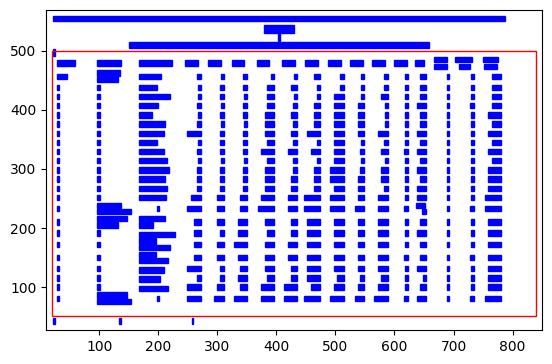

In [15]:
# Filepath
pdf_folder_path = 'data/PPPP'
filename = '2020_Q2.pdf'

# Read first table
table0 = camelot.read_pdf(
    os.path.join(pdf_folder_path,filename),
    pages='29',                        # Page for table
    flavor='stream',                   # stream preferred here, with lattice showing suboptimal performance for this pdf
    table_areas=['20,500,840,50']      # Area for table extraction
    )

camelot.plot(table0[0], kind='contour').show()
df_table0 = table0[0].df

# Squeeze first table and view output.
df_table0_new = squeeze(df_table0,3,3)
df_table0_new.head(10)

In [16]:
# Read all other tables
tables = camelot.read_pdf(
    os.path.join(pdf_folder_path,filename),
    pages='30-end',
    flavor='stream',
    table_areas=['20,550,840,50']
    )

# Check how many tables were extracted
print(f"Total tables extracted: {len(tables)}")

# Squeeze each table and combine all into a list
all_dfs = [table.df for table in tables]
all_dfs = [squeeze(df,3,3) for df in all_dfs]
all_dfs = [df_table0_new] + all_dfs

# Set column names
for df in all_dfs:
    df.columns = df.iloc[0]
all_dfs = [df[1:].reset_index(drop=True) for df in all_dfs]

# Make sure all tables have the same number of columns.
for i, df in enumerate(all_dfs):
    print(f'Table {i} has {len(df.columns)} columns')

Total tables extracted: 64
Table 0 has 17 columns
Table 1 has 17 columns
Table 2 has 17 columns
Table 3 has 17 columns
Table 4 has 17 columns
Table 5 has 17 columns
Table 6 has 17 columns
Table 7 has 17 columns
Table 8 has 17 columns
Table 9 has 17 columns
Table 10 has 17 columns
Table 11 has 17 columns
Table 12 has 17 columns
Table 13 has 17 columns
Table 14 has 17 columns
Table 15 has 17 columns
Table 16 has 17 columns
Table 17 has 17 columns
Table 18 has 17 columns
Table 19 has 17 columns
Table 20 has 17 columns
Table 21 has 17 columns
Table 22 has 17 columns
Table 23 has 17 columns
Table 24 has 17 columns
Table 25 has 17 columns
Table 26 has 17 columns
Table 27 has 17 columns
Table 28 has 17 columns
Table 29 has 17 columns
Table 30 has 17 columns
Table 31 has 17 columns
Table 32 has 17 columns
Table 33 has 17 columns
Table 34 has 17 columns
Table 35 has 17 columns
Table 36 has 17 columns
Table 37 has 17 columns
Table 38 has 17 columns
Table 39 has 17 columns
Table 40 has 17 columns

For this report, some misalignment needs to be managed manually by shifting the values cell by cell for some rows.

In [17]:
# Fix table 0, NCR
for col1,col2 in zip(reversed(['IPsinGIDA', 'ItinerantIPs', 'GrandTotal']),
                     reversed(['HSF', 'IPsinGIDA', 'ItinerantIPs'])):
    all_dfs[0].loc[17,col1] = all_dfs[0].loc[17,col2]
all_dfs[0].loc[17,'HSF'] = '1,581'


# Fix table 1, NCR
for col1,col2 in zip(reversed(['IPsinGIDA', 'ItinerantIPs', 'GrandTotal']),
                     reversed(['HSF', 'IPsinGIDA', 'ItinerantIPs'])):
    all_dfs[1].loc[31,col1] = all_dfs[1].loc[31,col2]
all_dfs[1].loc[31,'HSF'] = '2,959'

# Fix table 17, III
for col1,col2 in zip(reversed(['SET7', 'SET8', 'SET9', 'FNSP', 'HSF', 'IPsinGIDA', 'ItinerantIPs', 'GrandTotal']),
                     reversed(['SET6', 'SET7', 'SET8', 'SET9', 'FNSP', 'HSF', 'IPsinGIDA', 'ItinerantIPs'])):
    all_dfs[17].loc[30,col1] = all_dfs[17].loc[30,col2]
all_dfs[17].loc[30,'SET6'] = '156,401'


# Fix table 22, IV
for col1,col2 in zip(reversed(['SET7', 'SET8', 'SET9', 'FNSP', 'HSF', 'IPsinGIDA', 'ItinerantIPs', 'GrandTotal']),
                     reversed(['SET6', 'SET7', 'SET8', 'SET9', 'FNSP', 'HSF', 'IPsinGIDA', 'ItinerantIPs'])):
    all_dfs[22].loc[40,col1] = all_dfs[22].loc[40,col2]
all_dfs[22].loc[40,'SET6'] = '117,184'

# Fix table 38, VII
all_dfs[38].loc[39,'SET8'] = '14,742'
all_dfs[38].loc[39,'SET9'] = '6,228'
all_dfs[38].loc[39,'FNSP'] = '10,210'
all_dfs[38].loc[39,'HSF'] = '483'
all_dfs[38].loc[39,'IPsinGIDA'] = '13'
all_dfs[38].loc[39,'ItinerantIPs'] = '-'
all_dfs[38].loc[39,'GrandTotal'] = '149,731'

# Fix table 40, VII
all_dfs[40].loc[5,'SET8'] = '19,643'
all_dfs[40].loc[5,'SET9'] = '13,901'
all_dfs[40].loc[5,'FNSP'] = '10,817'
all_dfs[40].loc[5,'HSF'] = '483'
all_dfs[40].loc[5,'IPsinGIDA'] = '2,527'
all_dfs[40].loc[5,'ItinerantIPs'] = '-'
all_dfs[40].loc[5,'GrandTotal'] = '284,627'

# Fix table 42, VIII
for col1,col2 in zip(reversed(['HSF', 'IPsinGIDA', 'ItinerantIPs', 'GrandTotal']),
                     reversed(['FNSP', 'HSF', 'IPsinGIDA', 'ItinerantIPs'])):
    all_dfs[42].loc[41,col1] = all_dfs[42].loc[41,col2]
all_dfs[42].loc[41,'FNSP'] = '12,922'

# Fix table 48, IX
for col1,col2 in zip(reversed(['SET9', 'FNSP', 'HSF', 'IPsinGIDA', 'ItinerantIPs', 'GrandTotal']),
                     reversed(['SET8', 'SET9', 'FNSP', 'HSF', 'IPsinGIDA', 'ItinerantIPs'])):
    all_dfs[48].loc[24,col1] = all_dfs[48].loc[24,col2]
all_dfs[48].loc[24,'SET8'] = '11,861'

# Fix table 45, VIII
for col1,col2 in zip(reversed(['HSF', 'IPsinGIDA', 'ItinerantIPs', 'GrandTotal']),
                     reversed(['FNSP', 'HSF', 'IPsinGIDA', 'ItinerantIPs'])):
    all_dfs[45].loc[26,col1] = all_dfs[45].loc[26,col2]
all_dfs[45].loc[26,'FNSP'] = '13,534'

We then perform the familiar operations.

In [18]:
df_2020_Q2 = pd.concat(all_dfs,axis=0).reset_index(drop=True)

In [19]:
# Split table by region
total_rows_region = get_total_locs(df_2020_Q2,col=0)         # Get row numbers corresponding to 'total' rows for REGION
region_dfs = split_tables(df_2020_Q2,total_rows_region)      # Split into one table per REGION

# Collect
region_totals = []
province_totals = []
municipals = []
for i, region_df_or in enumerate(region_dfs):
    # Get region totals
    region_df = region_df_or.copy()
    total_row, region_name = get_totals(region_df,col=0)
    region_totals.append(total_row)    

    # Split table by province
    region_df = region_df_or.copy()
    total_rows_province = get_total_locs(region_df,col=1)     # Get row numbers corresponding to 'total' rows for PROVINCE
    province_dfs = split_tables(region_df,total_rows_province)      # Split into one table per REGION

    for province_df_or in province_dfs:
        province_df = province_df_or.copy()
        total_row, province_name = get_totals(province_df,col=1)
        total_row.iloc[0] = region_name
        province_totals.append(total_row)

        municipal_df = clean_province_df3(province_df)
        municipal_df.iloc[:,0] = region_name
        municipal_df.iloc[:,1] = province_name
        municipals.append(municipal_df)

In [20]:
df_region_totals = pd.DataFrame(region_totals)
df_region_totals = convert_to_numeric_df(df_region_totals)

df_province_totals = pd.DataFrame(province_totals)
df_province_totals = convert_to_numeric_df(df_province_totals)

df_municipals = pd.concat(municipals,axis=0)
df_municipals = convert_to_numeric_df(df_municipals)

print('Regional sums:')
display(df_region_totals.head())
print('\nProvincial sums:')
display(df_province_totals.head())
print('\nMunicipal records:')
display(df_municipals.head())

Regional sums:


,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,FNSP,HSF,IPsinGIDA,ItinerantIPs,GrandTotal
68,NCR,Total,Total,10070,501,7472,34488,35236,94550,27365,878,7054,5,2959,2,3,220583
156,CAR,Total,Total,10791,28,1961,12010,23137,4268,4217,538,909,18,0,2234,0,60111
245,I,Total,Total,8254,1698,8406,13504,77315,60620,16919,1040,15431,0,0,2428,0,205615
171,II,Total,Total,4839,36,9139,7782,53224,13859,4214,1405,5156,1,0,5585,0,105240
271,III,Total,Total,6715,290,17738,11859,53695,156401,27294,1236,14185,13,70,4200,0,293696



Provincial sums:


,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,FNSP,HSF,IPsinGIDA,ItinerantIPs,GrandTotal
18,NCR,NCR FIRST DISTRICT,Total,1835,39,58,10178,982,19712,7771,210,901,1,1581,0,1,43269
17,NCR,NCR FOURTH DISTRICT,Total,2265,126,3562,4372,4619,23378,3491,142,1618,1,571,0,2,44147
14,NCR,NCR SECOND DISTRICT,Total,2706,161,1934,8522,774,39518,9015,354,2196,3,538,1,0,65722
14,NCR,NCR THIRD DISTRICT,Total,3264,175,1918,11416,28861,11942,7088,172,2339,0,269,1,0,67445
53,CAR,ABRA,Total,3864,2,7,2243,4166,282,1134,59,158,3,0,129,0,12047



Municipal records:


,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,FNSP,HSF,IPsinGIDA,ItinerantIPs,GrandTotal
1,NCR,NCR FIRST DISTRICT,BINONDO,2,0,1,0,0,56,4,0,1,0,37,0,0,101
3,NCR,NCR FIRST DISTRICT,ERMITA,0,1,1,51,12,2,7,0,2,0,98,0,0,174
4,NCR,NCR FIRST DISTRICT,INTRAMUROS,0,1,0,83,0,2,122,0,18,0,39,0,0,265
5,NCR,NCR FIRST DISTRICT,MALATE,4,0,2,86,5,17,667,24,0,0,142,0,1,948
6,NCR,NCR FIRST DISTRICT,PACO,0,1,3,614,79,60,221,14,0,0,35,0,0,1027


In [21]:
# Check if province sums up to region values. It does!
df_province_totals_temp = df_province_totals.copy()
df_province_totals_temp = df_province_totals_temp.groupby(df_province_totals.columns[0]).sum()
df_province_totals_temp.drop(columns=df_province_totals.columns[1:3],inplace=True)
df_province_totals_temp = df_province_totals_temp.sort_index()

df_region_totals_temp = df_region_totals.copy()
df_region_totals_temp = df_region_totals_temp.drop(columns=df_region_totals.columns[1:3])
df_region_totals_temp = df_region_totals_temp.set_index(df_region_totals.columns[0])
df_region_totals_temp = df_region_totals_temp.drop('Grand').sort_index()

df_province_totals_temp.equals(df_region_totals_temp)

True

In [22]:
# check if municipal sums up to province values. It does!
df_municipals_temp = df_municipals.copy()
df_municipals_temp = df_municipals_temp.groupby(list(df_municipals.columns[:2])).sum().drop(columns=df_municipals.columns[2])
df_municipals_temp = df_municipals_temp.reset_index().sort_values(list(df_municipals.columns[:2]))

df_province_totals_temp = df_province_totals.copy()
df_province_totals_temp = df_province_totals_temp.drop(columns=[df_province_totals.columns[2]])
df_province_totals_temp = df_province_totals_temp.sort_values(list(df_province_totals.columns[:2])).reset_index(drop=True)

df_municipals_temp.equals(df_province_totals_temp)

True

### 2020_Q3

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,FNSP,HomelessStreetFamilies,IPsinGIDA,ItinerantIPs,GrandTotal
0,,NCR FIRST,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NCR,,BINONDO,2,-,1,-,-,56,4,-,1,-,37,-,-,101
2,,DISTRICT,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,,,ERMITA,-,1,1,51,12,2,7,-,2,-,96,-,-,172
4,,,INTRAMUROS,-,1,-,83,-,2,122,-,18,-,39,-,-,265
5,,,MALATE,4,-,2,86,5,17,668,24,-,-,142,-,1,949
6,,,PACO,-,1,3,613,79,60,221,14,-,-,33,-,-,"1,024"
7,,,PANDACAN,2,-,-,354,8,18,469,27,-,-,29,-,-,907
8,,,PORT AREA,"1,253",7,8,243,20,"2,274",215,19,144,-,104,-,-,"4,287"


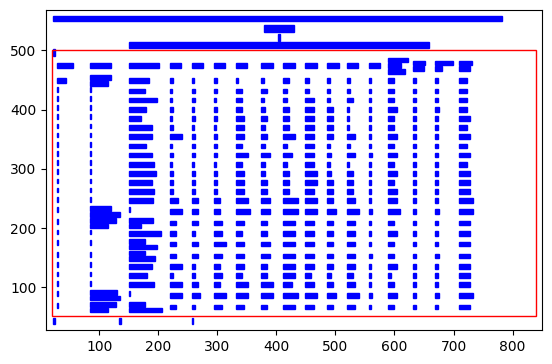

In [23]:
# Filepath
pdf_folder_path = 'data/PPPP'
filename = '2020_Q3.pdf'

# Read first table
table0 = camelot.read_pdf(
    os.path.join(pdf_folder_path,filename),
    pages='38',                        # Page for table
    flavor='stream',                   # stream preferred here, with lattice showing suboptimal performance for this pdf
    table_areas=['20,500,840,50']      # Area for table extraction
    )

camelot.plot(table0[0], kind='contour').show()
df_table0 = table0[0].df

# Squeeze first table and view output.
df_table0_new = squeeze(df_table0,5,3)
df_table0_new.head(10)

In [24]:
# Read all other tables
tables = camelot.read_pdf(
    os.path.join(pdf_folder_path,filename),
    pages='39-end',
    flavor='stream',
    table_areas=['20,550,840,50']
    )

# View first of subsequent tables
tables[0].df.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,,,CITY OF,,,,,,,,,,,,,,
1,,,,13,14,745,652,104,"4,968","1,174",2,358,1,19,-,-,"8,050"
2,,,MARIKINA,,,,,,,,,,,,,,
3,,,CITY OF PASIG,"1,504",21,30,"1,561",112,"7,625",499,8,21,1,42,-,-,"11,424"
4,,,CITY OF SAN,,,,,,,,,,,,,,
5,,,,2,1,205,16,24,719,58,-,80,-,22,-,-,"1,127"
6,,,JUAN,,,,,,,,,,,,,,
7,,,QUEZON CITY,"1,163",116,158,"5,875",460,"20,416","6,700",312,"1,325",1,414,1,-,"36,941"
8,,NCR SECOND,,,,,,,,,,,,,,,
9,,,,"2,704",161,"1,940","8,544",785,"39,517","9,049",355,"2,195",3,536,1,-,"65,790"


Compared to the previous documents, the 2020 Q3 report has headers for the table on the first appendix page, but not the subsequent tables which are assumed to have the same headers.

![PPPP 2020 Q3 table view with headers](./assets/2020_Q3_header_issues.png)

We perform data processing accordingly.

In [25]:
# Squeeze each table and combine all into a list, accounting for no header scenario
all_dfs = [table.df for table in tables]
all_dfs = [squeeze(df,0,3) for df in all_dfs]
all_dfs = [df_table0_new] + all_dfs

num_col = all_dfs[0].shape[1]
for i,df in enumerate(all_dfs[1:]):
    if df.shape[1] < num_col:
        all_dfs[i+1] = pd.concat([pd.DataFrame('', index=df.index, columns=range(num_col-df.shape[1])),
                                  df],
                                 axis=1)
        all_dfs[i+1] = all_dfs[i+1].reset_index(drop=True)

# Set column names
for df in all_dfs:
    df.columns = all_dfs[0].iloc[0]
all_dfs[0] = all_dfs[0][1:].reset_index(drop=True)

# Make sure all tables have the same number of columns.
for i, df in enumerate(all_dfs):
    print(f'Table {i} has {len(df.columns)} columns')

Table 0 has 17 columns
Table 1 has 17 columns
Table 2 has 17 columns
Table 3 has 17 columns
Table 4 has 17 columns
Table 5 has 17 columns
Table 6 has 17 columns
Table 7 has 17 columns
Table 8 has 17 columns
Table 9 has 17 columns
Table 10 has 17 columns
Table 11 has 17 columns
Table 12 has 17 columns
Table 13 has 17 columns
Table 14 has 17 columns
Table 15 has 17 columns
Table 16 has 17 columns
Table 17 has 17 columns
Table 18 has 17 columns
Table 19 has 17 columns
Table 20 has 17 columns
Table 21 has 17 columns
Table 22 has 17 columns
Table 23 has 17 columns
Table 24 has 17 columns
Table 25 has 17 columns
Table 26 has 17 columns
Table 27 has 17 columns
Table 28 has 17 columns
Table 29 has 17 columns
Table 30 has 17 columns
Table 31 has 17 columns
Table 32 has 17 columns
Table 33 has 17 columns
Table 34 has 17 columns
Table 35 has 17 columns
Table 36 has 17 columns
Table 37 has 17 columns
Table 38 has 17 columns
Table 39 has 17 columns
Table 40 has 17 columns
Table 41 has 17 columns
Ta

No further clean up required for this pdf. We perform the same operations as before from here.

In [26]:
df_2020_Q3 = pd.concat(all_dfs,axis=0).reset_index(drop=True)

In [27]:
# Split table by region
total_rows_region = get_total_locs(df_2020_Q3,col=0)         # Get row numbers corresponding to 'total' rows for REGION
region_dfs = split_tables(df_2020_Q3,total_rows_region)      # Split into one table per REGION

# Collect
region_totals = []
province_totals = []
municipals = []
for i, region_df_or in enumerate(region_dfs):
    # Get region totals
    region_df = region_df_or.copy()
    total_row, region_name = get_totals(region_df,col=0)
    region_totals.append(total_row)    

    # Split table by province
    region_df = region_df_or.copy()
    total_rows_province = get_total_locs(region_df,col=1)     # Get row numbers corresponding to 'total' rows for PROVINCE
    province_dfs = split_tables(region_df,total_rows_province)      # Split into one table per REGION

    for province_df_or in province_dfs:
        province_df = province_df_or.copy()
        total_row, province_name = get_totals(province_df,col=1)
        total_row.iloc[0] = region_name
        province_totals.append(total_row)

        municipal_df = clean_province_df(province_df)
        municipal_df.iloc[:,0] = region_name
        municipal_df.iloc[:,1] = province_name
        municipals.append(municipal_df)

In [28]:
df_region_totals = pd.DataFrame(region_totals)
df_region_totals = convert_to_numeric_df(df_region_totals)

df_province_totals = pd.DataFrame(province_totals)
df_province_totals = convert_to_numeric_df(df_province_totals)

df_municipals = pd.concat(municipals,axis=0)
df_municipals = convert_to_numeric_df(df_municipals)

print('Regional sums:')
display(df_region_totals.head())
print('\nProvincial sums:')
display(df_province_totals.head())
print('\nMunicipal records:')
display(df_municipals.head())

Regional sums:


,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,FNSP,HomelessStreetFamilies,IPsinGIDA,ItinerantIPs,GrandTotal
63,NCR,Total,Total,10075,504,7486,34511,35232,94558,27459,881,7544,5,2936,2,3,221196
104,CAR,Total,Total,10731,28,1961,11984,23024,4239,4208,536,914,18,0,2212,0,59855
163,I,Total,Total,8266,1705,8415,13506,77409,60683,16997,1040,15619,0,0,2410,0,206050
114,II,Total,Total,4849,36,9133,7791,53214,13851,4210,1403,5250,1,0,5568,0,105306
178,III,Total,Total,6727,293,17744,11881,53779,156480,27444,1241,14290,13,69,4180,0,294141



Provincial sums:


,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,FNSP,HomelessStreetFamilies,IPsinGIDA,ItinerantIPs,GrandTotal
18,NCR,NCR FIRST DISTRICT,Total,1840,40,59,10170,986,19709,7782,211,1369,1,1566,0,1,43734
15,NCR,NCR FOURTH DISTRICT,Total,2268,126,3568,4380,4625,23392,3508,143,1637,1,568,0,2,44218
14,NCR,NCR SECOND DISTRICT,Total,2704,161,1940,8544,785,39517,9049,355,2195,3,536,1,0,65790
12,NCR,NCR THIRD DISTRICT,Total,3263,177,1919,11417,28836,11940,7120,172,2343,0,266,1,0,67454
32,CAR,ABRA,Total,3854,2,7,2239,4163,282,1131,59,160,3,0,129,0,12029



Municipal records:


,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,FNSP,HomelessStreetFamilies,IPsinGIDA,ItinerantIPs,GrandTotal
1,NCR,NCR FIRST DISTRICT,BINONDO,2,0,1,0,0,56,4,0,1,0,37,0,0,101
3,NCR,NCR FIRST DISTRICT,ERMITA,0,1,1,51,12,2,7,0,2,0,96,0,0,172
4,NCR,NCR FIRST DISTRICT,INTRAMUROS,0,1,0,83,0,2,122,0,18,0,39,0,0,265
5,NCR,NCR FIRST DISTRICT,MALATE,4,0,2,86,5,17,668,24,0,0,142,0,1,949
6,NCR,NCR FIRST DISTRICT,PACO,0,1,3,613,79,60,221,14,0,0,33,0,0,1024


In [29]:
# Check if province sums up to region values. It does!
df_province_totals_temp = df_province_totals.copy()
df_province_totals_temp = df_province_totals_temp.groupby(df_province_totals.columns[0]).sum()
df_province_totals_temp.drop(columns=df_province_totals.columns[1:3],inplace=True)
df_province_totals_temp = df_province_totals_temp.sort_index()

df_region_totals_temp = df_region_totals.copy()
df_region_totals_temp = df_region_totals_temp.drop(columns=df_region_totals.columns[1:3])
df_region_totals_temp = df_region_totals_temp.set_index(df_region_totals.columns[0])
df_region_totals_temp = df_region_totals_temp.drop('Grand').sort_index()

df_province_totals_temp.equals(df_region_totals_temp)

True

In [30]:
# check if municipal sums up to province values. It does!
df_municipals_temp = df_municipals.copy()
df_municipals_temp = df_municipals_temp.groupby(list(df_municipals.columns[:2])).sum().drop(columns=df_municipals.columns[2])
df_municipals_temp = df_municipals_temp.reset_index().sort_values(list(df_municipals.columns[:2]))

df_province_totals_temp = df_province_totals.copy()
df_province_totals_temp = df_province_totals_temp.drop(columns=[df_province_totals.columns[2]])
df_province_totals_temp = df_province_totals_temp.sort_values(list(df_province_totals.columns[:2])).reset_index(drop=True)

df_municipals_temp.equals(df_province_totals_temp)

True

### 2020_Q4

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,FNSP,HSF,IPsinGIDA,ItinerantIPs,GrandTotal
0,NCR,NCR FIRST DISTRICT,BINONDO,2,-,1,-,-,56,4,-,1,-,-,36,-,-,100
1,,,ERMITA,-,1,-,50,12,2,7,-,2,-,-,84,-,-,158
2,,,INTRAMUROS,-,1,-,82,-,2,123,-,17,-,-,34,-,-,259
3,,,MALATE,4,-,2,87,5,16,668,24,-,-,-,117,-,1,924
4,,,PACO,1,1,3,610,77,58,229,14,-,-,-,29,-,-,"1,022"
5,,,PANDACAN,2,-,-,354,8,19,470,27,-,-,-,25,-,-,905
6,,,PORT AREA,"1,246",6,7,242,19,"2,271",220,19,146,41,-,84,-,-,"4,301"
7,,,QUIAPO,-,2,1,17,6,3,361,-,10,-,-,29,-,-,429
8,,,SAMPALOC,7,4,7,"2,670",672,177,258,7,103,-,1,187,-,-,"4,093"


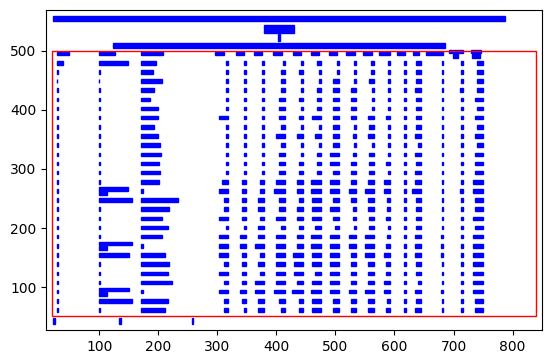

In [31]:
# Filepath
pdf_folder_path = 'data/PPPP'
filename = '2020_Q4.pdf'

# Read first table
table0 = camelot.read_pdf(
    os.path.join(pdf_folder_path,filename),
    pages='38',                        # Page for table
    flavor='stream',                   # stream preferred here, with lattice showing suboptimal performance for this pdf
    table_areas=['20,500,840,50']      # Area for table extraction
    )

camelot.plot(table0[0], kind='contour').show()
df_table0 = table0[0].df

# Squeeze first table and view output.
df_table0_new = squeeze(df_table0,3,3)
df_table0_new.head(10)

In [32]:
# Read all other tables
tables = camelot.read_pdf(
    os.path.join(pdf_folder_path,filename),
    pages='39-end',
    flavor='stream',
    table_areas=['20,550,840,50']
    )

# Check how many tables were extracted
print(f"Total tables extracted: {len(tables)}")

# Squeeze each table and combine all into a list
all_dfs = [table.df for table in tables]
all_dfs = [squeeze(df,3,3) for df in all_dfs]
all_dfs = [df_table0_new] + all_dfs

# Set column names
for df in all_dfs:
    df.columns = df.iloc[0]
all_dfs = [df[1:].reset_index(drop=True) for df in all_dfs]

# Make sure all tables have the same number of columns.
for i, df in enumerate(all_dfs):
    print(f'Table {i} has {len(df.columns)} columns')

Total tables extracted: 58
Table 0 has 18 columns
Table 1 has 18 columns
Table 2 has 18 columns
Table 3 has 18 columns
Table 4 has 18 columns
Table 5 has 18 columns
Table 6 has 18 columns
Table 7 has 18 columns
Table 8 has 18 columns
Table 9 has 18 columns
Table 10 has 18 columns
Table 11 has 18 columns
Table 12 has 18 columns
Table 13 has 18 columns
Table 14 has 18 columns
Table 15 has 18 columns
Table 16 has 18 columns
Table 17 has 18 columns
Table 18 has 18 columns
Table 19 has 18 columns
Table 20 has 18 columns
Table 21 has 18 columns
Table 22 has 18 columns
Table 23 has 18 columns
Table 24 has 18 columns
Table 25 has 18 columns
Table 26 has 18 columns
Table 27 has 18 columns
Table 28 has 18 columns
Table 29 has 18 columns
Table 30 has 18 columns
Table 31 has 18 columns
Table 32 has 18 columns
Table 33 has 18 columns
Table 34 has 18 columns
Table 35 has 18 columns
Table 36 has 18 columns
Table 37 has 18 columns
Table 38 has 18 columns
Table 39 has 18 columns
Table 40 has 18 columns

After fixing a missing value from the source, we perform the usual operations.

In [33]:
# Fix table 57
all_dfs[57].loc[12,'FNSP'] = '1'

In [34]:
df_2020_Q4 = pd.concat(all_dfs,axis=0).reset_index(drop=True)

In [35]:
# Split table by region
total_rows_region = get_total_locs(df_2020_Q4,col=0)         # Get row numbers corresponding to 'total' rows for REGION
region_dfs = split_tables(df_2020_Q4,total_rows_region)      # Split into one table per REGION

# Collect
region_totals = []
province_totals = []
municipals = []
for i, region_df_or in enumerate(region_dfs):
    # Get region totals
    region_df = region_df_or.copy()
    total_row, region_name = get_totals(region_df,col=0)
    region_totals.append(total_row)    

    # Split table by province
    region_df = region_df_or.copy()
    total_rows_province = get_total_locs(region_df,col=1)     # Get row numbers corresponding to 'total' rows for PROVINCE
    province_dfs = split_tables(region_df,total_rows_province)      # Split into one table per REGION

    for province_df_or in province_dfs:
        province_df = province_df_or.copy()
        total_row, province_name = get_totals(province_df,col=1)
        total_row.iloc[0] = region_name
        province_totals.append(total_row)

        municipal_df = clean_province_df(province_df)
        municipal_df.iloc[:,0] = region_name
        municipal_df.iloc[:,1] = province_name
        municipals.append(municipal_df)

In [36]:
df_region_totals = pd.DataFrame(region_totals)
df_region_totals = convert_to_numeric_df(df_region_totals)

df_province_totals = pd.DataFrame(province_totals)
df_province_totals = convert_to_numeric_df(df_province_totals)

df_municipals = pd.concat(municipals,axis=0)
df_municipals = convert_to_numeric_df(df_municipals)

print('Regional sums:')
display(df_region_totals.head())
print('\nProvincial sums:')
display(df_province_totals.head())
print('\nMunicipal records:')
display(df_municipals.head())

Regional sums:


,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,FNSP,HSF,IPsinGIDA,ItinerantIPs,GrandTotal
42,NCR,Total,Total,9964,492,7489,34209,35048,93993,27440,883,7625,688,4,2554,2,3,220394
85,CAR,Total,Total,10716,29,1955,11959,23001,4233,4206,534,945,43,17,0,2184,0,59822
129,I,Total,Total,8290,1710,8437,13536,77403,60728,16995,1037,16194,2964,1,0,2327,0,209622
91,II,Total,Total,4845,36,9125,7779,53148,13833,4207,1401,5400,1598,1,0,5499,0,106872
137,III,Total,Total,6752,297,17741,11904,53874,156658,27659,1239,14700,4107,12,41,3982,0,298966



Provincial sums:


,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,FNSP,HSF,IPsinGIDA,ItinerantIPs,GrandTotal
16,NCR,NCR FIRST DISTRICT,Total,1816,39,56,10028,982,19556,7778,211,1368,165,1,1403,0,1,43404
7,NCR,NCR SECOND DISTRICT,Total,2674,158,1941,8461,779,39231,9014,355,2195,35,2,432,1,0,65278
6,NCR,NCR THIRD DISTRICT,Total,3227,174,1918,11389,28692,11899,7127,174,2425,468,0,239,1,0,67733
9,NCR,NCR FOURTH DISTRICT,Total,2247,121,3574,4331,4595,23307,3521,143,1637,20,1,480,0,2,43979
27,CAR,ABRA,Total,3848,2,7,2236,4156,283,1129,59,165,4,3,0,129,0,12021



Municipal records:


,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,FNSP,HSF,IPsinGIDA,ItinerantIPs,GrandTotal
0,NCR,NCR FIRST DISTRICT,BINONDO,2,0,1,0,0,56,4,0,1,0,0,36,0,0,100
1,NCR,NCR FIRST DISTRICT,ERMITA,0,1,0,50,12,2,7,0,2,0,0,84,0,0,158
2,NCR,NCR FIRST DISTRICT,INTRAMUROS,0,1,0,82,0,2,123,0,17,0,0,34,0,0,259
3,NCR,NCR FIRST DISTRICT,MALATE,4,0,2,87,5,16,668,24,0,0,0,117,0,1,924
4,NCR,NCR FIRST DISTRICT,PACO,1,1,3,610,77,58,229,14,0,0,0,29,0,0,1022


In [37]:
# Check if province sums up to region values. It does!
df_province_totals_temp = df_province_totals.copy()
df_province_totals_temp = df_province_totals_temp.groupby(df_province_totals.columns[0]).sum()
df_province_totals_temp.drop(columns=df_province_totals.columns[1:3],inplace=True)
df_province_totals_temp = df_province_totals_temp.sort_index()

df_region_totals_temp = df_region_totals.copy()
df_region_totals_temp = df_region_totals_temp.drop(columns=df_region_totals.columns[1:3])
df_region_totals_temp = df_region_totals_temp.set_index(df_region_totals.columns[0])
df_region_totals_temp = df_region_totals_temp.drop('Grand').sort_index()

df_province_totals_temp.equals(df_region_totals_temp)

True

In [38]:
# check if municipal sums up to province values. It does!
df_municipals_temp = df_municipals.copy()
df_municipals_temp = df_municipals_temp.groupby(list(df_municipals.columns[:2])).sum().drop(columns=df_municipals.columns[2])
df_municipals_temp = df_municipals_temp.reset_index().sort_values(list(df_municipals.columns[:2]))

df_province_totals_temp = df_province_totals.copy()
df_province_totals_temp = df_province_totals_temp.drop(columns=[df_province_totals.columns[2]])
df_province_totals_temp = df_province_totals_temp.sort_values(list(df_province_totals.columns[:2])).reset_index(drop=True)

df_municipals_temp.equals(df_province_totals_temp)

True

### 2021_Q1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,FNSP,HSF,IPsGIDA,ItinerantIPs,GrandTotal
0,,NCR FIRST,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NCR,,BINONDO,2,-,1,-,-,53,4,-,1,-,-,36,-,-,97
2,,DISTRICT,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,,,ERMITA,-,1,-,48,12,1,7,-,2,-,-,73,-,-,144
4,,,INTRAMUROS,-,1,-,76,-,2,120,-,17,-,-,33,-,-,249
5,,,MALATE,4,-,2,85,5,16,636,24,-,-,-,116,-,1,889
6,,,PACO,1,1,3,574,74,55,219,12,1,5,-,31,-,-,976
7,,,PANDACAN,2,-,-,331,9,19,456,27,-,9,-,25,-,-,878
8,,,PORT AREA,"1,200",7,8,228,19,"2,180",214,17,139,50,-,82,-,-,"4,144"


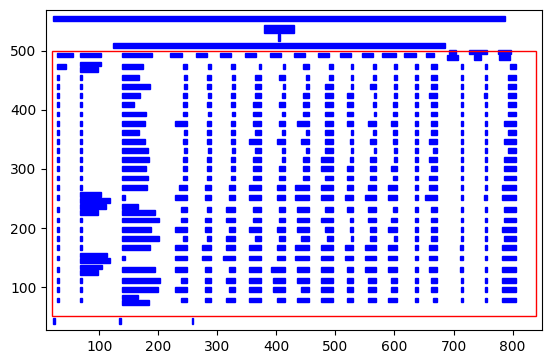

In [39]:
# Filepath
pdf_folder_path = 'data/PPPP'
filename = '2021_Q1.pdf'

# Read first table
table0 = camelot.read_pdf(
    os.path.join(pdf_folder_path,filename),
    pages='39',                        # Page for table
    flavor='stream',                   # stream preferred here, with lattice showing suboptimal performance for this pdf
    table_areas=['20,500,840,50']      # Area for table extraction
    )

camelot.plot(table0[0], kind='contour').show()
df_table0 = table0[0].df

# Squeeze first table and view output.
df_table0_new = squeeze(df_table0,3,3)
df_table0_new.head(10)

In [40]:
# Read all other tables
tables = camelot.read_pdf(
    os.path.join(pdf_folder_path,filename),
    pages='40-end',
    flavor='stream',
    table_areas=['20,550,840,50']
    )

# Check how many tables were extracted
print(f"Total tables extracted: {len(tables)}")

# Squeeze each table and combine all into a list
all_dfs = [table.df for table in tables]
all_dfs = [squeeze(df,3,3) for df in all_dfs]
all_dfs = [df_table0_new] + all_dfs

# Set column names
for df in all_dfs:
    df.columns = df.iloc[0]
all_dfs = [df[1:].reset_index(drop=True) for df in all_dfs]

# Make sure all tables have the same number of columns.
for i, df in enumerate(all_dfs):
    print(f'Table {i} has {len(df.columns)} columns')

Total tables extracted: 61
Table 0 has 18 columns
Table 1 has 18 columns
Table 2 has 17 columns
Table 3 has 18 columns
Table 4 has 18 columns
Table 5 has 17 columns
Table 6 has 18 columns
Table 7 has 18 columns
Table 8 has 18 columns
Table 9 has 18 columns
Table 10 has 18 columns
Table 11 has 18 columns
Table 12 has 18 columns
Table 13 has 18 columns
Table 14 has 18 columns
Table 15 has 18 columns
Table 16 has 18 columns
Table 17 has 18 columns
Table 18 has 17 columns
Table 19 has 18 columns
Table 20 has 18 columns
Table 21 has 18 columns
Table 22 has 18 columns
Table 23 has 18 columns
Table 24 has 18 columns
Table 25 has 18 columns
Table 26 has 18 columns
Table 27 has 17 columns
Table 28 has 18 columns
Table 29 has 18 columns
Table 30 has 18 columns
Table 31 has 18 columns
Table 32 has 18 columns
Table 33 has 18 columns
Table 34 has 18 columns
Table 35 has 18 columns
Table 36 has 18 columns
Table 37 has 18 columns
Table 38 has 17 columns
Table 39 has 18 columns
Table 40 has 18 columns

In [41]:
# Inspect tables with fewer columns than expected
small_tables = []
for i, df in enumerate(all_dfs):
    if len(df.columns) != 18:
        print(f'\n\n\nTable {i}')
        display(df.head(5))
        small_tables.append(i)




Table 2


,REGIONPROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,FNSP,HSF,IPsGIDA,ItinerantIPs,GrandTotal
0,,PILAR,2,-,1,474,6,4,100,-,9,-,-,-,-,-,596
1,,SALLAPADAN,1,-,-,244,7,3,105,2,10,-,-,-,-,-,372
2,,SAN ISIDRO,204,-,-,2,3,1,12,4,6,-,-,-,-,-,232
3,,SAN JUAN,7,-,-,5,470,36,48,1,5,-,-,-,-,-,572
4,,SAN QUINTIN,-,-,-,3,245,29,7,5,2,-,-,-,-,-,291





Table 5


,REGIONPROVINCEMUNICIPALITY,SET1,,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,FNSP,HSF,IPsGIDA,ItinerantIPs,GrandTotal
0,SOLSONA,,2,-,-,1,546,133,26,4,68,19,-,-,-,-,799
1,VINTAR,,-,1,-,3,757,24,51,2,81,31,-,-,-,-,950
2,ILOCOS NORTE,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,,,21,3,"1,355","1,562","10,408","2,746","1,102",97,"1,438",366,-,-,115,-,"19,213"
4,Total,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN





Table 18


,REGIONPROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,FNSP,HSF,IPsGIDA,ItinerantIPs,GrandTotal
0,,DASMARIÑAS,43,28,47,155,"3,195",309,516,6,200,13,1,-,-,-,"4,513"
1,,GEN. MARIANO,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,,,7,4,301,38,51,"1,828",247,1,155,14,-,-,-,-,"2,646"
3,,ALVAREZ,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,,GENERAL EMILIO,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN





Table 27


,REGIONPROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,FNSP,HSF,IPsGIDA,ItinerantIPs,GrandTotal
0,,PANDAN,2,-,389,916,4,22,19,17,85,14,-,-,-,-,"1,468"
1,,PANGANIBAN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,,,-,-,2,499,9,11,33,28,36,2,-,-,-,-,620
3,,(PAYO),,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,,SAN ANDRES,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN





Table 38


,REGIONPROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,FNSP,HSF,IPsGIDA,ItinerantIPs,GrandTotal
0,VIII \nBILIRAN,ALMERIA,4,2,2,8,410,24,11,-,30,18,-,-,7,-,516
1,,BILIRAN,3,1,2,14,493,46,17,-,36,12,-,-,-,-,624
2,,CABUCGAYAN,4,2,376,380,26,94,35,-,22,35,1,-,-,-,975
3,,CAIBIRAN,2,4,3,929,20,35,150,1,58,55,1,-,2,-,"1,260"
4,,CULABA,1,3,443,12,110,25,14,2,29,41,-,-,-,-,680





Table 57


,REGIONPROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,FNSP,HSF,IPsGIDA,ItinerantIPs,GrandTotal
0,,PIKIT,3,1,376,"5,037",20,251,885,127,148,45,-,-,-,-,"6,893"
1,COTABATO,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,(NORTH,,3,4,629,"7,482","3,132",653,"1,314",650,410,66,1,-,-,-,"14,344"
3,COTABATO) Total,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,COTABATO CITY,COTABATO CITY,3,4,"1,039","6,822",127,788,355,504,519,171,2,-,-,-,"10,334"


As with the tables from the 2020 Q1 report, We see that some tables have the `REGION` and `PROVINCE` columns merged, as well as all of `REGION`, `PROVINCE` and `MUNICIPALITY` columns merged. We first split these columns as before.

In [42]:
# Fix tables where REGION, PROVINCE and MUNICIPALITY columns may be merged, one way or another
for i in small_tables:
    if 'REGIONPROVINCE' in all_dfs[i].columns:
        all_dfs[i].rename(columns={'REGIONPROVINCE':'PROVINCE'}, inplace=True)
        all_dfs[i] = pd.concat([pd.DataFrame('', index=all_dfs[i].index, columns=['REGION']),
                                all_dfs[i]],
                                axis=1)
    elif 'PROVINCEMUNICIPALITY' in all_dfs[i].columns:
        all_dfs[i].rename(columns={'PROVINCEMUNICIPALITY':'MUNICIPALITY'}, inplace=True)
        all_dfs[i] = pd.concat([all_dfs[i].iloc[:,0],
                                pd.DataFrame('', index=all_dfs[i].index, columns=['PROVINCE']),
                                all_dfs[i].iloc[:,1:]],
                                axis=1)
    elif 'REGIONPROVINCEMUNICIPALITY' in all_dfs[i].columns:
        all_dfs[i].rename(columns={'REGIONPROVINCEMUNICIPALITY':'MUNICIPALITY'}, inplace=True)
        all_dfs[i] = pd.concat([pd.DataFrame('', index=all_dfs[i].index, columns=['REGION','PROVINCE']),
                            all_dfs[i]],
                            axis=1)
    else:
        raise Exception('Unknown column merge type')

Then, we do some quick cleaning for misplaced values and create the main dataframe, followed by the usual operations.

In [43]:
# Fix table 5
all_dfs[5].loc[2:4,'PROVINCE'] = all_dfs[5].loc[2:4,'MUNICIPALITY']
all_dfs[5].loc[2:4,'MUNICIPALITY'] = ''


all_dfs[5].iloc[:,3] = all_dfs[5].iloc[:,4]
all_dfs[5].columns = ['REGION', 'PROVINCE', 'MUNICIPALITY', 'SET1', 'todrop', 'SET2', 'SET3',
                      'SET4', 'SET5', 'SET6', 'SET7', 'SET8', 'SET9', 'SET10', 'FNSP', 'HSF',
                      'IPsGIDA', 'ItinerantIPs', 'GrandTotal']
all_dfs[5].drop(columns=['todrop'],inplace=True)

# Combine into single dataframe before further processing
df_2021_Q1 = pd.concat(all_dfs,axis=0).reset_index(drop=True)
df_2021_Q1 = split_col_val(df_2021_Q1)

In [44]:
# Split table by region
total_rows_region = get_total_locs(df_2021_Q1,col=0)         # Get row numbers corresponding to 'total' rows for REGION
region_dfs = split_tables(df_2021_Q1,total_rows_region)      # Split into one table per REGION

# Collect
region_totals = []
province_totals = []
municipals = []
for i, region_df_or in enumerate(region_dfs):
    # Get region totals
    region_df = region_df_or.copy()
    total_row, region_name = get_totals(region_df,col=0)
    region_totals.append(total_row)    

    # Split table by province
    region_df = region_df_or.copy()
    total_rows_province = get_total_locs(region_df,col=1)     # Get row numbers corresponding to 'total' rows for PROVINCE
    province_dfs = split_tables(region_df,total_rows_province)      # Split into one table per REGION

    for province_df_or in province_dfs:
        province_df = province_df_or.copy()
        total_row, province_name = get_totals(province_df,col=1)
        total_row.iloc[0] = region_name
        province_totals.append(total_row)

        municipal_df = clean_province_df(province_df)
        municipal_df.iloc[:,0] = region_name
        municipal_df.iloc[:,1] = province_name
        municipals.append(municipal_df)

In [45]:
df_region_totals = pd.DataFrame(region_totals)
df_region_totals = convert_to_numeric_df(df_region_totals)

df_province_totals = pd.DataFrame(province_totals)
df_province_totals = convert_to_numeric_df(df_province_totals)

df_municipals = pd.concat(municipals,axis=0)
df_municipals = convert_to_numeric_df(df_municipals)

print('Regional sums:')
display(df_region_totals.head())
print('\nProvincial sums:')
display(df_province_totals.head())
print('\nMunicipal records:')
display(df_municipals.head())

Regional sums:


,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,FNSP,HSF,IPsGIDA,ItinerantIPs,GrandTotal
58,NCR,Total,Total,9481,472,7098,32641,33758,90678,26720,853,7487,1515,4,2545,2,3,213257
103,CAR,Total,Total,10259,29,1877,11513,22195,4091,4133,526,947,48,17,0,2179,0,57814
151,I,Total,Total,7920,1633,8157,13073,74766,58571,16729,1003,16130,3435,1,0,2327,0,203745
105,II,Total,Total,4641,36,8845,7560,51567,13495,4108,1363,5313,3619,1,1,5436,0,105985
167,III,Total,Total,6521,295,17272,11598,52452,152724,27361,1212,14622,8271,11,45,4010,0,296394



Provincial sums:


,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,FNSP,HSF,IPsGIDA,ItinerantIPs,GrandTotal
18,NCR,NCR FIRST DISTRICT,Total,1756,38,56,9568,949,18927,7582,205,1333,217,1,1390,0,1,42023
9,NCR,NCR SECOND DISTRICT,Total,2530,150,1849,8061,763,37836,8792,347,2148,521,2,441,1,0,63441
10,NCR,NCR THIRD DISTRICT,Total,3061,164,1829,10823,27627,11503,6924,162,2384,574,0,235,1,0,65287
15,NCR,NCR FOURTH DISTRICT,Total,2134,120,3364,4189,4419,22412,3422,139,1622,203,1,479,0,2,42506
31,CAR,ABRA,Total,3700,2,7,2172,4023,275,1115,60,165,4,3,0,127,0,11653



Municipal records:


,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,FNSP,HSF,IPsGIDA,ItinerantIPs,GrandTotal
1,NCR,NCR FIRST DISTRICT,BINONDO,2,0,1,0,0,53,4,0,1,0,0,36,0,0,97
3,NCR,NCR FIRST DISTRICT,ERMITA,0,1,0,48,12,1,7,0,2,0,0,73,0,0,144
4,NCR,NCR FIRST DISTRICT,INTRAMUROS,0,1,0,76,0,2,120,0,17,0,0,33,0,0,249
5,NCR,NCR FIRST DISTRICT,MALATE,4,0,2,85,5,16,636,24,0,0,0,116,0,1,889
6,NCR,NCR FIRST DISTRICT,PACO,1,1,3,574,74,55,219,12,1,5,0,31,0,0,976


In [46]:
# Check if province sums up to region values. It does!
df_province_totals_temp = df_province_totals.copy()
df_province_totals_temp = df_province_totals_temp.groupby(df_province_totals.columns[0]).sum()
df_province_totals_temp.drop(columns=df_province_totals.columns[1:3],inplace=True)
df_province_totals_temp = df_province_totals_temp.sort_index()

df_region_totals_temp = df_region_totals.copy()
df_region_totals_temp = df_region_totals_temp.drop(columns=df_region_totals.columns[1:3])
df_region_totals_temp = df_region_totals_temp.set_index(df_region_totals.columns[0])
df_region_totals_temp = df_region_totals_temp.drop('Grand').sort_index()

df_province_totals_temp.equals(df_region_totals_temp)

True

In [47]:
# check if municipal sums up to province values. It does!
df_municipals_temp = df_municipals.copy()
df_municipals_temp = df_municipals_temp.groupby(list(df_municipals.columns[:2])).sum().drop(columns=df_municipals.columns[2])
df_municipals_temp = df_municipals_temp.reset_index().sort_values(list(df_municipals.columns[:2]))

df_province_totals_temp = df_province_totals.copy()
df_province_totals_temp = df_province_totals_temp.drop(columns=[df_province_totals.columns[2]])
df_province_totals_temp = df_province_totals_temp.sort_values(list(df_province_totals.columns[:2])).reset_index(drop=True)

df_municipals_temp.equals(df_province_totals_temp)

True

### 2021_Q2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,FNSP,HSF,IPsinGIDA,ItinerantIPs,GrandTotal
0,NCR,NCR FIRST DISTRICT,BINONDO,1,-,1,-,-,30,2,-,1,-,-,35,-,-,70
1,,,ERMITA,-,1,-,48,13,1,7,-,2,4,-,70,-,-,146
2,,,INTRAMUROS,-,1,-,76,-,2,121,-,17,5,-,32,-,-,254
3,,,MALATE,4,-,2,85,5,17,635,24,-,41,-,114,-,1,928
4,,,PACO,1,1,3,575,74,55,229,12,1,81,-,28,-,-,"1,060"
5,,,PANDACAN,2,-,-,331,9,19,457,27,-,43,-,25,-,-,913
6,,,PORT AREA,"1,203",7,7,226,20,"2,189",219,16,139,157,1,84,-,-,"4,268"
7,,,QUIAPO,-,2,2,16,6,3,357,-,9,5,-,27,-,-,427
8,,,SAMPALOC,7,4,7,"2,552",647,172,255,6,103,141,1,191,-,-,"4,086"


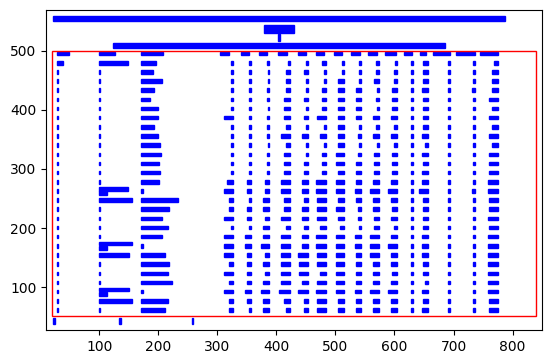

In [48]:
# Filepath
pdf_folder_path = 'data/PPPP'
filename = '2021_Q2.pdf'

# Read first table
table0 = camelot.read_pdf(
    os.path.join(pdf_folder_path,filename),
    pages='39',                        # Page for table
    flavor='stream',                   # stream preferred here, with lattice showing suboptimal performance for this pdf
    table_areas=['20,500,840,50']      # Area for table extraction
    )

camelot.plot(table0[0], kind='contour').show()
df_table0 = table0[0].df

# Squeeze first table and view output.
df_table0_new = squeeze(df_table0,1,3)
df_table0_new.head(10)

In [49]:
# Read all other tables
tables = camelot.read_pdf(
    os.path.join(pdf_folder_path,filename),
    pages='40-end',
    flavor='stream',
    table_areas=['20,550,840,50']
    )

# View first of subsequent tables
tables[0].df.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,,,CITY OF MUNTINLUPA,33,20,"1,226",445,144,"6,137",709,33,258,244,-,40,-,-,"9,289"
1,,,CITY OF PARAÑAQUE,32,25,703,315,111,"4,973",849,44,206,275,1,62,-,2,"7,598"
2,,,PASAY CITY,963,11,12,823,63,"2,992",345,11,340,163,-,170,-,-,"5,893"
3,,,PATEROS,5,3,201,10,15,981,96,2,74,23,-,-,-,-,"1,410"
4,,,TAGUIG CITY,"1,068",43,59,"1,757","3,905",550,540,17,184,188,-,41,-,-,"8,352"
5,,NCR FOURTH DISTRICT,,,,,,,,,,,,,,,,
6,,,,"2,149",121,"3,353","4,205","4,416","22,361","3,418",137,"1,621","1,176",1,461,-,2,"43,421"
7,,Total,,,,,,,,,,,,,,,,
8,NCR Total,,,"9,434",472,"7,092","32,549","33,691","90,329","26,654",844,"7,487","5,658",4,"2,500",2,3,"216,719"
9,CAR,ABRA,BANGUED (Capital),11,-,2,8,"1,263",56,91,1,20,-,2,-,1,-,"1,455"


The later tables lack headers (similar to the 2020 Q3 report). We process the data with this in mind.

In [50]:
# Squeeze each table and combine all into a list, accounting for no header scenario
all_dfs = [table.df for table in tables]
all_dfs = [squeeze(df,0,3) for df in all_dfs]
all_dfs = [df_table0_new] + all_dfs

num_col = all_dfs[0].shape[1]
for i,df in enumerate(all_dfs[1:]):
    if df.shape[1] < num_col:
        all_dfs[i+1] = pd.concat([pd.DataFrame('', index=df.index, columns=range(num_col-df.shape[1])),
                                  df],
                                 axis=1)
        all_dfs[i+1] = all_dfs[i+1].reset_index(drop=True)

# Set column names
for df in all_dfs:
    df.columns = all_dfs[0].iloc[0]
all_dfs[0] = all_dfs[0][1:].reset_index(drop=True)

# Make sure all tables have the same number of columns.
for i, df in enumerate(all_dfs):
    print(f'Table {i} has {len(df.columns)} columns')

Table 0 has 18 columns
Table 1 has 18 columns
Table 2 has 18 columns
Table 3 has 18 columns
Table 4 has 18 columns
Table 5 has 18 columns
Table 6 has 18 columns
Table 7 has 18 columns
Table 8 has 18 columns
Table 9 has 18 columns
Table 10 has 18 columns
Table 11 has 18 columns
Table 12 has 18 columns
Table 13 has 18 columns
Table 14 has 18 columns
Table 15 has 18 columns
Table 16 has 18 columns
Table 17 has 18 columns
Table 18 has 18 columns
Table 19 has 18 columns
Table 20 has 18 columns
Table 21 has 18 columns
Table 22 has 18 columns
Table 23 has 18 columns
Table 24 has 18 columns
Table 25 has 18 columns
Table 26 has 18 columns
Table 27 has 18 columns
Table 28 has 18 columns
Table 29 has 18 columns
Table 30 has 18 columns
Table 31 has 18 columns
Table 32 has 18 columns
Table 33 has 18 columns
Table 34 has 18 columns
Table 35 has 18 columns
Table 36 has 18 columns
Table 37 has 18 columns
Table 38 has 18 columns
Table 39 has 18 columns
Table 40 has 18 columns
Table 41 has 18 columns
Ta

No further cleanup required for this report.

In [51]:
df_2021_Q2 = pd.concat(all_dfs,axis=0).reset_index(drop=True)

In [52]:
# Split table by region
total_rows_region = get_total_locs(df_2021_Q2,col=0)         # Get row numbers corresponding to 'total' rows for REGION
region_dfs = split_tables(df_2021_Q2,total_rows_region)      # Split into one table per REGION

# Collect
region_totals = []
province_totals = []
municipals = []
for i, region_df_or in enumerate(region_dfs):
    # Get region totals
    region_df = region_df_or.copy()
    total_row, region_name = get_totals(region_df,col=0)
    region_totals.append(total_row)    

    # Split table by province
    region_df = region_df_or.copy()
    total_rows_province = get_total_locs(region_df,col=1)     # Get row numbers corresponding to 'total' rows for PROVINCE
    province_dfs = split_tables(region_df,total_rows_province)      # Split into one table per REGION

    for province_df_or in province_dfs:
        province_df = province_df_or.copy()
        total_row, province_name = get_totals(province_df,col=1)
        total_row.iloc[0] = region_name
        province_totals.append(total_row)

        municipal_df = clean_province_df(province_df)
        municipal_df.iloc[:,0] = region_name
        municipal_df.iloc[:,1] = province_name
        municipals.append(municipal_df)

In [53]:
df_region_totals = pd.DataFrame(region_totals)
df_region_totals = convert_to_numeric_df(df_region_totals)

df_province_totals = pd.DataFrame(province_totals)
df_province_totals = convert_to_numeric_df(df_province_totals)

df_municipals = pd.concat(municipals,axis=0)
df_municipals = convert_to_numeric_df(df_municipals)

print('Regional sums:')
display(df_region_totals.head())
print('\nProvincial sums:')
display(df_province_totals.head())
print('\nMunicipal records:')
display(df_municipals.head())

Regional sums:


,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,FNSP,HSF,IPsinGIDA,ItinerantIPs,GrandTotal
43,NCR,Total,Total,9434,472,7092,32549,33691,90329,26654,844,7487,5658,4,2500,2,3,216719
87,CAR,Total,Total,10225,30,1876,11495,22111,4075,4110,527,951,105,16,0,2190,0,57711
134,I,Total,Total,7987,1621,8146,13033,74892,58795,16743,1006,16130,3618,1,1,2297,0,204270
94,II,Total,Total,4632,35,8841,7560,51476,13476,4092,1360,5323,3856,1,1,5434,0,106087
141,III,Total,Total,6531,304,17274,11700,52541,153117,27491,1214,14643,10239,11,47,4072,0,299184



Provincial sums:


,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,FNSP,HSF,IPsinGIDA,ItinerantIPs,GrandTotal
16,NCR,NCR FIRST DISTRICT,Total,1761,38,56,9607,965,18933,7593,203,1336,1092,2,1366,0,1,42953
7,NCR,NCR SECOND DISTRICT,Total,2538,146,1859,7922,765,37550,8739,343,2148,1919,1,440,1,0,64371
6,NCR,NCR THIRD DISTRICT,Total,2986,167,1824,10815,27545,11485,6904,161,2382,1471,0,233,1,0,65974
10,NCR,NCR FOURTH DISTRICT,Total,2149,121,3353,4205,4416,22361,3418,137,1621,1176,1,461,0,2,43421
28,CAR,ABRA,Total,3688,2,7,2167,4023,274,1112,60,164,5,3,0,130,0,11635



Municipal records:


,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,FNSP,HSF,IPsinGIDA,ItinerantIPs,GrandTotal
0,NCR,NCR FIRST DISTRICT,BINONDO,1,0,1,0,0,30,2,0,1,0,0,35,0,0,70
1,NCR,NCR FIRST DISTRICT,ERMITA,0,1,0,48,13,1,7,0,2,4,0,70,0,0,146
2,NCR,NCR FIRST DISTRICT,INTRAMUROS,0,1,0,76,0,2,121,0,17,5,0,32,0,0,254
3,NCR,NCR FIRST DISTRICT,MALATE,4,0,2,85,5,17,635,24,0,41,0,114,0,1,928
4,NCR,NCR FIRST DISTRICT,PACO,1,1,3,575,74,55,229,12,1,81,0,28,0,0,1060


In [54]:
# Check if province sums up to region values. It does!
df_province_totals_temp = df_province_totals.copy()
df_province_totals_temp = df_province_totals_temp.groupby(df_province_totals.columns[0]).sum()
df_province_totals_temp.drop(columns=df_province_totals.columns[1:3],inplace=True)
df_province_totals_temp = df_province_totals_temp.sort_index()

df_region_totals_temp = df_region_totals.copy()
df_region_totals_temp = df_region_totals_temp.drop(columns=df_region_totals.columns[1:3])
df_region_totals_temp = df_region_totals_temp.set_index(df_region_totals.columns[0])
df_region_totals_temp = df_region_totals_temp.drop('Grand').sort_index()

df_province_totals_temp.equals(df_region_totals_temp)

True

In [55]:
# check if municipal sums up to province values. It does!
df_municipals_temp = df_municipals.copy()
df_municipals_temp = df_municipals_temp.groupby(list(df_municipals.columns[:2])).sum().drop(columns=df_municipals.columns[2])
df_municipals_temp = df_municipals_temp.reset_index().sort_values(list(df_municipals.columns[:2]))

df_province_totals_temp = df_province_totals.copy()
df_province_totals_temp = df_province_totals_temp.drop(columns=[df_province_totals.columns[2]])
df_province_totals_temp = df_province_totals_temp.sort_values(list(df_province_totals.columns[:2])).reset_index(drop=True)

df_municipals_temp.equals(df_province_totals_temp)

True

### 2021_Q3

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,FNSP,HSF,IPsGIDA,ItinerantIPs,GrandTotal
0,NCR,NCR FIRST DISTRICT,BINONDO,1,-,1,-,-,26,2,-,1,-,-,35,-,-,66
1,,,ERMITA,-,-,-,47,13,1,6,-,2,8,-,71,-,-,148
2,,,INTRAMUROS,-,1,-,71,-,3,116,-,17,16,-,33,-,-,257
3,,,MALATE,4,-,2,79,5,16,606,23,-,72,-,114,-,1,922
4,,,PACO,1,1,2,540,72,50,212,12,1,121,-,29,-,-,"1,041"
5,,,PANDACAN,2,-,-,312,9,17,432,25,-,58,-,25,-,-,880
6,,,PORT AREA,"1,167",7,7,211,20,"2,100",216,15,138,215,1,84,-,-,"4,181"
7,,,QUIAPO,-,2,2,17,6,3,346,-,10,7,-,27,-,-,420
8,,,SAMPALOC,7,4,7,"2,420",610,169,244,6,104,266,1,190,-,-,"4,028"


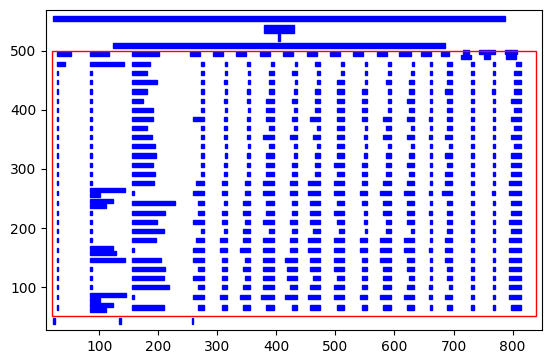

In [56]:
# Filepath
pdf_folder_path = 'data/PPPP'
filename = '2021_Q3.pdf'

# Read first table
table0 = camelot.read_pdf(
    os.path.join(pdf_folder_path,filename),
    pages='39',                        # Page for table
    flavor='stream',                   # stream preferred here, with lattice showing suboptimal performance for this pdf
    table_areas=['20,500,840,50']      # Area for table extraction
    )

camelot.plot(table0[0], kind='contour').show()
df_table0 = table0[0].df

# Squeeze first table and view output.
df_table0_new = squeeze(df_table0,3,3)
df_table0_new.head(10)

In [57]:
# Read all other tables
tables = camelot.read_pdf(
    os.path.join(pdf_folder_path,filename),
    pages='40-end',
    flavor='stream',
    table_areas=['20,550,840,50']
    )

# Check how many tables were extracted
print(f"Total tables extracted: {len(tables)}")

# Squeeze each table and combine all into a list
all_dfs = [table.df for table in tables]
all_dfs = [squeeze(df,3,3) for df in all_dfs]
all_dfs = [df_table0_new] + all_dfs

# Set column names
for df in all_dfs:
    df.columns = df.iloc[0]
all_dfs = [df[1:].reset_index(drop=True) for df in all_dfs]

# Make sure all tables have the same number of columns.
for i, df in enumerate(all_dfs):
    print(f'Table {i} has {len(df.columns)} columns')

Total tables extracted: 58
Table 0 has 18 columns
Table 1 has 18 columns
Table 2 has 18 columns
Table 3 has 17 columns
Table 4 has 18 columns
Table 5 has 18 columns
Table 6 has 18 columns
Table 7 has 18 columns
Table 8 has 18 columns
Table 9 has 18 columns
Table 10 has 18 columns
Table 11 has 18 columns
Table 12 has 18 columns
Table 13 has 18 columns
Table 14 has 18 columns
Table 15 has 18 columns
Table 16 has 18 columns
Table 17 has 18 columns
Table 18 has 18 columns
Table 19 has 18 columns
Table 20 has 18 columns
Table 21 has 18 columns
Table 22 has 18 columns
Table 23 has 18 columns
Table 24 has 18 columns
Table 25 has 17 columns
Table 26 has 18 columns
Table 27 has 18 columns
Table 28 has 18 columns
Table 29 has 18 columns
Table 30 has 18 columns
Table 31 has 18 columns
Table 32 has 18 columns
Table 33 has 18 columns
Table 34 has 18 columns
Table 35 has 18 columns
Table 36 has 18 columns
Table 37 has 18 columns
Table 38 has 18 columns
Table 39 has 18 columns
Table 40 has 18 columns

In [58]:
# Inspect tables with fewer columns than expected
small_tables = []
for i, df in enumerate(all_dfs):
    if len(df.columns) != 18:
        print(f'\n\n\nTable {i}')
        display(df.head())
        small_tables.append(i)




Table 3


,REGIONPROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,FNSP,HSF,IPsGIDA,ItinerantIPs,GrandTotal
0,,ALFONSO LISTA (POTIA),5,-,1,"1,172",44,9,56,7,16,-,-,-,-,-,"1,310"
1,,ASIPULO,1,-,343,391,26,49,23,7,15,1,-,-,133,-,989
2,,BANAUE,-,-,2,701,29,6,43,3,17,-,-,-,-,-,801
3,,HINGYON,1,-,1,6,298,16,22,-,16,1,-,-,-,-,361
4,,HUNGDUAN,-,-,-,254,7,5,116,3,6,-,-,-,-,-,391





Table 25


,REGIONPROVINCEMUNICIPALITY,SET1,,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,FNSP,HSF,IPsGIDA,ItinerantIPs,GrandTotal
0,CARAMOAN,,1,1,360,"2,785",70,251,130,67,245,130,-,-,-,-,"4,040"
1,DEL GALLEGO,,2,1,251,"1,002",13,95,27,4,83,63,-,-,-,-,"1,541"
2,GAINZA,,1,-,4,393,5,2,111,1,39,22,-,-,-,-,578
3,GARCHITORENA,,3,2,"1,839",25,70,114,54,1,140,86,-,-,-,-,"2,334"
4,GOA,,2,-,7,"2,678",172,122,402,295,160,82,-,-,16,-,"3,936"





Table 56


,REGIONPROVINCEMUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,FNSP,HSF,IPsGIDA,ItinerantIPs,GrandTotal
0,TUBARAN,-,"1,227",1,-,-,959,215,1,-,-,-,-,-,-,"2,403"
1,TUGAYA,-,-,104,840,4,2,511,20,-,-,-,-,-,-,"1,481"
2,WAO,-,1,3,"1,701",86,23,346,2,2,-,-,-,374,-,"2,538"
3,LANAO DEL SUR,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,,"1,998","2,599","17,527","35,442","10,585","7,687","11,596","1,691",81,"1,164",-,-,374,-,"90,744"





Table 57


,REGIONPROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,FNSP,HSF,IPsGIDA,ItinerantIPs,GrandTotal
0,,RAJAH BUAYAN,-,-,912,746,2,923,72,58,-,-,-,-,-,-,"2,713"
1,,SHARIFF AGUAK,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,,,-,1,"1,805","1,071",504,"2,871",237,88,1,-,-,-,-,-,"6,578"
3,,(MAGANOY) (Capital),,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,,SHARIFF SAYDONA,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Perform column splitting and related cleaning.

In [59]:
# Fix tables where REGION, PROVINCE and MUNICIPALITY columns may be merged, one way or another
for i in small_tables:
    if 'REGIONPROVINCE' in all_dfs[i].columns:
        all_dfs[i].rename(columns={'REGIONPROVINCE':'PROVINCE'}, inplace=True)
        all_dfs[i] = pd.concat([pd.DataFrame('', index=all_dfs[i].index, columns=['REGION']),
                                all_dfs[i]],
                                axis=1)
    elif 'PROVINCEMUNICIPALITY' in all_dfs[i].columns:
        all_dfs[i].rename(columns={'PROVINCEMUNICIPALITY':'MUNICIPALITY'}, inplace=True)
        all_dfs[i] = pd.concat([all_dfs[i].iloc[:,0],
                                pd.DataFrame('', index=all_dfs[i].index, columns=['PROVINCE']),
                                all_dfs[i].iloc[:,1:]],
                                axis=1)
    elif 'REGIONPROVINCEMUNICIPALITY' in all_dfs[i].columns:
        all_dfs[i].rename(columns={'REGIONPROVINCEMUNICIPALITY':'MUNICIPALITY'}, inplace=True)
        all_dfs[i] = pd.concat([pd.DataFrame('', index=all_dfs[i].index, columns=['REGION','PROVINCE']),
                            all_dfs[i]],
                            axis=1)
    else:
        raise Exception('Unknown column merge type')

In [60]:
# Fix table 25
all_dfs[25].loc[29:31,'PROVINCE'] = all_dfs[25].loc[29:31,'MUNICIPALITY']
all_dfs[25].loc[29:31,'MUNICIPALITY'] = ''
all_dfs[25].loc[32,'PROVINCE'] = 'CATANDUANES'
all_dfs[25].loc[32,'MUNICIPALITY'] = 'BAGAMANOC'
all_dfs[25].iloc[:,3] = all_dfs[25].iloc[:,4]
all_dfs[25].columns = ['REGION', 'PROVINCE', 'MUNICIPALITY', 'SET1', 'todrop', 'SET2', 'SET3',
                      'SET4', 'SET5', 'SET6', 'SET7', 'SET8', 'SET9', 'SET10', 'FNSP', 'HSF',
                      'IPsGIDA', 'ItinerantIPs', 'GrandTotal']
all_dfs[25].drop(columns=['todrop'],inplace=True)

# Fix table 56
all_dfs[56].loc[3:5,'PROVINCE'] = all_dfs[56].loc[3:5,'MUNICIPALITY']
all_dfs[56].loc[3:5,'MUNICIPALITY'] = ''
all_dfs[56].loc[6,'PROVINCE'] = 'MAGUINDANAO'
all_dfs[56].loc[6,'MUNICIPALITY'] = 'AMPATUAN'

... and back to the usual operations.

In [61]:
df_2021_Q3 = pd.concat(all_dfs,axis=0).reset_index(drop=True)

In [62]:
# Split table by region
total_rows_region = get_total_locs(df_2021_Q3,col=0)         # Get row numbers corresponding to 'total' rows for REGION
region_dfs = split_tables(df_2021_Q3,total_rows_region)      # Split into one table per REGION

# Collect
region_totals = []
province_totals = []
municipals = []
for i, region_df_or in enumerate(region_dfs):
    # Get region totals
    region_df = region_df_or.copy()
    total_row, region_name = get_totals(region_df,col=0)
    region_totals.append(total_row)    

    # Split table by province
    region_df = region_df_or.copy()
    total_rows_province = get_total_locs(region_df,col=1)     # Get row numbers corresponding to 'total' rows for PROVINCE
    province_dfs = split_tables(region_df,total_rows_province)      # Split into one table per REGION

    for province_df_or in province_dfs:
        province_df = province_df_or.copy()
        total_row, province_name = get_totals(province_df,col=1)
        total_row.iloc[0] = region_name
        province_totals.append(total_row)

        municipal_df = clean_province_df(province_df)
        municipal_df.iloc[:,0] = region_name
        municipal_df.iloc[:,1] = province_name
        municipals.append(municipal_df)

In [63]:
df_region_totals = pd.DataFrame(region_totals)
df_region_totals = convert_to_numeric_df(df_region_totals)

df_province_totals = pd.DataFrame(province_totals)
df_province_totals = convert_to_numeric_df(df_province_totals)

df_municipals = pd.concat(municipals,axis=0)
df_municipals = convert_to_numeric_df(df_municipals)

print('Regional sums:')
display(df_region_totals.head())
print('\nProvincial sums:')
display(df_province_totals.head())
print('\nMunicipal records:')
display(df_municipals.head())

Regional sums:


,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,FNSP,HSF,IPsGIDA,ItinerantIPs,GrandTotal
46,NCR,Total,Total,8680,444,6556,30362,31825,85522,25600,805,7445,6987,5,2493,2,3,206729
87,CAR,Total,Total,9508,28,1741,10868,20898,3860,4014,510,947,107,15,0,2173,0,54669
133,I,Total,Total,7512,1520,7717,12352,70955,55826,16405,968,16053,3615,1,1,2272,0,195197
97,II,Total,Total,4366,36,8433,7203,49260,12899,4004,1317,5333,3864,1,1,5397,0,102114
145,III,Total,Total,6092,295,16451,11147,50086,146369,26979,1178,14595,10427,11,48,4063,0,287741



Provincial sums:


,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,FNSP,HSF,IPsGIDA,ItinerantIPs,GrandTotal
16,NCR,NCR FIRST DISTRICT,Total,1695,37,53,9071,922,18065,7264,195,1337,1841,2,1363,0,1,41846
9,NCR,NCR SECOND DISTRICT,Total,2272,136,1693,7360,714,35302,8391,325,2120,2410,1,438,1,0,61163
6,NCR,NCR THIRD DISTRICT,Total,2742,156,1684,10030,25995,10964,6654,155,2377,1492,1,232,1,0,62483
11,NCR,NCR FOURTH DISTRICT,Total,1971,115,3126,3901,4194,21191,3291,130,1611,1244,1,460,0,2,41237
27,CAR,ABRA,Total,3391,1,7,2046,3819,263,1089,56,164,5,2,0,130,0,10973



Municipal records:


,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,FNSP,HSF,IPsGIDA,ItinerantIPs,GrandTotal
0,NCR,NCR FIRST DISTRICT,BINONDO,1,0,1,0,0,26,2,0,1,0,0,35,0,0,66
1,NCR,NCR FIRST DISTRICT,ERMITA,0,0,0,47,13,1,6,0,2,8,0,71,0,0,148
2,NCR,NCR FIRST DISTRICT,INTRAMUROS,0,1,0,71,0,3,116,0,17,16,0,33,0,0,257
3,NCR,NCR FIRST DISTRICT,MALATE,4,0,2,79,5,16,606,23,0,72,0,114,0,1,922
4,NCR,NCR FIRST DISTRICT,PACO,1,1,2,540,72,50,212,12,1,121,0,29,0,0,1041


In [64]:
# Check if province sums up to region values. It does!
df_province_totals_temp = df_province_totals.copy()
df_province_totals_temp = df_province_totals_temp.groupby(df_province_totals.columns[0]).sum()
df_province_totals_temp.drop(columns=df_province_totals.columns[1:3],inplace=True)
df_province_totals_temp = df_province_totals_temp.sort_index()

df_region_totals_temp = df_region_totals.copy()
df_region_totals_temp = df_region_totals_temp.drop(columns=df_region_totals.columns[1:3])
df_region_totals_temp = df_region_totals_temp.set_index(df_region_totals.columns[0])
df_region_totals_temp = df_region_totals_temp.drop('Grand').sort_index()

df_province_totals_temp.equals(df_region_totals_temp)

True

In [65]:
# check if municipal sums up to province values. It does!
df_municipals_temp = df_municipals.copy()
df_municipals_temp = df_municipals_temp.groupby(list(df_municipals.columns[:2])).sum().drop(columns=df_municipals.columns[2])
df_municipals_temp = df_municipals_temp.reset_index().sort_values(list(df_municipals.columns[:2]))

df_province_totals_temp = df_province_totals.copy()
df_province_totals_temp = df_province_totals_temp.drop(columns=[df_province_totals.columns[2]])
df_province_totals_temp = df_province_totals_temp.sort_values(list(df_province_totals.columns[:2])).reset_index(drop=True)

df_municipals_temp.equals(df_province_totals_temp)

True

### 2021_Q4

Note a small change to `table_area` for this report compared to earlier ones.

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,FNSP,HSF,IPsGIDA,ItinerantIPs,GrandTotal
0,NCR,NCR FIRST DISTRICT,BINONDO,1,-,1,-,-,26,2,-,1,2,-,36,-,-,69
1,,,ERMITA,-,-,-,47,13,2,5,-,2,8,-,72,-,-,149
2,,,INTRAMUROS,-,1,-,76,-,3,117,-,17,16,-,33,-,-,263
3,,,MALATE,4,-,2,80,5,16,605,23,1,71,-,113,-,1,921
4,,,PACO,1,1,2,538,72,50,210,12,2,119,-,28,1,-,"1,036"
5,,,PANDACAN,2,-,-,317,9,17,437,25,-,59,-,28,-,-,894
6,,,PORT AREA,"1,168",7,7,211,21,"2,100",215,15,139,216,-,84,-,-,"4,183"
7,,,QUIAPO,-,2,2,17,6,4,350,-,10,7,-,28,-,-,426
8,,,SAMPALOC,7,4,7,"2,422",611,170,246,6,107,278,1,189,-,-,"4,048"


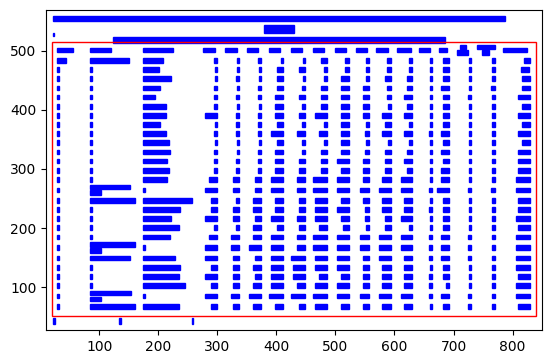

In [66]:
# Filepath
pdf_folder_path = 'data/PPPP'
filename = '2021_Q4.pdf'

# Read first table
table0 = camelot.read_pdf(
    os.path.join(pdf_folder_path,filename),
    pages='40',                        # Page for table
    flavor='stream',                   # stream preferred here, with lattice showing suboptimal performance for this pdf
    table_areas=['20,515,840,50']      # small change compared to other reports' first table
    )

camelot.plot(table0[0], kind='contour').show()
df_table0 = table0[0].df

# Squeeze first table and view output.
df_table0_new = squeeze(df_table0,3,3)
df_table0_new.head(10)

In [67]:
# Read all other tables
tables = camelot.read_pdf(
    os.path.join(pdf_folder_path,filename),
    pages='41-end',
    flavor='stream',
    table_areas=['20,550,840,50']
    )

# Check how many tables were extracted
print(f"Total tables extracted: {len(tables)}")

# Squeeze each table and combine all into a list
all_dfs = [table.df for table in tables]
all_dfs = [squeeze(df,3,3) for df in all_dfs]
all_dfs = [df_table0_new] + all_dfs

# Set column names
for df in all_dfs:
    df.columns = df.iloc[0]
all_dfs = [df[1:].reset_index(drop=True) for df in all_dfs]

# Make sure all tables have the same number of columns.
for i, df in enumerate(all_dfs):
    print(f'Table {i} has {len(df.columns)} columns')

Total tables extracted: 59
Table 0 has 18 columns
Table 1 has 18 columns
Table 2 has 18 columns
Table 3 has 18 columns
Table 4 has 18 columns
Table 5 has 18 columns
Table 6 has 18 columns
Table 7 has 18 columns
Table 8 has 18 columns
Table 9 has 18 columns
Table 10 has 18 columns
Table 11 has 18 columns
Table 12 has 18 columns
Table 13 has 18 columns
Table 14 has 18 columns
Table 15 has 18 columns
Table 16 has 18 columns
Table 17 has 18 columns
Table 18 has 18 columns
Table 19 has 18 columns
Table 20 has 18 columns
Table 21 has 18 columns
Table 22 has 18 columns
Table 23 has 18 columns
Table 24 has 18 columns
Table 25 has 18 columns
Table 26 has 18 columns
Table 27 has 18 columns
Table 28 has 18 columns
Table 29 has 18 columns
Table 30 has 18 columns
Table 31 has 18 columns
Table 32 has 18 columns
Table 33 has 18 columns
Table 34 has 18 columns
Table 35 has 18 columns
Table 36 has 18 columns
Table 37 has 18 columns
Table 38 has 18 columns
Table 39 has 18 columns
Table 40 has 18 columns

Clean report with no clean ups to do.

In [68]:
df_2021_Q4 = pd.concat(all_dfs,axis=0).reset_index(drop=True)

In [69]:
# Split table by region
total_rows_region = get_total_locs(df_2021_Q4,col=0)         # Get row numbers corresponding to 'total' rows for REGION
region_dfs = split_tables(df_2021_Q4,total_rows_region)      # Split into one table per REGION

# Collect
region_totals = []
province_totals = []
municipals = []
for i, region_df_or in enumerate(region_dfs):
    # Get region totals
    region_df = region_df_or.copy()
    total_row, region_name = get_totals(region_df,col=0)
    region_totals.append(total_row)    

    # Split table by province
    region_df = region_df_or.copy()
    total_rows_province = get_total_locs(region_df,col=1)     # Get row numbers corresponding to 'total' rows for PROVINCE
    province_dfs = split_tables(region_df,total_rows_province)      # Split into one table per REGION

    for province_df_or in province_dfs:
        province_df = province_df_or.copy()
        total_row, province_name = get_totals(province_df,col=1)
        total_row.iloc[0] = region_name
        province_totals.append(total_row)

        municipal_df = clean_province_df(province_df)
        municipal_df.iloc[:,0] = region_name
        municipal_df.iloc[:,1] = province_name
        municipals.append(municipal_df)

In [70]:
df_region_totals = pd.DataFrame(region_totals)
df_region_totals = convert_to_numeric_df(df_region_totals)

df_province_totals = pd.DataFrame(province_totals)
df_province_totals = convert_to_numeric_df(df_province_totals)

df_municipals = pd.concat(municipals,axis=0)
df_municipals = convert_to_numeric_df(df_municipals)

print('Regional sums:')
display(df_region_totals.head())
print('\nProvincial sums:')
display(df_province_totals.head())
print('\nMunicipal records:')
display(df_municipals.head())

Regional sums:


,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,FNSP,HSF,IPsGIDA,ItinerantIPs,GrandTotal
42,NCR,Total,Total,8703,447,6569,30433,31784,85533,25578,805,7513,8709,7,2514,5,3,208603
85,CAR,Total,Total,9632,27,1769,10978,21073,3884,4011,511,949,115,16,0,2171,0,55136
133,I,Total,Total,7622,1522,7714,12460,71424,56223,16448,969,16072,3622,1,2,2242,0,196321
95,II,Total,Total,4378,34,8474,7243,49600,12999,4013,1318,5343,3885,1,1,5419,0,102708
151,III,Total,Total,6179,295,16666,11269,50759,148192,27203,1183,14632,10782,11,48,4112,0,291331



Provincial sums:


,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,FNSP,HSF,IPsGIDA,ItinerantIPs,GrandTotal
16,NCR,NCR FIRST DISTRICT,Total,1693,37,55,9138,921,18132,7267,196,1355,2072,1,1373,1,1,42242
7,NCR,NCR SECOND DISTRICT,Total,2294,139,1716,7397,724,35374,8390,326,2142,3109,2,438,1,0,62052
6,NCR,NCR THIRD DISTRICT,Total,2747,159,1684,10006,25940,10959,6636,157,2389,1910,3,237,1,0,62828
9,NCR,NCR FOURTH DISTRICT,Total,1969,112,3114,3892,4199,21068,3285,126,1627,1618,1,466,2,2,41481
27,CAR,ABRA,Total,3449,1,7,2079,3838,263,1090,57,164,5,2,0,129,0,11084



Municipal records:


,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,FNSP,HSF,IPsGIDA,ItinerantIPs,GrandTotal
0,NCR,NCR FIRST DISTRICT,BINONDO,1,0,1,0,0,26,2,0,1,2,0,36,0,0,69
1,NCR,NCR FIRST DISTRICT,ERMITA,0,0,0,47,13,2,5,0,2,8,0,72,0,0,149
2,NCR,NCR FIRST DISTRICT,INTRAMUROS,0,1,0,76,0,3,117,0,17,16,0,33,0,0,263
3,NCR,NCR FIRST DISTRICT,MALATE,4,0,2,80,5,16,605,23,1,71,0,113,0,1,921
4,NCR,NCR FIRST DISTRICT,PACO,1,1,2,538,72,50,210,12,2,119,0,28,1,0,1036


In [71]:
# Check if province sums up to region values. It does!
df_province_totals_temp = df_province_totals.copy()
df_province_totals_temp = df_province_totals_temp.groupby(df_province_totals.columns[0]).sum()
df_province_totals_temp.drop(columns=df_province_totals.columns[1:3],inplace=True)
df_province_totals_temp = df_province_totals_temp.sort_index()

df_region_totals_temp = df_region_totals.copy()
df_region_totals_temp = df_region_totals_temp.drop(columns=df_region_totals.columns[1:3])
df_region_totals_temp = df_region_totals_temp.set_index(df_region_totals.columns[0])
df_region_totals_temp = df_region_totals_temp.drop('Grand').sort_index()

df_province_totals_temp.equals(df_region_totals_temp)

True

In [72]:
# check if municipal sums up to province values. It does!
df_municipals_temp = df_municipals.copy()
df_municipals_temp = df_municipals_temp.groupby(list(df_municipals.columns[:2])).sum().drop(columns=df_municipals.columns[2])
df_municipals_temp = df_municipals_temp.reset_index().sort_values(list(df_municipals.columns[:2]))

df_province_totals_temp = df_province_totals.copy()
df_province_totals_temp = df_province_totals_temp.drop(columns=[df_province_totals.columns[2]])
df_province_totals_temp = df_province_totals_temp.sort_values(list(df_province_totals.columns[:2])).reset_index(drop=True)

df_municipals_temp.equals(df_province_totals_temp)

True

### 2022_Q1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,SET11,SET7M,FNSP,HSF,IPsinGIDA,ItinerantIPs,GrandTotal
0,,NCR FIRST,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NCR,,BINONDO,1,-,1,-,-,27,2,-,1,2,1,-,-,36,-,-,71
2,,DISTRICT,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,,,ERMITA,-,-,-,48,13,3,6,-,2,8,-,-,-,72,-,-,152
4,,,INTRAMUROS,-,1,-,75,-,3,117,-,17,16,1,-,-,34,-,-,264
5,,,MALATE,4,-,2,79,5,16,604,23,1,72,44,-,-,114,-,1,965
6,,,PACO,1,1,2,543,71,52,210,12,2,119,12,-,-,29,1,-,"1,055"
7,,,PANDACAN,2,-,-,321,9,17,444,25,-,59,17,-,-,27,-,-,921
8,,,PORT AREA,"1,162",7,7,210,21,"2,095",215,15,139,217,17,-,-,85,-,-,"4,190"


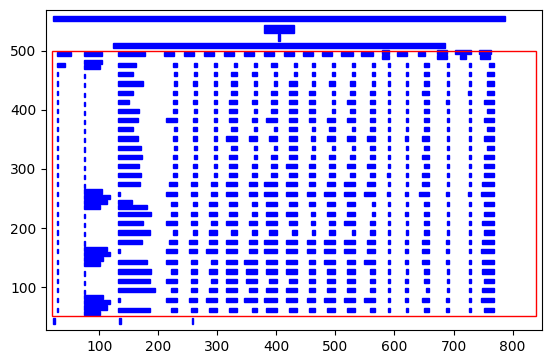

In [73]:
# Filepath
pdf_folder_path = 'data/PPPP'
filename = '2022_Q1.pdf'

# Read first table
table0 = camelot.read_pdf(
    os.path.join(pdf_folder_path,filename),
    pages='38',                        # Page for table
    flavor='stream',                   # stream preferred here, with lattice showing suboptimal performance for this pdf
    table_areas=['20,500,840,50']      # small change compared to other reports' first table
    )

camelot.plot(table0[0], kind='contour').show()
df_table0 = table0[0].df

# Squeeze first table and view output.
df_table0_new = squeeze(df_table0,3,3)
df_table0_new.head(10)

In [74]:
# Read all other tables
tables = camelot.read_pdf(
    os.path.join(pdf_folder_path,filename),
    pages='39-end',
    flavor='stream',
    table_areas=['20,550,840,50']
    )

# Check how many tables were extracted
print(f"Total tables extracted: {len(tables)}")

# Squeeze each table and combine all into a list
all_dfs = [table.df for table in tables]
all_dfs = [squeeze(df,3,3) for df in all_dfs]
all_dfs = [df_table0_new] + all_dfs

# Set column names
for df in all_dfs:
    df.columns = df.iloc[0]
all_dfs = [df[1:].reset_index(drop=True) for df in all_dfs]

# Make sure all tables have the same number of columns.
for i, df in enumerate(all_dfs):
    print(f'Table {i} has {len(df.columns)} columns')

Total tables extracted: 59
Table 0 has 20 columns
Table 1 has 20 columns
Table 2 has 20 columns
Table 3 has 20 columns
Table 4 has 20 columns
Table 5 has 20 columns
Table 6 has 20 columns
Table 7 has 20 columns
Table 8 has 20 columns
Table 9 has 20 columns
Table 10 has 20 columns
Table 11 has 20 columns
Table 12 has 20 columns
Table 13 has 20 columns
Table 14 has 20 columns
Table 15 has 20 columns
Table 16 has 20 columns
Table 17 has 20 columns
Table 18 has 20 columns
Table 19 has 20 columns
Table 20 has 20 columns
Table 21 has 20 columns
Table 22 has 20 columns
Table 23 has 20 columns
Table 24 has 20 columns
Table 25 has 20 columns
Table 26 has 20 columns
Table 27 has 20 columns
Table 28 has 20 columns
Table 29 has 20 columns
Table 30 has 20 columns
Table 31 has 20 columns
Table 32 has 20 columns
Table 33 has 20 columns
Table 34 has 20 columns
Table 35 has 20 columns
Table 36 has 20 columns
Table 37 has 20 columns
Table 38 has 20 columns
Table 39 has 20 columns
Table 40 has 20 columns

Clean tables with nothing to clean.

In [75]:
df_2022_Q1 = pd.concat(all_dfs,axis=0).reset_index(drop=True)

In [76]:
# Split table by region
total_rows_region = get_total_locs(df_2022_Q1,col=0)         # Get row numbers corresponding to 'total' rows for REGION
region_dfs = split_tables(df_2022_Q1,total_rows_region)      # Split into one table per REGION

# Collect
region_totals = []
province_totals = []
municipals = []
for i, region_df_or in enumerate(region_dfs):
    # Get region totals
    region_df = region_df_or.copy()
    total_row, region_name = get_totals(region_df,col=0)
    region_totals.append(total_row)    

    # Split table by province
    region_df = region_df_or.copy()
    total_rows_province = get_total_locs(region_df,col=1)     # Get row numbers corresponding to 'total' rows for PROVINCE
    province_dfs = split_tables(region_df,total_rows_province)      # Split into one table per REGION

    for province_df_or in province_dfs:
        province_df = province_df_or.copy()
        total_row, province_name = get_totals(province_df,col=1)
        total_row.iloc[0] = region_name
        province_totals.append(total_row)

        municipal_df = clean_province_df(province_df)
        municipal_df.iloc[:,0] = region_name
        municipal_df.iloc[:,1] = province_name
        municipals.append(municipal_df)

In [77]:
df_region_totals = pd.DataFrame(region_totals)
df_region_totals = convert_to_numeric_df(df_region_totals)

df_province_totals = pd.DataFrame(province_totals)
df_province_totals = convert_to_numeric_df(df_province_totals)

df_municipals = pd.concat(municipals,axis=0)
df_municipals = convert_to_numeric_df(df_municipals)

print('Regional sums:')
display(df_region_totals.head())
print('\nProvincial sums:')
display(df_province_totals.head())
print('\nMunicipal records:')
display(df_municipals.head())

Regional sums:


,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,SET11,SET7M,FNSP,HSF,IPsinGIDA,ItinerantIPs,GrandTotal
52,NCR,Total,Total,8671,448,6559,30368,31750,85125,25506,799,7523,8727,4047,1,8,2553,5,3,212093
98,CAR,Total,Total,9679,27,1772,10990,21091,3884,4008,511,952,118,1119,10,16,0,2161,0,56338
145,I,Total,Total,7705,1554,7763,12513,71779,56421,16448,970,16073,3627,11668,32,1,2,2209,0,208765
106,II,Total,Total,4411,34,8580,7312,49925,13083,4014,1325,5362,3892,4244,51,1,1,5372,0,107607
172,III,Total,Total,6195,295,16749,11317,50984,149029,27289,1183,14657,10786,9791,8,12,48,4116,0,302459



Provincial sums:


,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,SET11,SET7M,FNSP,HSF,IPsinGIDA,ItinerantIPs,GrandTotal
18,NCR,NCR FIRST DISTRICT,Total,1682,38,55,9118,923,18014,7257,194,1356,2073,1022,1,1,1396,1,1,43132
9,NCR,NCR SECOND DISTRICT,Total,2279,138,1705,7378,711,35232,8375,321,2145,3116,456,0,3,445,1,0,62305
8,NCR,NCR THIRD DISTRICT,Total,2737,160,1690,9986,25917,10908,6605,156,2394,1917,1515,0,3,238,1,0,64227
13,NCR,NCR FOURTH DISTRICT,Total,1973,112,3109,3886,4199,20971,3269,128,1628,1621,1054,0,1,474,2,2,42429
30,CAR,ABRA,Total,3486,1,7,2088,3861,265,1093,57,164,5,46,0,2,0,127,0,11202



Municipal records:


,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,SET11,SET7M,FNSP,HSF,IPsinGIDA,ItinerantIPs,GrandTotal
1,NCR,NCR FIRST DISTRICT,BINONDO,1,0,1,0,0,27,2,0,1,2,1,0,0,36,0,0,71
3,NCR,NCR FIRST DISTRICT,ERMITA,0,0,0,48,13,3,6,0,2,8,0,0,0,72,0,0,152
4,NCR,NCR FIRST DISTRICT,INTRAMUROS,0,1,0,75,0,3,117,0,17,16,1,0,0,34,0,0,264
5,NCR,NCR FIRST DISTRICT,MALATE,4,0,2,79,5,16,604,23,1,72,44,0,0,114,0,1,965
6,NCR,NCR FIRST DISTRICT,PACO,1,1,2,543,71,52,210,12,2,119,12,0,0,29,1,0,1055


In [78]:
# Check if province sums up to region values. It does!
df_province_totals_temp = df_province_totals.copy()
df_province_totals_temp = df_province_totals_temp.groupby(df_province_totals.columns[0]).sum()
df_province_totals_temp.drop(columns=df_province_totals.columns[1:3],inplace=True)
df_province_totals_temp = df_province_totals_temp.sort_index()

df_region_totals_temp = df_region_totals.copy()
df_region_totals_temp = df_region_totals_temp.drop(columns=df_region_totals.columns[1:3])
df_region_totals_temp = df_region_totals_temp.set_index(df_region_totals.columns[0])
df_region_totals_temp = df_region_totals_temp.drop('Grand').sort_index()

df_province_totals_temp.equals(df_region_totals_temp)

True

In [79]:
# check if municipal sums up to province values. It does!
df_municipals_temp = df_municipals.copy()
df_municipals_temp = df_municipals_temp.groupby(list(df_municipals.columns[:2])).sum().drop(columns=df_municipals.columns[2])
df_municipals_temp = df_municipals_temp.reset_index().sort_values(list(df_municipals.columns[:2]))

df_province_totals_temp = df_province_totals.copy()
df_province_totals_temp = df_province_totals_temp.drop(columns=[df_province_totals.columns[2]])
df_province_totals_temp = df_province_totals_temp.sort_values(list(df_province_totals.columns[:2])).reset_index(drop=True)

df_municipals_temp.equals(df_province_totals_temp)

True

### 2022_Q2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,SET11,7M,FNSP,HSF,IPsGIDA,ItinerantIPs,GrandTotal
0,,NCR FIRST,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NCR,,BINONDO,1,-,1,-,-,28,2,-,1,2,22,-,-,-,-,35,92
2,,DISTRICT,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,,,ERMITA,-,-,-,48,13,3,6,-,2,8,6,-,-,-,-,76,162
4,,,INTRAMUROS,-,1,-,77,-,3,118,-,17,16,9,-,-,-,-,34,275
5,,,MALATE,4,-,2,80,6,16,605,23,1,72,222,-,-,-,1,115,"1,147"
6,,,PACO,1,1,2,539,71,51,209,12,2,118,91,-,-,1,-,29,"1,127"
7,,,PANDACAN,2,-,-,321,10,17,442,25,-,59,240,-,-,-,-,27,"1,143"
8,,,PORT AREA,"1,162",7,7,212,21,"2,102",215,15,140,217,124,-,-,-,-,84,"4,306"


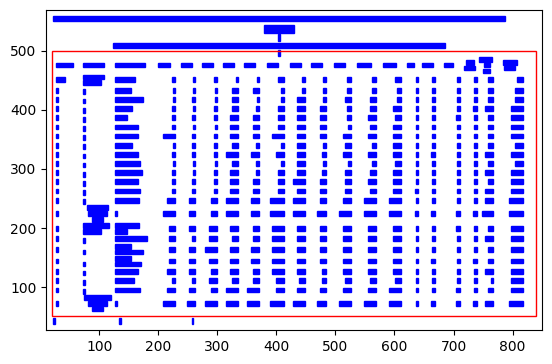

In [80]:
# Filepath
pdf_folder_path = 'data/PPPP'
filename = '2022_Q2.pdf'

# Read first table
table0 = camelot.read_pdf(
    os.path.join(pdf_folder_path,filename),
    pages='38',                        # Page for table
    flavor='stream',                   # stream preferred here, with lattice showing suboptimal performance for this pdf
    table_areas=['20,500,840,50']      # small change compared to other reports' first table
    )

camelot.plot(table0[0], kind='contour').show()
df_table0 = table0[0].df

# Squeeze first table and view output.
df_table0_new = squeeze(df_table0,5,3)
df_table0_new.head(10)

In [81]:
# Read all other tables
tables = camelot.read_pdf(
    os.path.join(pdf_folder_path,filename),
    pages='39-end',
    flavor='stream',
    table_areas=['20,550,840,50']
    )

# Check how many tables were extracted
print(f"Total tables extracted: {len(tables)}")

# Squeeze each table and combine all into a list
all_dfs = [table.df for table in tables]
all_dfs = [squeeze(df,5,3) for df in all_dfs]
all_dfs = [df_table0_new] + all_dfs

# Set column names
for df in all_dfs:
    df.columns = df.iloc[0]
all_dfs = [df[1:].reset_index(drop=True) for df in all_dfs]

# Make sure all tables have the same number of columns.
for i, df in enumerate(all_dfs):
    print(f'Table {i} has {len(df.columns)} columns')

Total tables extracted: 64
Table 0 has 20 columns
Table 1 has 20 columns
Table 2 has 20 columns
Table 3 has 20 columns
Table 4 has 20 columns
Table 5 has 20 columns
Table 6 has 20 columns
Table 7 has 20 columns
Table 8 has 20 columns
Table 9 has 20 columns
Table 10 has 20 columns
Table 11 has 20 columns
Table 12 has 20 columns
Table 13 has 20 columns
Table 14 has 20 columns
Table 15 has 20 columns
Table 16 has 20 columns
Table 17 has 20 columns
Table 18 has 20 columns
Table 19 has 20 columns
Table 20 has 20 columns
Table 21 has 20 columns
Table 22 has 20 columns
Table 23 has 20 columns
Table 24 has 20 columns
Table 25 has 20 columns
Table 26 has 20 columns
Table 27 has 20 columns
Table 28 has 20 columns
Table 29 has 20 columns
Table 30 has 20 columns
Table 31 has 20 columns
Table 32 has 20 columns
Table 33 has 20 columns
Table 34 has 20 columns
Table 35 has 20 columns
Table 36 has 20 columns
Table 37 has 20 columns
Table 38 has 20 columns
Table 39 has 20 columns
Table 40 has 20 columns

In [82]:
df_2022_Q2 = pd.concat(all_dfs,axis=0).reset_index(drop=True)

Minor clean up.

In [83]:
# Fix for row 2431
df_2022_Q2.loc[2431,'GrandTotal'] = df_2022_Q2.loc[2431,'ItinerantIPs']
df_2022_Q2.loc[2431,'ItinerantIPs'] = df_2022_Q2.loc[2431,'IPsGIDA']
df_2022_Q2.loc[2431,'IPsGIDA'] = '-'

In [84]:
# Split table by region
total_rows_region = get_total_locs(df_2022_Q2,col=0)         # Get row numbers corresponding to 'total' rows for REGION
region_dfs = split_tables(df_2022_Q2,total_rows_region)      # Split into one table per REGION

# Collect
region_totals = []
province_totals = []
municipals = []
for i, region_df_or in enumerate(region_dfs):
    # Get region totals
    region_df = region_df_or.copy()
    total_row, region_name = get_totals(region_df,col=0)
    region_totals.append(total_row)    

    # Split table by province
    region_df = region_df_or.copy()
    total_rows_province = get_total_locs(region_df,col=1)     # Get row numbers corresponding to 'total' rows for PROVINCE
    province_dfs = split_tables(region_df,total_rows_province)      # Split into one table per REGION

    for province_df_or in province_dfs:
        province_df = province_df_or.copy()
        total_row, province_name = get_totals(province_df,col=1)
        total_row.iloc[0] = region_name
        province_totals.append(total_row)

        municipal_df = clean_province_df(province_df)
        municipal_df.iloc[:,0] = region_name
        municipal_df.iloc[:,1] = province_name
        municipals.append(municipal_df)

In [85]:
df_region_totals = pd.DataFrame(region_totals)
df_region_totals = convert_to_numeric_df(df_region_totals)

df_province_totals = pd.DataFrame(province_totals)
df_province_totals = convert_to_numeric_df(df_province_totals)

df_municipals = pd.concat(municipals,axis=0)
df_municipals = convert_to_numeric_df(df_municipals)

print('Regional sums:')
display(df_region_totals.head())
print('\nProvincial sums:')
display(df_province_totals.head())
print('\nMunicipal records:')
display(df_municipals.head())

Regional sums:


,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,SET11,7M,FNSP,HSF,IPsGIDA,ItinerantIPs,GrandTotal
64,NCR,Total,Total,8644,450,6556,30252,31688,84744,25407,789,7528,8726,13487,1,8,8,3,2538,220829
108,CAR,Total,Total,9679,27,1779,10974,21051,3880,3983,513,955,120,5970,9,15,2155,0,0,61110
166,I,Total,Total,7710,1554,7729,12511,71774,56368,16420,965,16051,3628,12382,32,1,2186,0,2,209313
118,II,Total,Total,4411,34,8574,7319,49841,13052,4007,1316,5355,3889,6041,51,1,5326,0,1,109218
184,III,Total,Total,6200,296,16784,11366,51093,149327,27282,1179,14658,10802,15192,8,15,4128,0,52,308382



Provincial sums:


,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,SET11,7M,FNSP,HSF,IPsGIDA,ItinerantIPs,GrandTotal
18,NCR,NCR FIRST DISTRICT,Total,1678,38,57,9053,924,17874,7230,191,1353,2071,4049,1,1,1,1,1396,45918
15,NCR,NCR FOURTH DISTRICT,Total,1969,111,3103,3881,4189,20844,3256,128,1633,1626,3305,0,1,2,2,470,44520
13,NCR,NCR SECOND DISTRICT,Total,2265,143,1706,7369,709,35198,8371,317,2149,3105,2184,0,3,4,0,441,63964
14,NCR,NCR THIRD DISTRICT,Total,2732,158,1690,9949,25866,10828,6550,153,2393,1924,3949,0,3,1,0,231,66427
31,CAR,ABRA,Total,3484,1,7,2083,3858,266,1086,57,163,6,1118,0,2,126,0,0,12257



Municipal records:


,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,SET11,7M,FNSP,HSF,IPsGIDA,ItinerantIPs,GrandTotal
1,NCR,NCR FIRST DISTRICT,BINONDO,1,0,1,0,0,28,2,0,1,2,22,0,0,0,0,35,92
3,NCR,NCR FIRST DISTRICT,ERMITA,0,0,0,48,13,3,6,0,2,8,6,0,0,0,0,76,162
4,NCR,NCR FIRST DISTRICT,INTRAMUROS,0,1,0,77,0,3,118,0,17,16,9,0,0,0,0,34,275
5,NCR,NCR FIRST DISTRICT,MALATE,4,0,2,80,6,16,605,23,1,72,222,0,0,0,1,115,1147
6,NCR,NCR FIRST DISTRICT,PACO,1,1,2,539,71,51,209,12,2,118,91,0,0,1,0,29,1127


In [86]:
# Check if province sums up to region values. It does!
df_province_totals_temp = df_province_totals.copy()
df_province_totals_temp = df_province_totals_temp.groupby(df_province_totals.columns[0]).sum()
df_province_totals_temp.drop(columns=df_province_totals.columns[1:3],inplace=True)
df_province_totals_temp = df_province_totals_temp.sort_index()

df_region_totals_temp = df_region_totals.copy()
df_region_totals_temp = df_region_totals_temp.drop(columns=df_region_totals.columns[1:3])
df_region_totals_temp = df_region_totals_temp.set_index(df_region_totals.columns[0])
df_region_totals_temp = df_region_totals_temp.drop('Grand').sort_index()

df_province_totals_temp.equals(df_region_totals_temp)

True

In [87]:
# check if municipal sums up to province values. It does!
df_municipals_temp = df_municipals.copy()
df_municipals_temp = df_municipals_temp.groupby(list(df_municipals.columns[:2])).sum().drop(columns=df_municipals.columns[2])
df_municipals_temp = df_municipals_temp.reset_index().sort_values(list(df_municipals.columns[:2]))

df_province_totals_temp = df_province_totals.copy()
df_province_totals_temp = df_province_totals_temp.drop(columns=[df_province_totals.columns[2]])
df_province_totals_temp = df_province_totals_temp.sort_values(list(df_province_totals.columns[:2])).reset_index(drop=True)

df_municipals_temp.equals(df_province_totals_temp)

True

### 2022_Q3

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,SET11,7M,FNSP,IPsinGIDA,ItinerantIPs,HSF,GrandTotal
0,NCR,NCR FIRST DISTRICT,BINONDO,1,-,1,-,-,28,2,-,1,2,20,-,-,-,-,35,90
1,,,ERMITA,-,-,-,48,13,3,6,-,2,8,7,-,-,-,-,69,156
2,,,INTRAMURO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,,,,-,1,-,77,-,3,117,-,17,15,8,-,-,-,-,33,271
4,,,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,,,MALATE,4,-,2,79,6,16,595,23,1,72,225,-,-,-,1,112,"1,136"
6,,,PACO,1,-,2,527,70,50,204,12,2,120,90,-,-,1,-,29,"1,108"
7,,,PANDACAN,2,-,-,314,9,17,438,25,-,58,241,-,-,-,-,26,"1,130"
8,,,PORT AREA,"1,137",6,7,206,20,"2,058",211,15,139,217,125,-,-,-,-,81,"4,222"


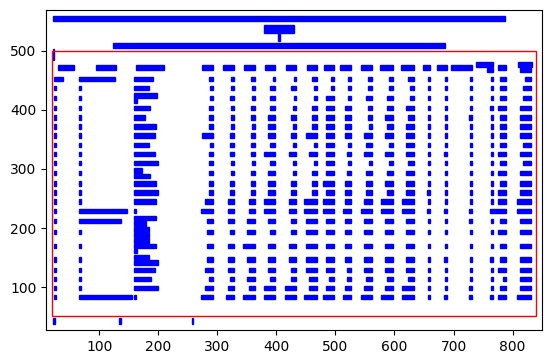

In [88]:
# Filepath
pdf_folder_path = 'data/PPPP'
filename = '2022_Q3.pdf'

# Read first table
table0 = camelot.read_pdf(
    os.path.join(pdf_folder_path,filename),
    pages='39',                        # Page for table
    flavor='stream',                   # stream preferred here, with lattice showing suboptimal performance for this pdf
    table_areas=['20,500,840,50']      # Area for table extraction
    )

camelot.plot(table0[0], kind='contour').show()
df_table0 = table0[0].df

# Squeeze first table and view output.
df_table0_new = squeeze(df_table0,3,3)
df_table0_new.head(10)

In [89]:
# Read all other tables
tables = camelot.read_pdf(
    os.path.join(pdf_folder_path,filename),
    pages='40-end',
    flavor='stream',
    table_areas=['20,550,840,50']
    )

# View first of subsequent tables
tables[0].df.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,,,CITY OF,,,,,,,,,,,,,,,,,
1,,NCR SECOND DISTRICT,MANDALUY,16,8,711,391,81,"5,210",581,30,405,157,183,-,-,1,-,29,"7,803"
2,,,ONG,,,,,,,,,,,,,,,,,
3,,,CITY OF,,,,,,,,,,,,,,,,,
4,,,,10,10,610,503,94,"4,269","1,064",2,350,105,133,-,1,-,-,12,"7,163"
5,,,MARIKINA,,,,,,,,,,,,,,,,,
6,,,CITY OF,,,,,,,,,,,,,,,,,
7,,,,"1,211",17,28,"1,302",107,"6,571",433,6,27,"1,016",395,-,-,1,-,26,"11,140"
8,,,PASIG,,,,,,,,,,,,,,,,,
9,,,CITY OF SAN,,,,,,,,,,,,,,,,,


The later tables lack headers (similar to the 2020 Q3 report). We process the data with this in mind.

In [90]:
# Squeeze each table and combine all into a list, accounting for no header scenario
all_dfs = [table.df for table in tables]
all_dfs = [squeeze(df,0,3) for df in all_dfs]
all_dfs = [df_table0_new] + all_dfs

num_col = all_dfs[0].shape[1]
for i,df in enumerate(all_dfs[1:]):
    if df.shape[1] < num_col:
        all_dfs[i+1] = pd.concat([pd.DataFrame('', index=df.index, columns=range(num_col-df.shape[1])),
                                  df],
                                 axis=1)
        all_dfs[i+1] = all_dfs[i+1].reset_index(drop=True)

# Set column names
for df in all_dfs:
    df.columns = all_dfs[0].iloc[0]
all_dfs[0] = all_dfs[0][1:].reset_index(drop=True)

# Make sure all tables have the same number of columns.
for i, df in enumerate(all_dfs):
    print(f'Table {i} has {len(df.columns)} columns')

Table 0 has 20 columns
Table 1 has 20 columns
Table 2 has 20 columns
Table 3 has 20 columns
Table 4 has 20 columns
Table 5 has 20 columns
Table 6 has 20 columns
Table 7 has 20 columns
Table 8 has 20 columns
Table 9 has 20 columns
Table 10 has 20 columns
Table 11 has 20 columns
Table 12 has 20 columns
Table 13 has 20 columns
Table 14 has 20 columns
Table 15 has 20 columns
Table 16 has 20 columns
Table 17 has 20 columns
Table 18 has 20 columns
Table 19 has 20 columns
Table 20 has 20 columns
Table 21 has 20 columns
Table 22 has 20 columns
Table 23 has 20 columns
Table 24 has 20 columns
Table 25 has 20 columns
Table 26 has 20 columns
Table 27 has 20 columns
Table 28 has 20 columns
Table 29 has 20 columns
Table 30 has 20 columns
Table 31 has 20 columns
Table 32 has 20 columns
Table 33 has 20 columns
Table 34 has 20 columns
Table 35 has 20 columns
Table 36 has 20 columns
Table 37 has 20 columns
Table 38 has 20 columns
Table 39 has 20 columns
Table 40 has 20 columns
Table 41 has 20 columns
Ta

Clean up.

In [91]:
# Manual fixing table 9
all_dfs[9].iloc[38:,1:] = all_dfs[9].iloc[38:,:-1]
all_dfs[9].iloc[37,1] = all_dfs[9].iloc[37,0]
all_dfs[9].iloc[:37,2] = all_dfs[9].iloc[:37,1]
all_dfs[9].iloc[:37,1] = ''
all_dfs[9].iloc[:,0] = ''

# Manual fixing table 41
all_dfs[41].iloc[:25,1:] = all_dfs[41].iloc[:25,:-1]
all_dfs[41].iloc[25:,2] = all_dfs[41].iloc[25:,1]
all_dfs[41].iloc[25:,1] = ''
all_dfs[41].iloc[:,0] = ''

# Manual fixing table 46
all_dfs[46].loc[20,'REGION'] = all_dfs[46].loc[20,'PROVINCE']
all_dfs[46].loc[20,'PROVINCE'] = ''
all_dfs[46].loc[19,'PROVINCE'] = all_dfs[46].loc[19,'MUNICIPALITY']
all_dfs[46].loc[19,'MUNICIPALITY'] = ''

# Manual fixing table 1
all_dfs[1].iloc[30,-1] = all_dfs[1].iloc[30,-2]
all_dfs[1].iloc[30,-2] = '2,474'
all_dfs[1].iloc[30,-3] = '3'

# Manual fixing table 0
all_dfs[0].iloc[18,-1] = all_dfs[0].iloc[18,-2]
all_dfs[0].iloc[18,-2] = '1,358'
all_dfs[0].iloc[18,-3] = '1'

# Manual fixing last table
all_dfs[-1].iloc[-1,-1] = all_dfs[-1].iloc[-1,-3]
all_dfs[-1].iloc[-1,-2] = '3,445'
all_dfs[-1].iloc[-1,-3] = '329'
all_dfs[-1].iloc[-1,10:17] = all_dfs[-1].iloc[-1,9:16]
all_dfs[-1].iloc[-1,8] = '727,809'
all_dfs[-1].iloc[-1,9] = '328,310'

In [92]:
df_2022_Q3 = pd.concat(all_dfs,axis=0).reset_index(drop=True)

In [93]:
# Split table by region
total_rows_region = get_total_locs(df_2022_Q3,col=0)         # Get row numbers corresponding to 'total' rows for REGION
region_dfs = split_tables(df_2022_Q3,total_rows_region)      # Split into one table per REGION

# Collect
region_totals = []
province_totals = []
municipals = []
for i, region_df_or in enumerate(region_dfs):
    # Get region totals
    region_df = region_df_or.copy()
    total_row, region_name = get_totals(region_df,col=0)
    region_totals.append(total_row)    

    # Split table by province
    region_df = region_df_or.copy()
    total_rows_province = get_total_locs(region_df,col=1)     # Get row numbers corresponding to 'total' rows for PROVINCE
    province_dfs = split_tables(region_df,total_rows_province)      # Split into one table per REGION

    for province_df_or in province_dfs:
        province_df = province_df_or.copy()
        total_row, province_name = get_totals(province_df,col=1)
        total_row.iloc[0] = region_name
        province_totals.append(total_row)

        municipal_df = clean_province_df(province_df)
        municipal_df.iloc[:,0] = region_name
        municipal_df.iloc[:,1] = province_name
        municipals.append(municipal_df)

In [94]:
df_region_totals = pd.DataFrame(region_totals)
df_region_totals = convert_to_numeric_df(df_region_totals)

df_province_totals = pd.DataFrame(province_totals)
df_province_totals = convert_to_numeric_df(df_province_totals)

df_municipals = pd.concat(municipals,axis=0)
df_municipals = convert_to_numeric_df(df_municipals)

print('Regional sums:')
display(df_region_totals.head())
print('\nProvincial sums:')
display(df_province_totals.head())
print('\nMunicipal records:')
display(df_municipals.head())

Regional sums:


,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,SET11,7M,FNSP,IPsinGIDA,ItinerantIPs,HSF,GrandTotal
65,NCR,Total,Total,8343,444,6437,29384,31167,82929,25046,780,7486,8681,13707,1,9,8,3,2474,216899
122,CAR,Total,Total,9322,28,1729,10683,20596,3819,3951,505,952,121,5934,9,15,2142,0,0,59806
209,I,Total,Total,7431,1545,7607,12304,70884,55676,16328,953,15986,3599,12319,32,1,2169,0,2,206836
152,II,Total,Total,4173,34,8299,7111,48512,12750,3927,1296,5325,3866,6049,50,1,5282,0,1,106676
222,III,Total,Total,6054,297,16337,11151,49955,146860,27043,1164,14592,10752,15225,8,15,4114,0,55,303622



Provincial sums:


,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,SET11,7M,FNSP,IPsinGIDA,ItinerantIPs,HSF,GrandTotal
18,NCR,NCR FIRST DISTRICT,Total,1644,36,55,8819,908,17506,7146,188,1343,2067,4112,1,1,1,1,1358,45186
15,NCR,NCR FOURTH DISTRICT,Total,1906,109,3062,3831,4131,20592,3231,130,1625,1626,3332,0,1,2,2,466,44046
16,NCR,NCR SECOND DISTRICT,Total,2130,142,1667,7031,698,34128,8185,312,2127,3071,2290,0,3,4,0,425,62213
12,NCR,NCR THIRD DISTRICT,Total,2663,157,1653,9703,25430,10703,6484,150,2391,1917,3973,0,4,1,0,225,65454
44,CAR,ABRA,Total,3325,2,7,2023,3766,262,1082,53,160,6,1116,0,2,123,0,0,11927



Municipal records:


,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,SET11,7M,FNSP,IPsinGIDA,ItinerantIPs,HSF,GrandTotal
0,NCR,NCR FIRST DISTRICT,BINONDO,1,0,1,0,0,28,2,0,1,2,20,0,0,0,0,35,90
1,NCR,NCR FIRST DISTRICT,ERMITA,0,0,0,48,13,3,6,0,2,8,7,0,0,0,0,69,156
2,NCR,NCR FIRST DISTRICT,INTRAMURO S,0,1,0,77,0,3,117,0,17,15,8,0,0,0,0,33,271
5,NCR,NCR FIRST DISTRICT,MALATE,4,0,2,79,6,16,595,23,1,72,225,0,0,0,1,112,1136
6,NCR,NCR FIRST DISTRICT,PACO,1,0,2,527,70,50,204,12,2,120,90,0,0,1,0,29,1108


In [95]:
# Check if province sums up to region values. It does!
df_province_totals_temp = df_province_totals.copy()
df_province_totals_temp = df_province_totals_temp.groupby(df_province_totals.columns[0]).sum()
df_province_totals_temp.drop(columns=df_province_totals.columns[1:3],inplace=True)
df_province_totals_temp = df_province_totals_temp.sort_index()

df_region_totals_temp = df_region_totals.copy()
df_region_totals_temp = df_region_totals_temp.drop(columns=df_region_totals.columns[1:3])
df_region_totals_temp = df_region_totals_temp.set_index(df_region_totals.columns[0])
df_region_totals_temp = df_region_totals_temp.drop('Grand').sort_index()

df_province_totals_temp.equals(df_region_totals_temp)

True

In [96]:
# check if municipal sums up to province values. It does!
df_municipals_temp = df_municipals.copy()
df_municipals_temp = df_municipals_temp.groupby(list(df_municipals.columns[:2])).sum().drop(columns=df_municipals.columns[2])
df_municipals_temp = df_municipals_temp.reset_index().sort_values(list(df_municipals.columns[:2]))

df_province_totals_temp = df_province_totals.copy()
df_province_totals_temp = df_province_totals_temp.drop(columns=[df_province_totals.columns[2]])
df_province_totals_temp = df_province_totals_temp.sort_values(list(df_province_totals.columns[:2])).reset_index(drop=True)

df_municipals_temp.equals(df_province_totals_temp)

True

### 2022_Q4

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,...,SET10,SET11,7M,8E,12M,FNSP,IPsinGIDA,ItinerantIPs,HSF,GrandTotal
0,NCR,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,NCR FIRST DISTRICT,BINONDO,1,-,1,-,-,26,2,...,2,19,-,-,-,29,-,-,-,81
2,,,ERMITA,-,-,-,47,13,3,5,...,9,8,-,-,2,65,-,-,-,154
3,,,INTRAMUROS,-,1,-,72,1,4,108,...,15,8,-,-,4,30,-,-,-,260
4,,,MALATE,3,-,1,59,5,14,495,...,73,244,-,-,1,111,1,-,-,"1,036"
5,,,PACO,1,-,2,402,56,39,168,...,119,92,-,-,1,27,-,1,-,918
6,,,PANDACAN,2,-,-,258,8,13,370,...,60,242,-,-,-,25,-,-,-,"1,003"
7,,,PORT AREA,928,5,6,180,18,"1,751",189,...,217,124,-,-,-,83,-,-,-,"3,656"
8,,,QUIAPO,-,2,2,18,7,4,324,...,7,139,-,-,2,29,-,-,-,544


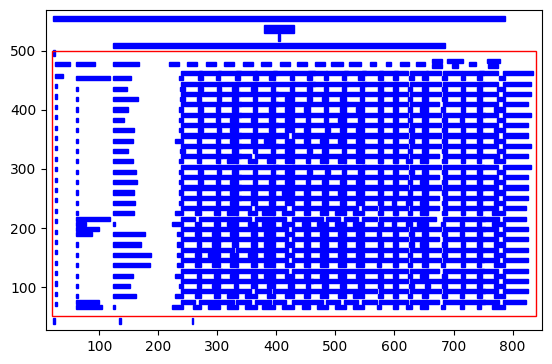

In [97]:
# Filepath
pdf_folder_path = 'data/PPPP'
filename = '2022_Q4.pdf'

# Read first table
table0 = camelot.read_pdf(
    os.path.join(pdf_folder_path,filename),
    pages='39',                        # Page for table
    flavor='stream',                   # stream preferred here, with lattice showing suboptimal performance for this pdf
    table_areas=['20,500,840,50']      # Area for table extraction
    )

camelot.plot(table0[0], kind='contour').show()
df_table0 = table0[0].df

# Squeeze first table and view output.
df_table0_new = squeeze(df_table0,3,3)
df_table0_new.head(10)

In [98]:
# Read all other tables
tables = camelot.read_pdf(
    os.path.join(pdf_folder_path,filename),
    pages='40-end',
    flavor='stream',
    table_areas=['20,550,840,50']
    )

# Check how many tables were extracted
print(f"Total tables extracted: {len(tables)}")

# Squeeze each table and combine all into a list
all_dfs = [table.df for table in tables]
all_dfs = [squeeze(df,3,3) for df in all_dfs]
all_dfs = [df_table0_new] + all_dfs

# Set column names
for df in all_dfs:
    df.columns = df.iloc[0]
all_dfs = [df[1:].reset_index(drop=True) for df in all_dfs]

# Make sure all tables have the same number of columns.
for i, df in enumerate(all_dfs):
    print(f'Table {i} has {len(df.columns)} columns')

Total tables extracted: 67
Table 0 has 22 columns
Table 1 has 22 columns
Table 2 has 22 columns
Table 3 has 22 columns
Table 4 has 22 columns
Table 5 has 22 columns
Table 6 has 22 columns
Table 7 has 22 columns
Table 8 has 22 columns
Table 9 has 22 columns
Table 10 has 22 columns
Table 11 has 22 columns
Table 12 has 22 columns
Table 13 has 22 columns
Table 14 has 22 columns
Table 15 has 22 columns
Table 16 has 22 columns
Table 17 has 22 columns
Table 18 has 22 columns
Table 19 has 22 columns
Table 20 has 22 columns
Table 21 has 21 columns
Table 22 has 22 columns
Table 23 has 22 columns
Table 24 has 22 columns
Table 25 has 22 columns
Table 26 has 22 columns
Table 27 has 22 columns
Table 28 has 22 columns
Table 29 has 22 columns
Table 30 has 21 columns
Table 31 has 22 columns
Table 32 has 22 columns
Table 33 has 22 columns
Table 34 has 22 columns
Table 35 has 22 columns
Table 36 has 22 columns
Table 37 has 22 columns
Table 38 has 22 columns
Table 39 has 22 columns
Table 40 has 22 columns

In [99]:
# Inspect tables with fewer columns than expected
small_tables = []
for i, df in enumerate(all_dfs):
    if len(df.columns) != 22:
        print(f'\n\n\nTable {i}')
        display(df.head())
        small_tables.append(i)




Table 21


,REGIONPROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,...,SET10,SET11,7M,8E,12M,FNSP,IPsinGIDA,ItinerantIPs,HSF,GrandTotal
0,,CAVINTI,-,-,104,1,7,144,17,-,...,44,4,-,-,-,-,-,-,-,364
1,,CITY OF CALAMBA,22,6,44,110,"1,112",129,170,29,...,211,799,-,-,-,-,-,1,1,"2,737"
2,,CITY OF SANTA ROSA,12,12,52,78,615,117,75,3,...,93,296,-,-,-,-,-,-,-,"1,426"
3,,FAMY,2,-,139,6,19,85,9,-,...,42,21,-,-,-,-,-,-,-,360
4,,KALAYAAN,-,-,2,2,2,187,14,-,...,72,95,-,-,-,-,-,-,-,405





Table 30


,REGIONPROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,...,SET10,SET11,7M,8E,12M,FNSP,IPsinGIDA,ItinerantIPs,HSF,GrandTotal
0,,BATO,-,-,6,705,42,28,32,1,...,19,96,-,-,-,-,-,1,-,996
1,,CARAMORAN,-,2,326,"1,431",31,28,48,2,...,51,202,-,-,-,-,-,-,-,"2,269"
2,,GIGMOTO,4,1,4,314,11,52,9,3,...,13,60,-,-,-,-,-,-,-,500
3,,PANDAN,3,-,333,793,2,22,17,16,...,14,125,-,-,-,-,-,-,-,"1,410"
4,,PANGANIBAN (PAYO),-,-,2,340,7,8,26,22,...,2,36,-,-,-,-,-,-,-,479





Table 43


,REGIONPROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,...,SET10,SET11,7M,8E,12M,FNSP,IPsinGIDA,ItinerantIPs,HSF,GrandTotal
0,,CAN-AVID,1,1,6,5,"1,014",104,121,-,...,29,126,-,-,-,-,-,-,2,"1,472"
1,,CITY OF BORONGAN (Capital),6,3,5,13,"2,084",143,176,-,...,56,326,1,-,-,-,-,-,4,"2,985"
2,,DOLORES,2,2,7,14,"2,160",151,265,2,...,69,393,-,-,-,-,-,-,-,"3,239"
3,,GENERAL MACARTHUR,1,1,328,433,19,64,69,1,...,11,53,1,-,-,-,-,-,-,"1,029"
4,,GIPORLOS,3,5,2,5,618,62,87,-,...,27,46,49,-,13,-,-,-,48,"1,017"





Table 45


,REGIONPROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,...,SET10,SET11,7M,8E,12M,FNSP,IPsinGIDA,ItinerantIPs,HSF,GrandTotal
0,,PALOMPON,4,-,5,32,"1,160",105,156,1,...,99,465,-,-,-,-,-,-,-,"2,149"
1,,PASTRANA,-,3,278,616,12,104,62,1,...,36,86,1,-,-,-,-,-,3,"1,334"
2,,SAN ISIDRO,3,2,342,913,55,79,218,-,...,52,113,-,-,1,-,-,-,-,"1,929"
3,,SAN MIGUEL,1,5,276,682,15,73,70,-,...,46,110,2,-,-,-,-,-,1,"1,370"
4,,SANTA FE,-,5,302,573,10,97,104,1,...,48,146,1,-,1,-,-,-,3,"1,371"





Table 46


,REGIONPROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,...,SET10,SET11,7M,8E,12M,FNSP,IPsinGIDA,ItinerantIPs,HSF,GrandTotal
0,,MONDRAGON,"1,542",5,1,10,12,20,100,115,...,93,397,-,-,-,-,-,-,-,"2,454"
1,,PALAPAG,"1,392",-,2,13,1,20,80,39,...,84,312,1,-,-,-,-,-,1,"2,113"
2,,PAMBUJAN,939,-,2,7,7,44,75,-,...,76,499,-,-,-,-,-,-,-,"1,764"
3,,ROSARIO,4,-,1,551,12,11,70,-,...,31,62,-,-,-,-,-,-,-,783
4,,SAN ANTONIO,-,2,2,6,368,15,25,-,...,14,43,-,-,-,-,-,-,-,507





Table 47


,REGIONPROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,...,SET10,SET11,7M,8E,12M,FNSP,IPsinGIDA,ItinerantIPs,HSF,GrandTotal
0,,PINABACDAO,1,416,3,9,3,521,86,1,...,49,90,-,-,-,-,-,-,-,"1,273"
1,,SAN JORGE,-,684,5,6,2,307,86,3,...,40,72,-,-,-,-,-,-,-,"1,306"
2,,SAN JOSE DE BUAN,3,398,4,2,2,159,39,-,...,22,79,-,-,-,-,-,-,-,730
3,,SAN SEBASTIAN,1,385,-,2,5,77,21,-,...,20,39,-,-,-,-,-,-,-,581
4,,SANTA MARGARITA,1,"1,118",-,6,1,280,85,-,...,35,96,-,-,-,-,-,-,-,"1,747"





Table 63


,REGIONPROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,...,SET10,SET11,7M,8E,12M,FNSP,IPsinGIDA,ItinerantIPs,HSF,GrandTotal
0,,PIKIT,4,1,328,"4,306",18,220,859,118,...,89,433,-,-,-,-,-,-,1,"6,522"
1,COTABATO (NORTH,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,COTABATO) Total,,4,4,546,"6,370","2,656",553,"1,258",610,...,108,929,-,-,-,-,-,-,1,"13,437"
3,COTABATO CITY,COTABATO CITY,1,3,876,"5,731",110,674,337,472,...,177,282,-,-,-,-,-,-,2,"9,190"
4,COTABATO CITY,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
# Fix tables where REGION, PROVINCE and MUNICIPALITY columns may be merged, one way or another
for i in small_tables:
    if 'REGIONPROVINCE' in all_dfs[i].columns:
        all_dfs[i].rename(columns={'REGIONPROVINCE':'PROVINCE'}, inplace=True)
        all_dfs[i] = pd.concat([pd.DataFrame('', index=all_dfs[i].index, columns=['REGION']),
                                all_dfs[i]],
                                axis=1)
    elif 'PROVINCEMUNICIPALITY' in all_dfs[i].columns:
        all_dfs[i].rename(columns={'PROVINCEMUNICIPALITY':'MUNICIPALITY'}, inplace=True)
        all_dfs[i] = pd.concat([all_dfs[i].iloc[:,0],
                                pd.DataFrame('', index=all_dfs[i].index, columns=['PROVINCE']),
                                all_dfs[i].iloc[:,1:]],
                                axis=1)
    elif 'REGIONPROVINCEMUNICIPALITY' in all_dfs[i].columns:
        all_dfs[i].rename(columns={'REGIONPROVINCEMUNICIPALITY':'MUNICIPALITY'}, inplace=True)
        all_dfs[i] = pd.concat([pd.DataFrame('', index=all_dfs[i].index, columns=['REGION','PROVINCE']),
                            all_dfs[i]],
                            axis=1)
    else:
        raise Exception('Unknown column merge type')

In [101]:
df_2022_Q4 = pd.concat(all_dfs,axis=0).reset_index(drop=True)

In [102]:
# Split table by region
total_rows_region = get_total_locs2(df_2022_Q4,col=0)         # Get row numbers corresponding to 'total' rows for REGION
region_dfs = split_tables(df_2022_Q4,total_rows_region)      # Split into one table per REGION

# Collect
region_totals = []
province_totals = []
municipals = []
for i, region_df_or in enumerate(region_dfs):
    # Get region totals
    region_df = region_df_or.copy()
    total_row, region_name = get_totals2(region_df,col=0)
    region_totals.append(total_row)    

    # Split table by province
    region_df = region_df_or.copy()
    total_rows_province = get_total_locs2(region_df,col=1)     # Get row numbers corresponding to 'total' rows for PROVINCE
    province_dfs = split_tables(region_df,total_rows_province)      # Split into one table per REGION

    for province_df_or in province_dfs:
        province_df = province_df_or.copy()
        total_row, province_name = get_totals2(province_df,col=1)
        total_row.iloc[0] = region_name
        province_totals.append(total_row)

        municipal_df = clean_province_df2(province_df)
        municipal_df.iloc[:,0] = region_name
        municipal_df.iloc[:,1] = province_name
        municipals.append(municipal_df)

In [103]:
df_region_totals = pd.DataFrame(region_totals)
df_region_totals = convert_to_numeric_df(df_region_totals)

df_province_totals = pd.DataFrame(province_totals)
df_province_totals = convert_to_numeric_df(df_province_totals)

df_municipals = pd.concat(municipals,axis=0)
df_municipals = convert_to_numeric_df(df_municipals)

print('Regional sums:')
display(df_region_totals.head())
print('\nProvincial sums:')
display(df_province_totals.head())
print('\nMunicipal records:')
display(df_municipals.head())

Regional sums:


,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,...,SET10,SET11,7M,8E,12M,FNSP,IPsinGIDA,ItinerantIPs,HSF,GrandTotal
43,NCR,Total,Total,6877,399,5541,24266,26047,72624,22267,...,8647,14049,5,1,99,2341,3,8,9,191373
87,CAR,Total,Total,7810,26,1339,8489,16477,2963,3366,...,123,5961,0,9,281,0,0,1863,15,50108
134,I,Total,Total,6160,1163,6078,10335,57962,44926,14075,...,3587,12322,0,32,113,2,0,2057,1,175110
95,II,Total,Total,3400,32,6694,5381,38985,10357,3139,...,3856,6063,0,50,394,1,0,4834,1,89568
143,III,Total,Total,4875,259,12628,8876,35702,111471,21090,...,10737,15351,1,8,142,64,0,3980,18,240624



Provincial sums:


,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,...,SET10,SET11,7M,8E,12M,FNSP,IPsinGIDA,ItinerantIPs,HSF,GrandTotal
16,NCR,NCR FIRST DISTRICT,Total,1303,26,45,7035,793,14272,6068,...,2063,4154,0,1,58,1281,1,1,1,38621
9,NCR,NCR FOURTH DISTRICT,Total,1663,108,2725,3438,3763,18747,3037,...,1623,3333,2,0,11,451,2,2,1,40642
7,NCR,NCR SECOND DISTRICT,Total,1914,131,1465,6055,667,30628,7541,...,3065,2294,1,0,17,402,0,4,3,56590
6,NCR,NCR THIRD DISTRICT,Total,1997,134,1306,7738,20824,8977,5621,...,1896,4268,2,0,13,207,0,1,4,55520
28,CAR,ABRA,Total,2910,1,7,1692,3436,224,967,...,6,1117,0,0,27,0,0,95,2,10695



Municipal records:


,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,...,SET10,SET11,7M,8E,12M,FNSP,IPsinGIDA,ItinerantIPs,HSF,GrandTotal
1,NCR,NCR FIRST DISTRICT,BINONDO,1,0,1,0,0,26,2,...,2,19,0,0,0,29,0,0,0,81
2,NCR,NCR FIRST DISTRICT,ERMITA,0,0,0,47,13,3,5,...,9,8,0,0,2,65,0,0,0,154
3,NCR,NCR FIRST DISTRICT,INTRAMUROS,0,1,0,72,1,4,108,...,15,8,0,0,4,30,0,0,0,260
4,NCR,NCR FIRST DISTRICT,MALATE,3,0,1,59,5,14,495,...,73,244,0,0,1,111,1,0,0,1036
5,NCR,NCR FIRST DISTRICT,PACO,1,0,2,402,56,39,168,...,119,92,0,0,1,27,0,1,0,918


In [104]:
# Check if province sums up to region values. It does!
df_province_totals_temp = df_province_totals.copy()
df_province_totals_temp = df_province_totals_temp.groupby(df_province_totals.columns[0]).sum()
df_province_totals_temp.drop(columns=df_province_totals.columns[1:3],inplace=True)
df_province_totals_temp = df_province_totals_temp.sort_index()

df_region_totals_temp = df_region_totals.copy()
df_region_totals_temp = df_region_totals_temp.drop(columns=df_region_totals.columns[1:3])
df_region_totals_temp = df_region_totals_temp.set_index(df_region_totals.columns[0])
df_region_totals_temp = df_region_totals_temp.drop('Grand').sort_index()

df_province_totals_temp.equals(df_region_totals_temp)

True

In [105]:
# check if municipal sums up to province values. It does!
df_municipals_temp = df_municipals.copy()
df_municipals_temp = df_municipals_temp.groupby(list(df_municipals.columns[:2])).sum().drop(columns=df_municipals.columns[2])
df_municipals_temp = df_municipals_temp.reset_index().sort_values(list(df_municipals.columns[:2]))

df_province_totals_temp = df_province_totals.copy()
df_province_totals_temp = df_province_totals_temp.drop(columns=[df_province_totals.columns[2]])
df_province_totals_temp = df_province_totals_temp.sort_values(list(df_province_totals.columns[:2])).reset_index(drop=True)

df_municipals_temp.equals(df_province_totals_temp)

True

### 2023_Q2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,REGIONPROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,SET11,SET12,FNSP,IPsinGIDA,ItinerantIPs,HSF,GrandTotal
0,NCR FIRST,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NCR,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DISTRICT,BINONDO,1,-,-,-,-,19,2,-,1,1,19,10,-,-,-,14,67
3,,ERMITA,-,-,-,25,12,1,2,-,1,7,7,41,-,-,-,45,141
4,,INTRAMUROS,-,1,-,46,1,1,62,-,12,8,4,54,-,-,-,23,212
5,,MALATE,-,-,-,37,1,10,281,17,3,44,179,173,-,-,1,76,822
6,,PACO,-,-,1,197,26,20,84,4,1,59,49,166,-,1,-,17,625
7,,PANDACAN,2,-,-,143,4,6,216,15,-,38,142,326,-,-,-,14,906
8,,PORT AREA,494,5,4,116,10,913,109,6,95,118,80,395,-,-,-,48,"2,393"


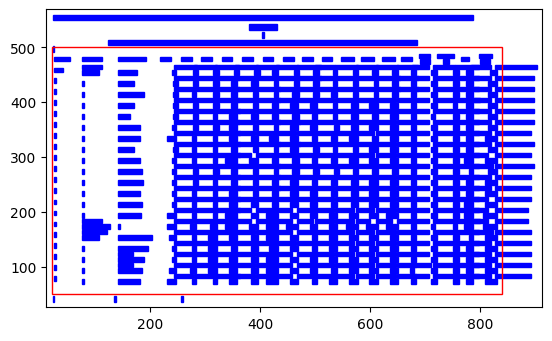

In [106]:
# Filepath
pdf_folder_path = 'data/PPPP'
filename = '2023_Q2.pdf'

# Read first table
table0 = camelot.read_pdf(
    os.path.join(pdf_folder_path,filename),
    pages='34',                        # Page for table
    flavor='stream',                   # stream preferred here, with lattice showing suboptimal performance for this pdf
    table_areas=['20,500,840,50']      # Area for table extraction
    )

camelot.plot(table0[0], kind='contour').show()
df_table0 = table0[0].df

# Squeeze first table and view output.
df_table0_new = squeeze(df_table0,3,3)
df_table0_new.head(10)

In [107]:
# Read all other tables
tables = camelot.read_pdf(
    os.path.join(pdf_folder_path,filename),
    pages='35-end',
    flavor='stream',
    table_areas=['20,550,840,50']
    )

# Check how many tables were extracted
print(f"Total tables extracted: {len(tables)}")

# Squeeze each table and combine all into a list
all_dfs = [table.df for table in tables]
all_dfs = [squeeze(df,3,3) for df in all_dfs]
all_dfs = [df_table0_new] + all_dfs

# Set column names
for df in all_dfs:
    df.columns = df.iloc[0]
all_dfs = [df[1:].reset_index(drop=True) for df in all_dfs]

# Make sure all tables have the same number of columns.
for i, df in enumerate(all_dfs):
    print(f'Table {i} has {len(df.columns)} columns')

Total tables extracted: 76
Table 0 has 19 columns
Table 1 has 19 columns
Table 2 has 20 columns
Table 3 has 20 columns
Table 4 has 20 columns
Table 5 has 20 columns
Table 6 has 20 columns
Table 7 has 20 columns
Table 8 has 20 columns
Table 9 has 20 columns
Table 10 has 20 columns
Table 11 has 20 columns
Table 12 has 20 columns
Table 13 has 20 columns
Table 14 has 20 columns
Table 15 has 20 columns
Table 16 has 20 columns
Table 17 has 20 columns
Table 18 has 20 columns
Table 19 has 20 columns
Table 20 has 20 columns
Table 21 has 20 columns
Table 22 has 20 columns
Table 23 has 19 columns
Table 24 has 19 columns
Table 25 has 20 columns
Table 26 has 20 columns
Table 27 has 20 columns
Table 28 has 20 columns
Table 29 has 20 columns
Table 30 has 20 columns
Table 31 has 20 columns
Table 32 has 20 columns
Table 33 has 20 columns
Table 34 has 20 columns
Table 35 has 20 columns
Table 36 has 20 columns
Table 37 has 20 columns
Table 38 has 20 columns
Table 39 has 20 columns
Table 40 has 20 columns

In [108]:
# Inspect tables with fewer columns than expected
small_tables = []
for i, df in enumerate(all_dfs):
    if len(df.columns) != 20:
        print(f'\n\n\nTable {i}')
        display(df.head())
        small_tables.append(i)




Table 0


,REGIONPROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,SET11,SET12,FNSP,IPsinGIDA,ItinerantIPs,HSF,GrandTotal
0,NCR FIRST,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NCR,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DISTRICT,BINONDO,1,-,-,-,-,19,2,-,1,1,19,10,-,-,-,14,67
3,,ERMITA,-,-,-,25,12,1,2,-,1,7,7,41,-,-,-,45,141
4,,INTRAMUROS,-,1,-,46,1,1,62,-,12,8,4,54,-,-,-,23,212





Table 1


,REGIONPROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,SET11,SET12,FNSP,IPsinGIDA,ItinerantIPs,HSF,GrandTotal
0,,PATEROS,4,1,50,2,8,337,34,-,32,13,17,99,-,-,-,-,597
1,,TAGUIG CITY,328,18,24,530,"1,239",188,201,5,122,147,"1,087","1,968",1,1,-,27,"5,886"
2,NCR FOURTH,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DISTRICT Total,,663,42,"1,029","1,358","1,425","7,397","1,240",58,829,816,"2,260","5,603",2,1,-,242,"22,965"
4,NCR SECOND,CITY OF,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN





Table 23


,REGIONPROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,SET11,SET12,FNSP,IPsinGIDA,ItinerantIPs,HSF,GrandTotal
0,,INDANG,3,2,5,6,10,371,36,-,39,68,37,481,-,-,-,1,"1,059"
1,,KAWIT,1,2,1,11,10,656,124,2,95,46,53,591,-,-,-,-,"1,592"
2,,MAGALLANES,-,1,181,3,14,119,6,2,50,5,19,215,-,-,-,-,615
3,,MARAGONDON,4,1,158,3,13,348,51,1,89,87,5,373,-,-,-,-,"1,133"
4,,MENDEZ (MENDEZ-,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN





Table 24


,REGIONPROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,SET11,SET12,FNSP,IPsinGIDA,ItinerantIPs,HSF,GrandTotal
0,,KALAYAAN,-,-,2,2,1,149,9,-,25,49,57,119,-,-,-,-,413
1,,LILIW,-,-,1,4,3,133,8,-,21,39,67,110,-,-,-,-,386
2,,LOS BAÑOS,1,1,2,8,6,353,54,2,24,66,61,257,-,-,-,-,835
3,,LUISIANA,-,-,2,-,3,47,-,1,7,27,41,33,-,-,-,-,161
4,,LUMBAN,-,-,-,-,-,131,9,-,11,32,44,108,-,-,-,-,335





Table 52


,REGIONPROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,SET11,SET12,FNSP,IPsinGIDA,ItinerantIPs,HSF,GrandTotal
0,,LOPE DE VEGA,451,2,-,2,7,29,36,-,60,45,207,264,-,-,-,-,"1,103"
1,,MAPANAS,512,1,1,14,2,4,24,-,93,29,147,188,-,-,-,-,"1,015"
2,,MONDRAGON,"1,412",5,1,10,12,19,90,108,153,90,372,421,-,-,-,-,"2,693"
3,,PALAPAG,"1,263",-,2,13,1,18,70,38,167,83,290,524,1,-,-,-,"2,470"
4,,PAMBUJAN,832,-,2,8,7,37,65,-,113,74,476,417,-,-,-,-,"2,031"


In [109]:
# Fix tables where REGION, PROVINCE and MUNICIPALITY columns may be merged, one way or another
for i in small_tables:
    if 'REGIONPROVINCE' in all_dfs[i].columns:
        all_dfs[i].rename(columns={'REGIONPROVINCE':'PROVINCE'}, inplace=True)
        all_dfs[i] = pd.concat([pd.DataFrame('', index=all_dfs[i].index, columns=['REGION']),
                                all_dfs[i]],
                                axis=1)
    elif 'PROVINCEMUNICIPALITY' in all_dfs[i].columns:
        all_dfs[i].rename(columns={'PROVINCEMUNICIPALITY':'MUNICIPALITY'}, inplace=True)
        all_dfs[i] = pd.concat([all_dfs[i].iloc[:,0],
                                pd.DataFrame('', index=all_dfs[i].index, columns=['PROVINCE']),
                                all_dfs[i].iloc[:,1:]],
                                axis=1)
    elif 'REGIONPROVINCEMUNICIPALITY' in all_dfs[i].columns:
        all_dfs[i].rename(columns={'REGIONPROVINCEMUNICIPALITY':'MUNICIPALITY'}, inplace=True)
        all_dfs[i] = pd.concat([pd.DataFrame('', index=all_dfs[i].index, columns=['REGION','PROVINCE']),
                            all_dfs[i]],
                            axis=1)
    else:
        raise Exception('Unknown column merge type')

Clean up.

In [110]:
# Fix table 1
all_dfs[1].iloc[20,0] = all_dfs[1].iloc[20,1]
all_dfs[1].iloc[20,1] = ''

In [111]:
df_2023_Q2 = pd.concat(all_dfs,axis=0).reset_index(drop=True)

In [112]:
# Split table by region
total_rows_region = get_total_locs2(df_2023_Q2,col=0)         # Get row numbers corresponding to 'total' rows for REGION
region_dfs = split_tables(df_2023_Q2,total_rows_region)      # Split into one table per REGION

# Collect
region_totals = []
province_totals = []
municipals = []
for i, region_df_or in enumerate(region_dfs):
    # Get region totals
    region_df = region_df_or.copy()
    total_row, region_name = get_totals2(region_df,col=0)
    region_totals.append(total_row)    

    # Split table by province
    region_df = region_df_or.copy()
    total_rows_province = get_total_locs2(region_df,col=1)     # Get row numbers corresponding to 'total' rows for PROVINCE
    province_dfs = split_tables(region_df,total_rows_province)      # Split into one table per REGION

    for province_df_or in province_dfs:
        province_df = province_df_or.copy()
        total_row, province_name = get_totals2(province_df,col=1)
        total_row.iloc[0] = region_name
        province_totals.append(total_row)

        municipal_df = clean_province_df2(province_df)
        municipal_df.iloc[:,0] = region_name
        municipal_df.iloc[:,1] = province_name
        municipals.append(municipal_df)

In [113]:
df_region_totals = pd.DataFrame(region_totals)
df_region_totals = convert_to_numeric_df(df_region_totals)

df_province_totals = pd.DataFrame(province_totals)
df_province_totals = convert_to_numeric_df(df_province_totals)

df_municipals = pd.concat(municipals,axis=0)
df_municipals = convert_to_numeric_df(df_municipals)

print('Regional sums:')
display(df_region_totals.head())
print('\nProvincial sums:')
display(df_province_totals.head())
print('\nMunicipal records:')
display(df_municipals.head())

Regional sums:


,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,SET11,SET12,FNSP,IPsinGIDA,ItinerantIPs,HSF,GrandTotal
47,NCR,Total,Total,3639,213,2465,13196,13113,36782,12087,434,4477,4581,9154,28360,5,6,1,1309,129822
92,CAR,Total,Total,5774,17,837,5117,9290,1294,1934,183,691,88,3261,12747,1,768,0,0,42002
141,I,Total,Total,4979,470,3420,5811,34002,27741,8962,480,12135,2370,8967,46170,0,514,0,2,156023
100,II,Total,Total,3236,23,5294,4310,28884,7615,2394,695,4934,3435,5103,43978,1,2299,0,1,112202
156,III,Total,Total,2883,166,8517,5020,22470,65232,11932,611,11225,7581,11248,76560,7,2898,0,46,226396



Provincial sums:


,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,SET11,SET12,FNSP,IPsinGIDA,ItinerantIPs,HSF,GrandTotal
17,NCR,NCR FIRST DISTRICT,Total,753,17,23,3994,397,7625,3273,98,781,1028,2500,5008,0,1,1,712,26211
11,NCR,NCR FOURTH DISTRICT,Total,663,42,1029,1358,1425,7397,1240,58,829,816,2260,5603,2,1,0,242,22965
7,NCR,NCR SECOND DISTRICT,Total,1126,83,661,3867,476,17695,4879,220,1440,1877,1711,8537,1,3,0,245,42821
7,NCR,NCR THIRD DISTRICT,Total,1097,71,752,3977,10815,4065,2695,58,1427,860,2683,9212,2,1,0,110,37825
29,CAR,ABRA,Total,2098,0,3,1324,2252,134,655,30,141,6,770,3296,1,68,0,0,10778



Municipal records:


,REGION,PROVINCE,MUNICIPALITY,SET1,SET2,SET3,SET4,SET5,SET6,SET7,SET8,SET9,SET10,SET11,SET12,FNSP,IPsinGIDA,ItinerantIPs,HSF,GrandTotal
2,NCR,NCR FIRST DISTRICT,BINONDO,1,0,0,0,0,19,2,0,1,1,19,10,0,0,0,14,67
3,NCR,NCR FIRST DISTRICT,ERMITA,0,0,0,25,12,1,2,0,1,7,7,41,0,0,0,45,141
4,NCR,NCR FIRST DISTRICT,INTRAMUROS,0,1,0,46,1,1,62,0,12,8,4,54,0,0,0,23,212
5,NCR,NCR FIRST DISTRICT,MALATE,0,0,0,37,1,10,281,17,3,44,179,173,0,0,1,76,822
6,NCR,NCR FIRST DISTRICT,PACO,0,0,1,197,26,20,84,4,1,59,49,166,0,1,0,17,625


In [114]:
# Check if province sums up to region values. It does!
df_province_totals_temp = df_province_totals.copy()
df_province_totals_temp = df_province_totals_temp.groupby(df_province_totals.columns[0]).sum()
df_province_totals_temp.drop(columns=df_province_totals.columns[1:3],inplace=True)
df_province_totals_temp = df_province_totals_temp.sort_index()

df_region_totals_temp = df_region_totals.copy()
df_region_totals_temp = df_region_totals_temp.drop(columns=df_region_totals.columns[1:3])
df_region_totals_temp = df_region_totals_temp.set_index(df_region_totals.columns[0])
df_region_totals_temp = df_region_totals_temp.drop('Grand').sort_index()

df_province_totals_temp.equals(df_region_totals_temp)

True

In [115]:
# check if municipal sums up to province values. It does!
df_municipals_temp = df_municipals.copy()
df_municipals_temp = df_municipals_temp.groupby(list(df_municipals.columns[:2])).sum().drop(columns=df_municipals.columns[2])
df_municipals_temp = df_municipals_temp.reset_index().sort_values(list(df_municipals.columns[:2]))

df_province_totals_temp = df_province_totals.copy()
df_province_totals_temp = df_province_totals_temp.drop(columns=[df_province_totals.columns[2]])
df_province_totals_temp = df_province_totals_temp.sort_values(list(df_province_totals.columns[:2])).reset_index(drop=True)

df_municipals_temp.equals(df_province_totals_temp)

True

### 2023_Q4

The 2023 Q4 report requires special processing due to the table encoding approach used.

![PPPP 2024 Q4 null encoding](./assets/2023_Q4_null_encoding.png)

As such, we make use of the coordinates of column dividers instead, making use of digitizer apps that are freely available online, as shown below.

![PPPP 2024 Q4 null encoding](./assets/2023_Q4_column_divider_digitized.png)

The coordinates are used with the `columns` keyword argument in `camelot.read_pdf`, which informs camelot of the column locations explicitly. For simplicity, the `table_areas` are adjusted to avoid reading the headers, which will be supplied manually later.

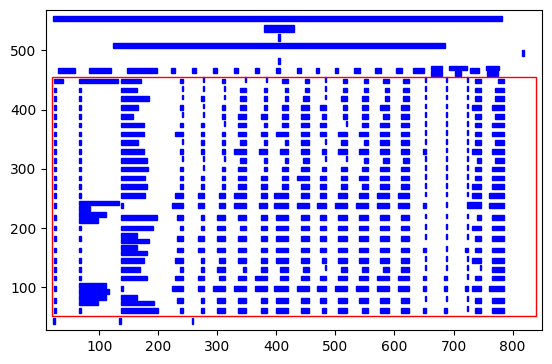

In [116]:
# Filepath
pdf_folder_path = 'data/PPPP'
filename = '2023_Q4.pdf'

# Read first table
table0 = camelot.read_pdf(
    os.path.join(pdf_folder_path,filename),
    pages='36',
    flavor='stream',
    table_areas=['20,455,840,50'],
    # columns=['50,130,200,260,280,330,360,390,420,270,500,530,560,600,630,670,700,740,760'],
    columns=['41.406243422534445,124.21873026760325,201.56252083834232,242.06248451676242,278.2187339928935,312.49999534338724,\
             346.8750067520885,383.593732363079,418.74998183921014,455.4687670548445,482.81251664739085,520.312480325811,555.4687298019419,\
             592.968753085006,627.3437644937073,658.5937044234022,692.1874777646739,724.999953433872,750.0000484287731'])

camelot.plot(table0[0], kind='contour').show()
df_table0 = table0[0].df

In [117]:
# Read all other tables
tables = camelot.read_pdf(
    os.path.join(pdf_folder_path,filename),
    pages='37-end',
    flavor='stream',
    table_areas=['20,520,840,50'],
    columns=['41.406243422534445,124.21873026760325,201.56252083834232,242.06248451676242,278.2187339928935,312.49999534338724,\
             346.8750067520885,383.593732363079,418.74998183921014,455.4687670548445,482.81251664739085,520.312480325811,555.4687298019419,\
             592.968753085006,627.3437644937073,658.5937044234022,692.1874777646739,724.999953433872,750.0000484287731']
    )

all_dfs = [table.df for table in tables]
all_dfs = [df_table0] + all_dfs

for df in all_dfs:
    df.columns = np.arange(df.shape[1])

# Make sure all tables have the same number of columns. Some tables have fewer columns
for i, df in enumerate(all_dfs):
    print(f'Table {i} has {len(df.columns)} columns')

Table 0 has 20 columns
Table 1 has 20 columns
Table 2 has 20 columns
Table 3 has 20 columns
Table 4 has 20 columns
Table 5 has 20 columns
Table 6 has 20 columns
Table 7 has 20 columns
Table 8 has 20 columns
Table 9 has 20 columns
Table 10 has 20 columns
Table 11 has 20 columns
Table 12 has 20 columns
Table 13 has 20 columns
Table 14 has 20 columns
Table 15 has 20 columns
Table 16 has 20 columns
Table 17 has 20 columns
Table 18 has 20 columns
Table 19 has 20 columns
Table 20 has 20 columns
Table 21 has 20 columns
Table 22 has 20 columns
Table 23 has 20 columns
Table 24 has 20 columns
Table 25 has 20 columns
Table 26 has 20 columns
Table 27 has 20 columns
Table 28 has 20 columns
Table 29 has 20 columns
Table 30 has 20 columns
Table 31 has 20 columns
Table 32 has 20 columns
Table 33 has 20 columns
Table 34 has 20 columns
Table 35 has 20 columns
Table 36 has 20 columns
Table 37 has 20 columns
Table 38 has 20 columns
Table 39 has 20 columns
Table 40 has 20 columns
Table 41 has 20 columns
Ta

In [118]:
# Inspect tables
for i, df in enumerate(all_dfs):
    print(f'\n\n\nTable {i}')
    display(df.head())
    if i == 5:
        break




Table 0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,NCR,NCR FIRST DISTRICT,BINONDO,1,,1,,,22,3,,1,2,18,10,,,,25,83
1,,,ERMITA,,,,38,8,3,7,,2,9,9,38,,,,63,177
2,,,INTRAMUROS,,1,,64,1,4,98,,17,15,8,51,,,,28,287
3,,,MALATE,2,,1,62,6,11,488,24,3,68,229,173,,,,103,"1,170"
4,,,PACO,,,1,340,40,28,144,8,2,98,81,162,,,,21,925





Table 1


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,,,CITY OF PASIG,758,10,20,794,95,"4,274",325,3,28,812,356,"1,516",,1,,19,"9,011"
1,,,CITY OF SAN JUAN,4,,97,11,10,416,40,,63,4,87,151,,,,17,900
2,,,QUEZON CITY,720,94,135,"3,531",348,"14,160","5,103",229,"1,212","1,653","1,370","5,952",2,2,,289,"34,800"
3,,NCR SECOND,,,,,,,,,,,,,,,,,,
4,,,,"1,503",117,"1,138","4,964",584,"25,997","6,730",263,"1,967","2,700","2,112","8,952",3,4,,361,"57,395"





Table 2


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,,,SAN ISIDRO,141,,,3,3,,12,3,6,,29,77,,1,,,275
1,,,SAN JUAN,7,,,6,380,29,45,,5,,58,151,,,,,681
2,,,SAN QUINTIN,,,,1,168,15,6,3,3,,15,50,,,,,261
3,,,TAYUM,2,,,4,449,26,62,1,11,,70,178,,1,,,804
4,,,TINEG,2,,,300,2,2,9,,4,1,7,70,,1,,,398





Table 3


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,,IFUGAO,AGUINALDO,2,,1,876,21,7,45,5,19,1,122,205,,1,,,"1,305"
1,,,ALFONSO LISTA,,,,,,,,,,,,,,,,,
2,,,,8,,1,702,40,10,45,3,20,,155,193,,1,,,"1,178"
3,,,(POTIA),,,,,,,,,,,,,,,,,
4,,,ASIPULO,1,,300,315,24,34,43,6,14,1,46,103,,92,,,979





Table 4


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,,,TADIAN,,1,,3,323,17,25,1,3,,55,238,,,,,666
1,,MOUNTAIN,,,,,,,,,,,,,,,,,,
2,,,,"1,131",2,90,102,"1,715",100,409,15,115,4,658,"2,912",1,358,,,"7,612"
3,,PROVINCE Total,,,,,,,,,,,,,,,,,,
4,CAR Total,,,"7,001",22,"1,104","7,643","14,031","2,441","3,524",345,906,115,"5,246","12,695",4,"1,243",,,"56,320"





Table 5


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,,,CABUGAO,1,,245,,12,792,62,3,101,16,36,184,,,,,"1,452"
1,,,CAOAYAN,,,,2,4,315,19,3,44,10,1,96,,,,,494
2,,,CERVANTES,1,,361,169,19,49,119,,37,15,2,91,,97,,,960
3,,,CITY OF CANDON,1,,3,6,760,26,72,5,90,14,78,276,,,,,"1,331"
4,,,CITY OF VIGAN,,,,,,,,,,,,,,,,,


Clean up.

In [119]:
# Fix table 1
all_dfs[1].iloc[15,17] = '2'
all_dfs[1].iloc[15,18] = '1,998'

# Fix table 58
all_dfs[58].iloc[-1,17] = '277'
all_dfs[58].iloc[-1,18] = '2,827'

In [120]:
# Combine into one dataframe and set column names
df_2023_Q4 = pd.concat(all_dfs,axis=0).reset_index(drop=True)
column_names = ['REGION','PROVINCE','MUNICIPALITY','1','2','3','4','5','6','7','8','9','10','11','12','FNSP','IPs in GIDA','Itenerant IPs','HSF','Grand Total']
df_2023_Q4.columns = column_names
df_2023_Q4.head(20)

,REGION,PROVINCE,MUNICIPALITY,1,2,3,4,5,6,7,8,9,10,11,12,FNSP,IPs in GIDA,Itenerant IPs,HSF,Grand Total
0,NCR,NCR FIRST DISTRICT,BINONDO,1,,1,,,22,3,,1,2,18,10,,,,25,83
1,,,ERMITA,,,,38,8,3,7,,2,9,9,38,,,,63,177
2,,,INTRAMUROS,,1,,64,1,4,98,,17,15,8,51,,,,28,287
3,,,MALATE,2,,1,62,6,11,488,24,3,68,229,173,,,,103,"1,170"
4,,,PACO,,,1,340,40,28,144,8,2,98,81,162,,,,21,925
5,,,PANDACAN,1,1,,213,6,14,322,17,,55,220,328,,,,22,"1,199"
6,,,PORT AREA,799,5,6,141,17,"1,556",167,12,133,200,121,393,,,,72,"3,622"
7,,,QUIAPO,,1,1,17,7,4,287,,10,7,130,110,,,,27,601
8,,,SAMPALOC,4,4,9,"1,715",451,119,197,5,100,242,547,639,1,,,146,"4,179"
9,,,SAN MIGUEL,,,,36,5,8,96,,,4,72,99,,,,9,329


In [121]:
# Split table by region
total_rows_region = get_total_locs(df_2023_Q4,col=0)         # Get row numbers corresponding to 'total' rows for REGION
region_dfs = split_tables(df_2023_Q4,total_rows_region)      # Split into one table per REGION

# Collect
region_totals = []
province_totals = []
municipals = []
for i, region_df_or in enumerate(region_dfs):
    # Get region totals
    region_df = region_df_or.copy()
    total_row, region_name = get_totals(region_df,col=0)
    region_totals.append(total_row)    

    # Split table by province
    region_df = region_df_or.copy()
    total_rows_province = get_total_locs(region_df,col=1)     # Get row numbers corresponding to 'total' rows for PROVINCE
    province_dfs = split_tables(region_df,total_rows_province)      # Split into one table per REGION

    for province_df_or in province_dfs:
        province_df = province_df_or.copy()
        total_row, province_name = get_totals(province_df,col=1)
        total_row.iloc[0] = region_name
        province_totals.append(total_row)

        municipal_df = clean_province_df(province_df)
        municipal_df.iloc[:,0] = region_name
        municipal_df.iloc[:,1] = province_name
        municipals.append(municipal_df)

In [122]:
df_region_totals = pd.DataFrame(region_totals)
df_region_totals = convert_to_numeric_df(df_region_totals)

df_province_totals = pd.DataFrame(province_totals)
df_province_totals = convert_to_numeric_df(df_province_totals)

df_municipals = pd.concat(municipals,axis=0)
df_municipals = convert_to_numeric_df(df_municipals)

print('Regional sums:')
display(df_region_totals.head())
print('\nProvincial sums:')
display(df_province_totals.head())
print('\nMunicipal records:')
display(df_municipals.head())

Regional sums:


,REGION,PROVINCE,MUNICIPALITY,1,2,3,4,5,6,7,8,9,10,11,12,FNSP,IPs in GIDA,Itenerant IPs,HSF,Grand Total
52,NCR,Total,Total,5487,332,4335,20042,22376,61704,19701,629,6867,7583,12842,29023,9,6,2,1998,192936
97,CAR,Total,Total,7001,22,1104,7643,14031,2441,3524,345,906,115,5246,12695,4,1243,0,0,56320
135,I,Total,Total,5792,1078,5658,9624,54044,43351,13969,778,15025,3330,11607,46308,0,1344,0,2,211910
110,II,Total,Total,3260,29,6046,5135,36032,9560,3815,980,5163,3691,5728,45921,0,2544,0,1,127905
163,III,Total,Total,4455,219,10996,7554,32109,99248,19999,869,13609,9894,14397,82651,11,3022,0,53,299086



Provincial sums:


,REGION,PROVINCE,MUNICIPALITY,1,2,3,4,5,6,7,8,9,10,11,12,FNSP,IPs in GIDA,Itenerant IPs,HSF,Grand Total
16,NCR,NCR FIRST DISTRICT,Total,1133,26,42,6030,664,12600,5502,144,1216,1785,3753,4988,1,0,0,1085,38969
15,NCR,NCR FOURTH DISTRICT,Total,1263,81,2057,2530,2899,15156,2493,104,1492,1460,3127,5777,3,2,2,372,38818
9,NCR,NCR SECOND DISTRICT,Total,1503,117,1138,4964,584,25997,6730,263,1967,2700,2112,8952,3,4,0,361,57395
8,NCR,NCR THIRD DISTRICT,Total,1588,108,1098,6518,18229,7951,4976,118,2192,1638,3850,9306,2,0,0,180,57754
29,CAR,ABRA,Total,2643,0,5,1568,3135,198,951,42,159,5,1019,3267,1,69,0,0,13062



Municipal records:


,REGION,PROVINCE,MUNICIPALITY,1,2,3,4,5,6,7,8,9,10,11,12,FNSP,IPs in GIDA,Itenerant IPs,HSF,Grand Total
0,NCR,NCR FIRST DISTRICT,BINONDO,1,0,1,0,0,22,3,0,1,2,18,10,0,0,0,25,83
1,NCR,NCR FIRST DISTRICT,ERMITA,0,0,0,38,8,3,7,0,2,9,9,38,0,0,0,63,177
2,NCR,NCR FIRST DISTRICT,INTRAMUROS,0,1,0,64,1,4,98,0,17,15,8,51,0,0,0,28,287
3,NCR,NCR FIRST DISTRICT,MALATE,2,0,1,62,6,11,488,24,3,68,229,173,0,0,0,103,1170
4,NCR,NCR FIRST DISTRICT,PACO,0,0,1,340,40,28,144,8,2,98,81,162,0,0,0,21,925


In [123]:
# Check if province sums up to region values. It does!
df_province_totals_temp = df_province_totals.copy()
df_province_totals_temp = df_province_totals_temp.groupby(df_province_totals.columns[0]).sum()
df_province_totals_temp.drop(columns=df_province_totals.columns[1:3],inplace=True)
df_province_totals_temp = df_province_totals_temp.sort_index()

df_region_totals_temp = df_region_totals.copy()
df_region_totals_temp = df_region_totals_temp.drop(columns=df_region_totals.columns[1:3])
df_region_totals_temp = df_region_totals_temp.set_index(df_region_totals.columns[0])
df_region_totals_temp = df_region_totals_temp.drop('Grand').sort_index()

df_province_totals_temp.equals(df_region_totals_temp)

True

In [124]:
# check if municipal sums up to province values. It does!
df_municipals_temp = df_municipals.copy()
df_municipals_temp = df_municipals_temp.groupby(list(df_municipals.columns[:2])).sum().drop(columns=df_municipals.columns[2])
df_municipals_temp = df_municipals_temp.reset_index().sort_values(list(df_municipals.columns[:2]))

df_province_totals_temp = df_province_totals.copy()
df_province_totals_temp = df_province_totals_temp.drop(columns=[df_province_totals.columns[2]])
df_province_totals_temp = df_province_totals_temp.sort_values(list(df_province_totals.columns[:2])).reset_index(drop=True)

df_municipals_temp.equals(df_province_totals_temp)

True

### Gather all dataframes

In [153]:
# Consolidate dataframes
df_names = [key for key in globals().keys() if 'df_2' in key]              # Get all dataframe names
years = [int(key[-7:-3]) for key in df_names]                              # Get all years
quarters = [int(key[-1]) for key in df_names]                              # Get all quarters
all_report_dfs = [globals()[key].copy() for key in df_names]               # Get all dataframes in one list
for year,quarter,df in zip(years,quarters,all_report_dfs):
    df['Year'] = year
    df['Quarter'] = quarter
with open('data/PPPP/pppp_tables.pkl', 'wb') as f:
    pickle.dump(all_report_dfs,f)

## Geo-analysis

For a demonstration of geo-analysis, we make use of the HRSL layers for population density, as well as the boundaries of the different regions, provinces and municipalities of the Philippines.

### Preprocessing

#### PPPP

In [3]:
# Preset    
years = [2020,2020,2020,2020,
         2021,2021,2021,2021,
         2022,2022,2022,2022,
         2023,2023]

quarters = [1,2,3,4,
            1,2,3,4,
            1,2,3,4,
            2,4]

get_total_locs_fn = [
    get_total_locs, # 2020_Q1
    get_total_locs, # 2020_Q2
    get_total_locs, # 2020_Q3
    get_total_locs, # 2020_Q4
    get_total_locs, # 2021_Q1
    get_total_locs, # 2021_Q2
    get_total_locs, # 2021_Q3
    get_total_locs, # 2021_Q4
    get_total_locs, # 2022_Q1
    get_total_locs, # 2022_Q2
    get_total_locs, # 2022_Q3
    get_total_locs2, # 2022_Q4
    get_total_locs2, # 2023_Q2
    get_total_locs # 2023_Q4
]
get_totals_fn = [
    get_totals, # 2020_Q1
    get_totals, # 2020_Q2
    get_totals, # 2020_Q3
    get_totals, # 2020_Q4
    get_totals, # 2021_Q1
    get_totals, # 2021_Q2
    get_totals, # 2021_Q3
    get_totals, # 2021_Q4
    get_totals, # 2022_Q1
    get_totals, # 2022_Q2
    get_totals, # 2022_Q3
    get_totals2, # 2022_Q4
    get_totals2, # 2023_Q2
    get_totals # 2023_Q4
]
clean_province_df_fn = [
    clean_province_df, # 2020_Q1
    clean_province_df3, # 2020_Q2
    clean_province_df, # 2020_Q3
    clean_province_df, # 2020_Q4
    clean_province_df, # 2021_Q1
    clean_province_df, # 2021_Q2
    clean_province_df, # 2021_Q3
    clean_province_df, # 2021_Q4
    clean_province_df, # 2022_Q1
    clean_province_df, # 2022_Q2
    clean_province_df, # 2022_Q3
    clean_province_df2, # 2022_Q4
    clean_province_df2, # 2023_Q2
    clean_province_df # 2023_Q4
]

column_map = {'1':'set1','2':'set2','3':'set3','4':'set4','5':'set5','6':'set6',
              '7':'set7','7m':'set7m','8':'set8','8e':'set8e','9':'set9',
              '10':'set10','11':'set11','12':'set12','12m':'set12m',
              'ipsgida':'ipsingida','itenerantips':'itinerantips'}

In [4]:
# Load previously extracted PPPP data.
with open('data/PPPP/pppp_tables.pkl', 'rb') as f:
    all_report_dfs = pickle.load(f)

In [5]:
# Clean up to standardize and get all required dataframes
all_region_dfs = []
all_province_dfs = []
all_municipal_dfs = []

for j,df in enumerate(all_report_dfs):
    # Split table by region
    total_rows_region = get_total_locs_fn[j](df,col=0)         # Get row numbers corresponding to 'total' rows for REGION
    region_dfs = split_tables(df,total_rows_region)      # Split into one table per REGION

    # Collect
    region_totals = []
    province_totals = []
    municipals = []
    for i, region_df_or in enumerate(region_dfs):
        # Get region totals
        region_df = region_df_or.copy()
        total_row, region_name = get_totals_fn[j](region_df,col=0)
        region_totals.append(total_row)    

        # Split table by province
        region_df = region_df_or.copy()
        total_rows_province = get_total_locs_fn[j](region_df,col=1)     # Get row numbers corresponding to 'total' rows for PROVINCE
        province_dfs = split_tables(region_df,total_rows_province)      # Split into one table per REGION

        for province_df_or in province_dfs:
            province_df = province_df_or.copy()
            total_row, province_name = get_totals_fn[j](province_df,col=1)
            total_row.iloc[0] = region_name
            province_totals.append(total_row)

            municipal_df = clean_province_df_fn[j](province_df)
            municipal_df.iloc[:,0] = region_name
            municipal_df.iloc[:,1] = province_name
            municipals.append(municipal_df)

    # Produce dataframes and convert to numeric form
    df_region_totals = pd.DataFrame(region_totals)
    df_region_totals = convert_to_numeric_df(df_region_totals)
    df_province_totals = pd.DataFrame(province_totals)
    df_province_totals = convert_to_numeric_df(df_province_totals)
    df_municipals = pd.concat(municipals,axis=0)
    df_municipals = convert_to_numeric_df(df_municipals)

    all_region_dfs.append(df_region_totals)
    all_province_dfs.append(df_province_totals)
    all_municipal_dfs.append(df_municipals)

In [6]:
# Add year and quarter information to all dfs
for df_region, df_province, df_municipal, year, quarter in \
    zip(all_region_dfs, all_province_dfs, all_municipal_dfs, years, quarters):
    df_region['Year'] = year
    df_province['Year'] = year
    df_municipal['Year'] = year
    df_region['Quarter'] = quarter
    df_province['Quarter'] = quarter
    df_municipal['Quarter'] = quarter

In [7]:
def standardize_region(region):
    # Remove all 'total' wording
    region_new = re.sub(r'total','',region,flags=re.IGNORECASE).strip()
    # Inconsistent spelling
    region_new = 'IV-A' if ('calabarzon' in region.lower()) else region_new
    region_new = 'IV-A' if ('calaba  rzon' in region.lower()) else region_new
    region_new = 'MIMAROPA' if ('mimar opa' in region.lower()) else region_new
    region_new = 'MIMAROPA' if ('mimaro pa' in region.lower()) else region_new
    region_new = 'MIMAROPA' if ('mimarop  a' in region.lower()) else region_new
    region_new = 'CARAGA' if ('caraga' in region.lower()) else region_new
    return region_new
    
def standardize_province(province):
    # Remove all 'total' wording
    province_new = re.sub(r'total','',province,flags=re.IGNORECASE).strip()
    # Remove extra spaces
    province_new = re.sub(r'\s+',' ',province)
    # Inconsistent spelling
    province_new = 'NORTH COTABATO' if ('(north cotabato)' in province_new.lower()) else province_new
    province_new = 'MAGUINDANAO' if ('MAGUINDANA O'.lower() in province_new.lower()) else province_new
    province_new = 'CATANDUANES' if ('CATANDUANE S'.lower() in province_new.lower()) else province_new
    province_new = 'DAVAO DE ORO' if ('COMPOSTELA VALLEY'.lower() in province_new.lower()) else province_new
    
    return province_new

# Standardize all region and province names
for df_region in all_region_dfs:
    df_region.REGION = df_region.REGION.map(standardize_region)
for df_province in all_province_dfs:
    df_province.REGION = df_province.REGION.map(standardize_region)
    df_province.PROVINCE = df_province.PROVINCE.map(standardize_province)
for df_municipal in all_municipal_dfs:
    df_municipal.REGION = df_municipal.REGION.map(standardize_region)
    df_municipal.PROVINCE = df_municipal.PROVINCE.map(standardize_province)

In [8]:
# Standardize column names
for df_region in all_region_dfs:
    df_region.columns = [re.sub(r'\s+','',col).lower() for col in df_region.columns]                                 # Remove whitespaces and use lowercase
    df_region.columns = [column_map[col] if col in column_map.keys() else col for col in df_region.columns]          # Map spelling differences/mistakes
for df_province in all_province_dfs:
    df_province.columns = [re.sub(r'\s+','',col).lower() for col in df_province.columns]
    df_province.columns = [column_map[col] if col in column_map.keys() else col for col in df_province.columns]      # Map spelling differences/mistakes
for df_municipal in all_municipal_dfs:
    df_municipal.columns = [re.sub(r'\s+','',col).lower() for col in df_municipal.columns]
    df_municipal.columns = [column_map[col] if col in column_map.keys() else col for col in df_municipal.columns]    # Map spelling differences/mistakes

In [9]:
# Quick clean up
# line breaks in municipality names for early
all_municipal_dfs[10].reset_index(drop=True,inplace=True)
all_municipal_dfs[10].loc[1241,'municipality'] = all_municipal_dfs[10].loc[1241,'municipality'].split('\n')[1]
all_municipal_dfs[10].loc[1257,'municipality'] = all_municipal_dfs[10].loc[1257,'municipality'].split('\n')[1]

# Place marawi city in lanao del sur for early dfs
edit_loc = all_municipal_dfs[0]['municipality'].str.lower().str.contains('marawi')
all_municipal_dfs[0].loc[edit_loc,'region'] = 'BARMM'
all_municipal_dfs[0].loc[edit_loc,'province'] = 'LANAO DEL SUR'
edit_loc = all_municipal_dfs[1]['municipality'].str.lower().str.contains('marawi')
all_municipal_dfs[1].loc[edit_loc,'region'] = 'BARMM'
all_municipal_dfs[1].loc[edit_loc,'province'] = 'LANAO DEL SUR'
edit_loc = all_municipal_dfs[2]['municipality'].str.lower().str.contains('marawi')
all_municipal_dfs[2].loc[edit_loc,'region'] = 'BARMM'
all_municipal_dfs[2].loc[edit_loc,'province'] = 'LANAO DEL SUR'

# Renaming to clean final df
# buena vista for agusan del norte in caraga for final df. too much info, mapping will change other buena vistas in other parts of the country
all_municipal_dfs[-1].loc[all_municipal_dfs[-1].municipality == 'AGUSAN DEL NORTE  BUENAVISTA','municipality'] = 'BUENAVISTA'
all_municipal_dfs[-1].loc[all_municipal_dfs[-1].municipality == 'DAVAO OCCIDENTAL  DON MARCELINO','municipality'] = 'DON MARCELINO'
all_municipal_dfs[-1].loc[all_municipal_dfs[-1].municipality == 'NCR THIRD DISTRICT  CALOOCAN CITY','municipality'] = 'CALOOCAN CITY'
	
final_df = all_municipal_dfs[-1]
early_dfs = all_municipal_dfs[:-1]

In [10]:
# Create municipality name mapping to standardize to latest dataframe
final_df_names = final_df[['province','municipality']]
early_df_names = []
for df in early_dfs:
    early_df_names += [df[['province','municipality']]]
early_df_names = pd.concat(early_df_names,axis=0)
early_df_names.drop_duplicates(inplace=True)
final_df_names['clean_mun'] = final_df_names['municipality'].map(lambda x: re.sub(r'\s+','',x.lower()))
final_df_names['clean_pro'] = final_df_names['province'].map(lambda x: re.sub(r'\s+','',x.lower()))
final_df_names['clean_pro_mun'] = final_df_names.apply(lambda row: row['clean_pro']+'_'+row['clean_mun'],axis=1)

early_df_names['clean_mun'] = early_df_names['municipality'].map(lambda x: re.sub(r'\s+','',x.lower()))
early_df_names['clean_pro'] = early_df_names['province'].map(lambda x: re.sub(r'\s+','',x.lower()))
early_df_names['clean_pro_mun'] = early_df_names.apply(lambda row: row['clean_pro']+'_'+row['clean_mun'],axis=1)

# General idea for mapping all to final df. if they already match, there are no issues, even if there are mistakes because they make the same mistakes
# If they don't match, we need to match them to final df, but not if final_df has mistake.
# e.g. if final df has agusandelnortebuenavista, we shouldn't match buenavista to it, because there may be other buena vistas, i.e. not in agusan del norte.
# e.g. city of naga to naga city in camarines sur. because there may be city of naga in cebu.
# Here left with batangas subic, which does not exist in final df, but in earlier dfs. final df only has subic zambales
final_early_merge = final_df_names.merge(early_df_names,on='clean_pro_mun',how='outer')

In [11]:
# Manually resolving inconsistent naming
final_early_merge.iloc[37,:4] = final_early_merge.iloc[38,:4]
final_early_merge.iloc[56,:4] = final_early_merge.iloc[57,:4]
final_early_merge.iloc[247,:4] = final_early_merge.iloc[2260,:4]
final_early_merge.iloc[449,:4] = final_early_merge.iloc[448,:4]
final_early_merge.iloc[480,:4] = final_early_merge.iloc[495,:4]
final_early_merge.iloc[676,:4] = final_early_merge.iloc[675,:4]
final_early_merge.iloc[713,:4] = final_early_merge.iloc[712,:4]
final_early_merge.iloc[734,:4] = final_early_merge.iloc[736,:4]
final_early_merge.iloc[752,:4] = final_early_merge.iloc[747,:4]
final_early_merge.iloc[763,:4] = final_early_merge.iloc[759,:4]
final_early_merge.iloc[1243,:4] = final_early_merge.iloc[1272,:4]
final_early_merge.iloc[1340,:4] = final_early_merge.iloc[1343,:4]
final_early_merge.iloc[1348,:4] = final_early_merge.iloc[1345,:4]
final_early_merge.iloc[1349,:4] = final_early_merge.iloc[1333,:4]
final_early_merge.iloc[1391,:4] = final_early_merge.iloc[1362,:4]
final_early_merge.iloc[1407,:4] = final_early_merge.iloc[1401,:4]
final_early_merge.iloc[1463,:4] = final_early_merge.iloc[1454,:4]
final_early_merge.iloc[1531,:4] = final_early_merge.iloc[1527,:4]
final_early_merge.iloc[1581,:4] = final_early_merge.iloc[1582,:4]
final_early_merge.iloc[1700,:4] = final_early_merge.iloc[1692,:4]
final_early_merge.iloc[1719,:4] = final_early_merge.iloc[1706,:4]
final_early_merge.iloc[1987,:4] = final_early_merge.iloc[1963,:4]
final_early_merge.iloc[2056,:4] = final_early_merge.iloc[2043,:4]
final_early_merge.iloc[2089,:4] = final_early_merge.iloc[2062,:4]
final_early_merge.iloc[2114,:4] = final_early_merge.iloc[2092,:4]
final_early_merge.iloc[2170,:4] = final_early_merge.iloc[2144,:4]
final_early_merge.iloc[2194,:4] = final_early_merge.iloc[2173,:4]
final_early_merge.iloc[2338,:4] = final_early_merge.iloc[2301,:4]
final_early_merge.iloc[2360,:4] = final_early_merge.iloc[2342,:4]

# Create map
final_early_merge = final_early_merge[['municipality_x','clean_pro_mun']]
final_early_merge.drop_duplicates(inplace=True)
municipal_map = {vals[1]:vals[0] for _,vals in final_early_merge.iterrows()}

# Apply map
for df in early_dfs:
    df['clean_mun'] = df['municipality'].map(lambda x: re.sub(r'\s+','',x.lower()))
    df['clean_pro'] = df['province'].map(lambda x: re.sub(r'\s+','',x.lower()))
    df['clean_pro_mun'] = df.apply(lambda row: row['clean_pro']+'_'+row['clean_mun'],axis=1)
    
    df['municipality'] = df['clean_pro_mun'].map(municipal_map)
    df.drop(columns=['clean_mun','clean_pro','clean_pro_mun'],inplace=True)
    df.reset_index(inplace=True,drop=True)

In [12]:
# Reassemble standardized municipality dfs
final_df = all_municipal_dfs[-1]
early_dfs = all_municipal_dfs[:-1]

all_municipal_dfs = early_dfs + [final_df]

In [13]:
# Oldies

# for df in early_dfs:
#     print(df.year.unique()[0], df.quarter.unique()[0])
#     display(df.loc[df.municipality.str.lower().str.contains('naga')])

# final_early_merge.loc[pd.isna(final_early_merge.iloc[:,:4]).any(axis=1),'clean_pro_mun']

# display(final_early_merge.loc[final_early_merge['clean_pro_mun'].str.contains('jimenez')])


# checks = ['buenavista',
#           'bunawan',
#           'subic',
#           'basud',
#           'naga',
#           'cotabato',
#           'compostela',
#           'marcelino',
#           'caraga',
#           'basilisa',
#           'pagagawan',
#           'victoria',
#           'jimenez',
#           'aloran',
#           'alubijid',
#           'barlig',
#           'caloocan',
#           'canlaon',
#           'pigkawayan',
#           'abrade',
#           'baco',
#           'almagro',
#           'banga',
#           'anahawan',
#           'bagum',
#           'alegria',
#           'barobo',
#           'aurora',
#           'alicia']
# for check in checks:
#     clear_output(wait=True)  # Clears the output from the previous iteration
#     print(check)
#     display(final_early_merge.loc[final_early_merge['clean_pro_mun'].str.contains(check)])
#     input('')



#### Geodata (geographical boundaries and HRSL)

In [65]:
# Mapping for shapefiles
region_map = {'Region I (Ilocos Region)':'I',
              'Region II (Cagayan Valley)':'II',
              'Region III (Central Luzon)':'III',
              'Region IV-A (Calabarzon)':'IV-A',
              'Region V (Bicol Region)':'V',
              'Region VI (Western Visayas)':'VI',
              'Region VII (Central Visayas)':'VII',
              'Region VIII (Eastern Visayas)':'VIII',
              'Region IX (Zamboanga Peninsula)':'IX',
              'Region X (Northern Mindanao)':'X',
              'Region XI (Davao Region)':'XI',
              'Region XII (Soccsksargen)':'XII',
              'National Capital Region (NCR)':'NCR',
              'Cordillera Administrative Region (CAR)':'CAR',
              'Region XIII (Caraga)':'CARAGA',
              'Mimaropa Region':'MIMAROPA',
              'Bangsamoro Autonomous Region In Muslim Mindanao (BARMM)':'BARMM'}

For convenience, we make sure that the regions and names used in the geodataframe are the same as those used in the PPPP data

In [66]:
# Load the shapefile giving province boundaries
province_shape_path = 'data/philippines-psgc-shapefiles/data/2023/Provdists/phl_admbnda_adm2_psa_namria_20231106.shp'
province_shape = gpd.read_file(province_shape_path)

# Load the shapefile giving province boundaries
region_shape_path = 'data/philippines-psgc-shapefiles/data/2023/Regions/phl_admbnda_adm1_psa_namria_20231106.shp'
region_shape = gpd.read_file(region_shape_path)

# Load the shapefile giving municipality boundaries
municipality_shape_path = 'data/philippines-psgc-shapefiles/data/2023/Municities/phl_admbnda_adm3_psa_namria_20231106.shp'
municipality_shape = gpd.read_file(municipality_shape_path)

# 2023 file merges all NCR first district municipalities. Using 2015's
mun_shape_path_2015 = 'data/philippines-psgc-shapefiles/data/2015/Municities/Municities.shp'
mun_shape_2015 = gpd.read_file(mun_shape_path_2015)

# Changing region, province, and municipality column names for consistency with PPPP data
municipality_shape.rename(columns={'ADM3_EN':'municipality', 'ADM2_EN':'province','ADM1_EN':'region'},inplace=True)
mun_shape_2015.rename(columns={'ADM3_EN':'municipality', 'ADM2_EN':'province','ADM1_EN':'region'},inplace=True)
province_shape.rename(columns={'ADM2_EN':'province','ADM1_EN':'region'},inplace=True)
region_shape.rename(columns={'ADM1_EN':'region'},inplace=True)

# Keep only region, province, municipality, and geometry columns
municipality_shape = municipality_shape[['region','province','municipality','geometry']]
mun_shape_2015 = mun_shape_2015[['region','province','municipality','geometry']]
province_shape = province_shape[['region','province','geometry']]
region_shape = region_shape[['region','geometry']]

# Swap out city of Manila from 2020 data for better municipality breakdown from 2015 data
mun_shape_2015 = mun_shape_2015.loc[mun_shape_2015.province=='NCR, City of Manila, First District']
mun_shape_2015.region = 'National Capital Region (NCR)'
mun_shape_2015.province = 'Metropolitan Manila First District'
municipality_shape = municipality_shape.loc[municipality_shape.municipality!='City of Manila']
municipality_shape = pd.concat([municipality_shape,mun_shape_2015],axis=0)

# Change region names for consistency with PPPP data
province_shape['region'] = province_shape['region'].map(region_map)
region_shape['region'] = region_shape['region'].map(region_map)
municipality_shape['region'] = municipality_shape['region'].map(region_map)

# Merge Maguindanao rows in province
province_shape.loc[88,'province'] = 'MAGUINDANAO'
province_shape.loc[88,'region'] = 'BARMM'
province_shape.loc[88,'geometry'] = unary_union(province_shape.loc[85:86,'geometry'])
province_shape = province_shape.drop([85,86],axis=0).reset_index(drop=True)

# Merge Maguindanao rows in municipality
municipality_shape['province'] = municipality_shape['province'].map(lambda x: 'MAGUINDANAO' if 'maguindanao' in x.lower() else x)

In [67]:
# Create province name mapping between PPPP names and shapefile names
shape_province_names = sorted(list(province_shape['province']))
df_province_names = sorted(list(df_province.province.unique()))
shape_province_names_clean = [re.sub(r'\s+','',name.lower()) for name in shape_province_names]
df_province_names_clean = [re.sub(r'\s+','',name.lower()) for name in df_province_names]
df_map = pd.DataFrame({'df_or':df_province_names, 'df_clean':df_province_names_clean})
shape_map = pd.DataFrame({'shape_or':shape_province_names, 'shape_clean':shape_province_names_clean})
shape_df_merge = df_map.merge(shape_map,left_on='df_clean',right_on='shape_clean',how='outer')

# Manually update province names
shape_df_merge.iloc[26,:2] = shape_df_merge.iloc[25,:2]
shape_df_merge.iloc[27,:2] = shape_df_merge.iloc[65,:2]
shape_df_merge.iloc[32,:2] = shape_df_merge.iloc[31,:2]
shape_df_merge.iloc[52:56,:2] = shape_df_merge.iloc[59:63,:2]
shape_df_merge.dropna(inplace=True)
shape_df_merge.drop(columns = ['df_clean','shape_clean'],inplace=True)
province_map = {vals[1]:vals[0] for _,vals in shape_df_merge.iterrows()}

# Change province names for consistency with PPPP data
province_shape['province'] = province_shape['province'].map(province_map)
municipality_shape['province'] = municipality_shape['province'].map(province_map)
province_shape.dropna(inplace=True) # Dropping special geographic area 
municipality_shape.dropna(inplace=True) # Dropping special geographic area 

In [68]:
# Create municipality name mapping to standardize to pppp data
pppp_names = pd.concat(all_municipal_dfs)[['province','municipality']]
shape_names = municipality_shape[['province','municipality']]
pppp_names.drop_duplicates(inplace=True)
shape_names.drop_duplicates(inplace=True)
pppp_names['clean_mun'] = pppp_names['municipality'].map(lambda x: re.sub(r'\s+','',x.lower()))
pppp_names['clean_pro'] = pppp_names['province'].map(lambda x: re.sub(r'\s+','',x.lower()))
pppp_names['clean_pro_mun'] = pppp_names.apply(lambda row: row['clean_pro']+'_'+row['clean_mun'],axis=1)
shape_names['clean_mun'] = shape_names['municipality'].map(lambda x: re.sub(r'\s+','',x.lower()))
shape_names['clean_pro'] = shape_names['province'].map(lambda x: re.sub(r'\s+','',x.lower()))
shape_names['clean_pro_mun'] = shape_names.apply(lambda row: row['clean_pro']+'_'+row['clean_mun'],axis=1)
pppp_shape_merge = pppp_names.merge(shape_names,on='clean_pro_mun',how='outer')

In [69]:
# Manually resolving inconsistent naming
pppp_shape_merge.iloc[159,:4] = pppp_shape_merge.iloc[157,:4]
pppp_shape_merge.iloc[160,:4] = pppp_shape_merge.iloc[181,:4]
pppp_shape_merge.iloc[233,:4] = pppp_shape_merge.iloc[237,:4]
pppp_shape_merge.iloc[247,:4] = pppp_shape_merge.iloc[246,:4]
pppp_shape_merge.iloc[289,:4] = pppp_shape_merge.iloc[284,:4]
pppp_shape_merge.iloc[421,:4] = pppp_shape_merge.iloc[420,:4]
pppp_shape_merge.iloc[424,:4] = pppp_shape_merge.iloc[426,:4]
pppp_shape_merge.iloc[425,:4] = pppp_shape_merge.iloc[429,:4]
pppp_shape_merge.iloc[431,:4] = pppp_shape_merge.iloc[430,:4]
pppp_shape_merge.iloc[467,:4] = pppp_shape_merge.iloc[466,:4]
pppp_shape_merge.iloc[484,:4] = pppp_shape_merge.iloc[483,:4]
pppp_shape_merge.iloc[500,:4] = pppp_shape_merge.iloc[501,:4]
pppp_shape_merge.iloc[715,:4] = pppp_shape_merge.iloc[714,:4]
pppp_shape_merge.iloc[749,:4] = pppp_shape_merge.iloc[748,:4]
pppp_shape_merge.iloc[752,:4] = pppp_shape_merge.iloc[747,:4]
pppp_shape_merge.iloc[754,:4] = pppp_shape_merge.iloc[773,:4]
pppp_shape_merge.iloc[801,:4] = pppp_shape_merge.iloc[809,:4]
pppp_shape_merge.iloc[963,:4] = pppp_shape_merge.iloc[964,:4]
pppp_shape_merge.iloc[974,:4] = pppp_shape_merge.iloc[981,:4]
pppp_shape_merge.iloc[1260,:4] = pppp_shape_merge.iloc[1259,:4]
pppp_shape_merge.iloc[1273,:4] = pppp_shape_merge.iloc[1271,:4]

# not mapped
pppp_shape_merge.iloc[909,:4] = pppp_shape_merge.iloc[909,5:]  # cotabato city in maguindanao province in shapefile, but in cotabato city province in pppp data
pppp_shape_merge.iloc[1239,:4] = pppp_shape_merge.iloc[1239,5:] # kalayaan palawan that doesn't exist in pppp data

# Create map
pppp_shape_merge = pppp_shape_merge[['municipality_x','clean_pro_mun']]
pppp_shape_merge.drop_duplicates(inplace=True)
municipal_map = {vals[1]:vals[0] for _,vals in pppp_shape_merge.iterrows()}

# Apply map
municipality_shape['clean_mun'] = municipality_shape['municipality'].map(lambda x: re.sub(r'\s+','',x.lower()))
municipality_shape['clean_pro'] = municipality_shape['province'].map(lambda x: re.sub(r'\s+','',x.lower()))
municipality_shape['clean_pro_mun'] = municipality_shape.apply(lambda row: row['clean_pro']+'_'+row['clean_mun'],axis=1)

municipality_shape['municipality'] = municipality_shape['clean_pro_mun'].map(municipal_map)
municipality_shape.drop(columns=['clean_mun','clean_pro','clean_pro_mun'],inplace=True)
municipality_shape.reset_index(inplace=True,drop=True)

In [70]:
# Oldies
# pppp_shape_merge.loc[pd.isna(pppp_shape_merge.iloc[:,:4]).any(axis=1)].iloc[:,4]

# display(pppp_shape_merge.loc[pppp_shape_merge['clean_pro_mun'].str.contains('mabalacat')])

# checks = ['calaca',
#           'tomas',
#           'getafe',
#           'garcia',
#           'baliwag',
#           'baliuag',
#           'bacoor',
#           'dasmar',
#           'trias',
#           'imus',
#           'cordova',
#           'cordoba',
#           'pinamun',
#           'isabela',
#           'ilagan',
#           'cabuyao',
#           'binan',
#           'pedro',
#           'amaimana',
#           'cotabato',
#           'corpus',
#           'ozami',
#           'kalayaan',
#           'mabalacat',
#           'tomas']
# for check in checks:
#     clear_output(wait=True)  # Clears the output from the previous iteration
#     print(check)
#     display(pppp_shape_merge.loc[pppp_shape_merge['clean_pro_mun'].str.contains(check)])
#     input('')

We then add population data from the HRSL layer, which is provided as a raster file in the GEOTIFF format. We clip the raster layer with the vector shapes in `region_shape` and sum the resulting pixel values to get the population from each region.

In [71]:
populations = []                                         # Initialize an empty list to store population values
tif_path = 'data/hrsl/phl_general_2020.tif'              # HRSL tif file location
with rasterio.open(tif_path) as src:
    region_shape = region_shape.to_crs(src.crs)                    # Reproject for consistent CRS, in case different
    for index, row in region_shape.iterrows():
        shapes = [row["geometry"]]
        out_image, out_transform = mask(src, shapes, crop=True)        # Clip geometry
        out_image = np.squeeze(out_image)                              # Remove extra dimensions
        out_image = out_image[~np.isnan(out_image)]                    # Ignore empty values
        total_sum = out_image.sum()                                    # Sum pixel values
        populations.append(total_sum)                                  # Add to population list
region_shape['population'] = populations

Repeating for `province_shape`...

In [72]:
populations = []                                         # Initialize an empty list to store population values
tif_path = 'data/hrsl/phl_general_2020.tif'              # HRSL tif file location
with rasterio.open(tif_path) as src:
    province_shape = province_shape.to_crs(src.crs)                    # Reproject for consistent CRS, in case different
    for index, row in province_shape.iterrows():
        shapes = [row["geometry"]]
        out_image, out_transform = mask(src, shapes, crop=True)        # Clip geometry
        out_image = np.squeeze(out_image)                              # Remove extra dimensions
        out_image = out_image[~np.isnan(out_image)]                    # Ignore empty values
        total_sum = out_image.sum()                                    # Sum pixel values
        populations.append(total_sum)                                  # Add to population list
province_shape['population'] = populations

... and for `municipality_shape`.

In [77]:
populations = []                                         # Initialize an empty list to store population values
tif_path = 'data/hrsl/phl_general_2020.tif'              # HRSL tif file location
with rasterio.open(tif_path) as src:
    municipality_shape = municipality_shape.to_crs(src.crs)                    # Reproject for consistent CRS, in case different
    for index, row in municipality_shape.iterrows():
        
        shapes = [row["geometry"]]
        try:
            out_image, out_transform = mask(src, shapes, crop=True)        # Clip geometry
        except Exception as e:
            print('\n\n~~~~~~~~~~~~')
            print('Missing geometry')
            print(row)
            populations.append(0)
            continue
        
        out_image = np.squeeze(out_image)                              # Remove extra dimensions
        out_image = out_image[~np.isnan(out_image)]                    # Ignore empty values
        total_sum = out_image.sum()                                    # Sum pixel values
        populations.append(total_sum)                                  # Add to population list
municipality_shape['population'] = populations



~~~~~~~~~~~~
Missing geometry
region                                                   MIMAROPA
province                                                  PALAWAN
municipality                                             Kalayaan
geometry        POLYGON ((114.28401389800001 11.05068056400006...
population                                                    0.0
Name: 1493, dtype: object


We plot the population by geographic location at different scales

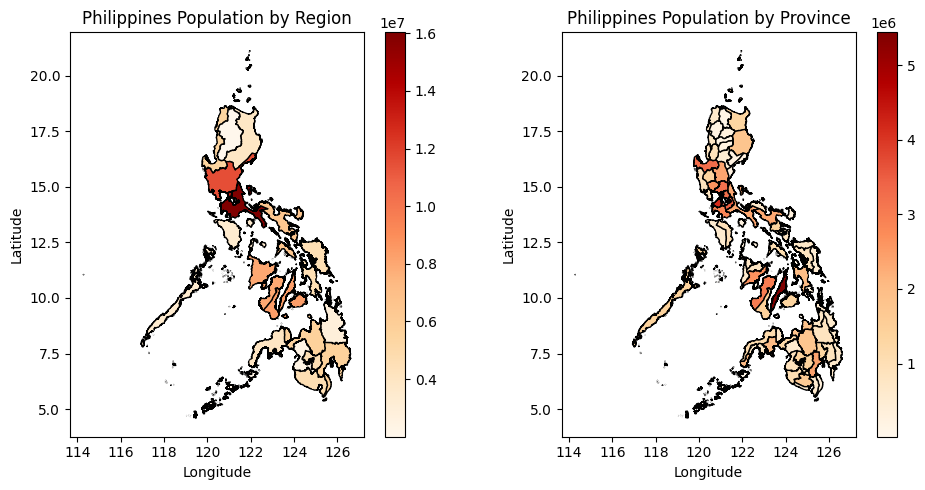

In [78]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Add region plot
region_shape.plot(column='population', ax=axs[0], legend=True,
              cmap='OrRd',  # Choose a colormap for the fill color
              edgecolor='black')  # Optional: to add edges to the shapes
axs[0].set_title('Philippines Population by Region')
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Latitude')

# Add province plot
province_shape.plot(column='population', ax=axs[1], legend=True,
              cmap='OrRd',  # Choose a colormap for the fill color
              edgecolor='black')  # Optional: to add edges to the shapes
axs[1].set_title('Philippines Population by Province')
axs[1].set_xlabel('Longitude')
axs[1].set_ylabel('Latitude')

fig.tight_layout()

Text(94.64438449056722, 0.5, 'Latitude')

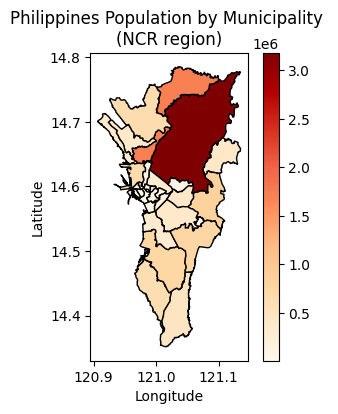

In [79]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
# Add municipality plot
municipality_shape.loc[municipality_shape.region=='NCR'].plot(column='population', ax=ax, legend=True,
              cmap='OrRd',  # Choose a colormap for the fill color
              edgecolor='black')  # Optional: to add edges to the shapes
ax.set_title('Philippines Population by Municipality \n(NCR region)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

#### Poverty Incidence

In [220]:
# Load the excel file with poverty incidence data
poverty_path = 'data/poverty_statistics/PI_2018_2021_SAE_with_PSGC_noHUC.xlsx'
df_poverty = pd.read_excel(poverty_path,sheet_name='2018-2021_NoHUC',skiprows=4)
df_poverty = df_poverty.iloc[:-6]
col_names = ['PSGC','province','municipality','PI_2018','PI_2021','CoV_2018','CoV_2021','CI_lower_2018','CI_upper_2018','CI_lower_2021','CI_upper_2021']
df_poverty.columns = col_names
col_names = ['province','municipality','PI_2021']
df_poverty = df_poverty[col_names]

# Correct province and region cell locations
def get_region(row):
    if ~pd.isna(row['province']) and pd.isna(row['municipality']):
        return row['province']
    else:
        return np.nan
    
def fill_na_region_row(row,col=''):
    if not pd.isna(row['region']):
        return ''
    else:
        return row[col]
    
# Clean up region/province formatting
df_poverty['region'] = df_poverty.apply(get_region,axis=1)
df_poverty['province'] = df_poverty.apply(fill_na_region_row,axis=1,col='province')
col_names = ['region','province','municipality','PI_2021']
df_poverty = df_poverty[col_names]
df_poverty[['region','province']] = df_poverty[['region','province']].fillna(method='ffill')
df_poverty.dropna(inplace=True)

# Change region/province/municipality names for consistency with PPPP data.
# Additional mapping added to earlier region_map and province_map created.
region_map['Region IV-A (CALABARZON)'] = 'IV-A'
region_map['Region IV-B (MIMAROPA)'] = 'MIMAROPA'
region_map['Bangsamoro Autonomous Region in Muslim Mindanao (BARMM)'] = 'BARMM'
region_map['Region XII (SOCCSKSARGEN)'] = 'XII'
df_poverty['region'] = df_poverty['region'].map(region_map)

province_map['1st district'] = 'NCR FIRST DISTRICT'
province_map['Cotabato'] = 'NORTH COTABATO'
province_map['Davao de Oro'] = 'DAVAO DE ORO'
province_map['Maguindanao'] = 'MAGUINDANAO'
province_map['Samar (Western)'] = 'SAMAR (WESTERN SAMAR)'
province_map['Tawi-tawi'] = 'TAWI-TAWI'
df_poverty['province'] = df_poverty['province'].map(province_map)

# Fix municipalities placed in wrong province, surigao del sur wrongly classified as surigao del norte
df_poverty.loc[df_poverty['municipality'].str.lower().str.contains('cagwait'),'province'] = 'SURIGAO DEL SUR'
df_poverty.loc[df_poverty['municipality'].str.lower().str.contains('cantilan'),'province'] = 'SURIGAO DEL SUR'
df_poverty.loc[df_poverty['municipality'].str.lower().str.contains('carrascal'),'province'] = 'SURIGAO DEL SUR'
df_poverty.loc[df_poverty['municipality'].str.lower().str.contains('barobo'),'province'] = 'SURIGAO DEL SUR'
df_poverty.loc[df_poverty['municipality'].str.lower().str.contains('bayabas'),'province'] = 'SURIGAO DEL SUR'
df_poverty.loc[df_poverty['municipality'].str.lower().str.contains('bislig'),'province'] = 'SURIGAO DEL SUR'
df_poverty.loc[(df_poverty['municipality'] == 'Carmen') & (df_poverty['province'].str.lower().str.contains('surigao del norte')),'province'] = 'SURIGAO DEL SUR'

In [221]:
# Create municipality name mapping to standardize to pppp data.
# A lot of intances with 'city of', 'city', and location information in parentheses. removing from both pppp and poverty incidence data
pppp_names = pd.concat(all_municipal_dfs)[['province','municipality']]
poverty_names = df_poverty[['province','municipality']]
pppp_names.drop_duplicates(inplace=True)
poverty_names.drop_duplicates(inplace=True)
pppp_names['clean_mun'] = pppp_names['municipality'].map(lambda x: re.sub(r'\s+','',x.lower()))
pppp_names['clean_pro'] = pppp_names['province'].map(lambda x: re.sub(r'\s+','',x.lower()))
pppp_names['clean_pro_mun'] = pppp_names.apply(lambda row: row['clean_pro']+'_'+row['clean_mun'],axis=1)
pppp_names['clean_pro_mun'] = pppp_names['clean_pro_mun'].map(lambda x: re.sub(r'\([^)]*\)','',x))
pppp_names['clean_pro_mun'] = pppp_names['clean_pro_mun'].map(lambda x: re.sub(r'cityof','',x))
pppp_names['clean_pro_mun'] = pppp_names['clean_pro_mun'].map(lambda x: re.sub(r'city','',x))

poverty_names['clean_mun'] = poverty_names['municipality'].map(lambda x: re.sub(r'\s+','',x.lower()))
poverty_names['clean_pro'] = poverty_names['province'].map(lambda x: re.sub(r'\s+','',x.lower()))
poverty_names['clean_pro_mun'] = poverty_names.apply(lambda row: row['clean_pro']+'_'+row['clean_mun'],axis=1)
poverty_names['clean_pro_mun'] = poverty_names['clean_pro_mun'].map(lambda x: re.sub(r'\([^)]*\)','',x))
poverty_names['clean_pro_mun'] = poverty_names['clean_pro_mun'].map(lambda x: re.sub(r'cityof','',x))
poverty_names['clean_pro_mun'] = poverty_names['clean_pro_mun'].map(lambda x: re.sub(r'city','',x))

pppp_poverty_merge = pppp_names.merge(poverty_names,on='clean_pro_mun',how='outer')

In [222]:
# Manually resolving inconsistent naming
pppp_poverty_merge.iloc[297,:4] = pppp_poverty_merge.iloc[298,:4]
pppp_poverty_merge.iloc[457,:4] = pppp_poverty_merge.iloc[456,:4]
pppp_poverty_merge.iloc[671,:4] = pppp_poverty_merge.iloc[672,:4]
pppp_poverty_merge.iloc[787,:4] = pppp_poverty_merge.iloc[788,:4]
pppp_poverty_merge.iloc[823,:4] = pppp_poverty_merge.iloc[818,:4]
pppp_poverty_merge.iloc[967,:4] = pppp_poverty_merge.iloc[966,:4]
pppp_poverty_merge.iloc[1023,:4] = pppp_poverty_merge.iloc[1024,:4]
pppp_poverty_merge.iloc[1150,:4] = pppp_poverty_merge.iloc[1148,:4]
pppp_poverty_merge.iloc[1151,:4] = pppp_poverty_merge.iloc[1149,:4]
pppp_poverty_merge.iloc[1268,:4] = pppp_poverty_merge.iloc[1267,:4]
pppp_poverty_merge.iloc[1298,:4] = pppp_poverty_merge.iloc[1278,:4]
pppp_poverty_merge.iloc[1409,:4] = pppp_poverty_merge.iloc[1410,:4]
pppp_poverty_merge.iloc[1450,:4] = pppp_poverty_merge.iloc[1451,:4]
pppp_poverty_merge.iloc[1578,:4] = pppp_poverty_merge.iloc[1579,:4]

# No mapping
pppp_poverty_merge.iloc[1228,:4] = pppp_poverty_merge.iloc[1228,5:] # palawan kalayaan in poverty data but not pppp

# Create map
pppp_poverty_merge = pppp_poverty_merge[['municipality_x','clean_pro_mun']]
pppp_poverty_merge.drop_duplicates(inplace=True)
municipal_map = {vals[1]:vals[0] for _,vals in pppp_poverty_merge.iterrows()}

In [223]:
# Apply map
df_poverty['clean_mun'] = df_poverty['municipality'].map(lambda x: re.sub(r'\s+','',x.lower()))
df_poverty['clean_pro'] = df_poverty['province'].map(lambda x: re.sub(r'\s+','',x.lower()))
df_poverty['clean_pro_mun'] = df_poverty.apply(lambda row: row['clean_pro']+'_'+row['clean_mun'],axis=1)
df_poverty['clean_pro_mun'] = df_poverty['clean_pro_mun'].map(lambda x: re.sub(r'\([^)]*\)','',x))
df_poverty['clean_pro_mun'] = df_poverty['clean_pro_mun'].map(lambda x: re.sub(r'cityof','',x))
df_poverty['clean_pro_mun'] = df_poverty['clean_pro_mun'].map(lambda x: re.sub(r'city','',x))

df_poverty['municipality'] = df_poverty['clean_pro_mun'].map(municipal_map)
df_poverty.drop(columns=['clean_mun','clean_pro','clean_pro_mun'],inplace=True)
df_poverty.reset_index(inplace=True,drop=True)

In [225]:
pppp_names = pd.concat(all_municipal_dfs)[['province','municipality']]
poverty_names = df_poverty[['province','municipality']]
pppp_names.drop_duplicates(inplace=True)
poverty_names.drop_duplicates(inplace=True)
pppp_names['clean_mun'] = pppp_names['municipality'].map(lambda x: re.sub(r'\s+','',x.lower()))
pppp_names['clean_pro'] = pppp_names['province'].map(lambda x: re.sub(r'\s+','',x.lower()))
pppp_names['clean_pro_mun'] = pppp_names.apply(lambda row: row['clean_pro']+'_'+row['clean_mun'],axis=1)
pppp_names['clean_pro_mun'] = pppp_names['clean_pro_mun'].map(lambda x: re.sub(r'\([^)]*\)','',x))
pppp_names['clean_pro_mun'] = pppp_names['clean_pro_mun'].map(lambda x: re.sub(r'cityof','',x))
pppp_names['clean_pro_mun'] = pppp_names['clean_pro_mun'].map(lambda x: re.sub(r'city','',x))

poverty_names['clean_mun'] = poverty_names['municipality'].map(lambda x: re.sub(r'\s+','',x.lower()))
poverty_names['clean_pro'] = poverty_names['province'].map(lambda x: re.sub(r'\s+','',x.lower()))
poverty_names['clean_pro_mun'] = poverty_names.apply(lambda row: row['clean_pro']+'_'+row['clean_mun'],axis=1)
poverty_names['clean_pro_mun'] = poverty_names['clean_pro_mun'].map(lambda x: re.sub(r'\([^)]*\)','',x))
poverty_names['clean_pro_mun'] = poverty_names['clean_pro_mun'].map(lambda x: re.sub(r'cityof','',x))
poverty_names['clean_pro_mun'] = poverty_names['clean_pro_mun'].map(lambda x: re.sub(r'city','',x))

pppp_poverty_merge = pppp_names.merge(poverty_names,on='clean_pro_mun',how='outer')

1219    palawan_kalayaan
Name: clean_pro_mun, dtype: object

In [175]:
# Oldies

# pppp_poverty_merge.loc[pd.isna(pppp_poverty_merge.iloc[:,:4]).any(axis=1)].iloc[:,4]

# display(pppp_poverty_merge.loc[pppp_poverty_merge['clean_pro_mun'].str.contains('calasiao')])

# checks = ['delfonso',
#           'cordoba',
#           'miag',
#           'tubad',
#           'gumander',
#           'ozamiz',
#           'ozamis',
#           'tondo',
#           'genmamer',
#           'gentinio',
#           'kalayaan',
#           'balungo',
#           'miguel',
#           'santon',
#           'santon',
#           'barobo',
#           'bayabas',
#           'bislig',
#           'cagwait',
#           'cantilan',
#           'carmen',
#           'carrascal',
#           'candelabra']
# for check in checks:
#     clear_output(wait=True)  # Clears the output from the previous iteration
#     print(check)
#     display(pppp_poverty_merge.loc[pppp_poverty_merge['clean_pro_mun'].str.contains(check)])
#     input('')

In [226]:
# Add to municipality_shape
gdf_municipality = municipality_shape.merge(df_poverty,on=['region','province','municipality'],how='left')
gdf_municipality.dropna(inplace=True)

### Analysis

#### Temporal Trends

We use `all_region_dfs` and `all_province_dfs` produced earlier for a quick view on variation in PPPP activity over the years.

In [31]:
# Combine dataframes from different years
df_region = pd.concat(all_region_dfs,axis=0)
df_region['YearQuarter'] = pd.to_datetime(df_region['year'].astype(str) + 'Q' + df_region['quarter'].astype(str)) # Create datetime column
df_province = pd.concat(all_province_dfs,axis=0)
df_province['YearQuarter'] = pd.to_datetime(df_province['year'].astype(str) + 'Q' + df_province['quarter'].astype(str)) # Create datetime column

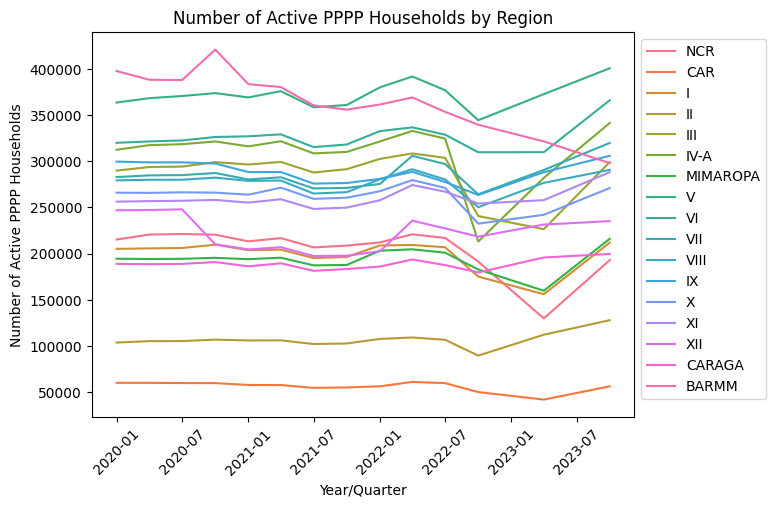

In [32]:
# Plot PPPP households by region
fig, ax = plt.subplots(1,1,figsize=(7,5))
sns.lineplot(df_region.loc[df_region.region!='Grand'],
             x='YearQuarter',y='grandtotal',hue='region',ax=ax)
ax.set_title('Number of Active PPPP Households by Region')
ax.set_ylabel('Number of Active PPPP Households')
ax.set_xlabel('Year/Quarter')
for label in ax.get_xticklabels():
    label.set_rotation(45)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

In [33]:
df_region.region.unique()

array(['NCR', 'CAR', 'I', 'II', 'III', 'IV-A', 'MIMAROPA', 'V', 'VI',
       'VII', 'VIII', 'IX', 'X', 'XI', 'XII', 'CARAGA', 'BARMM', 'Grand'],
      dtype=object)

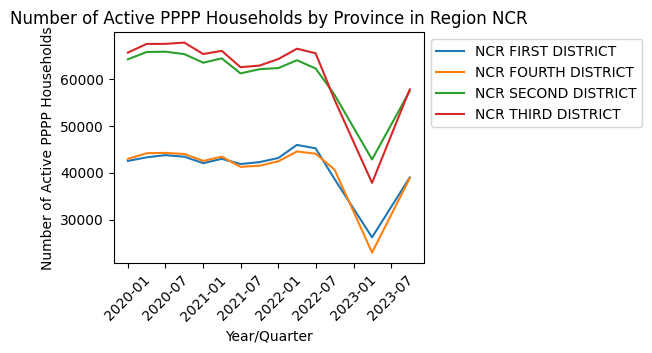

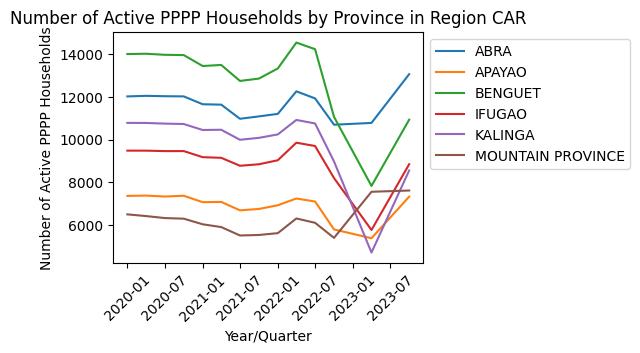

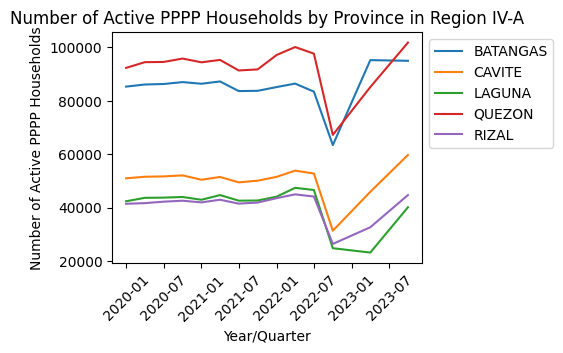

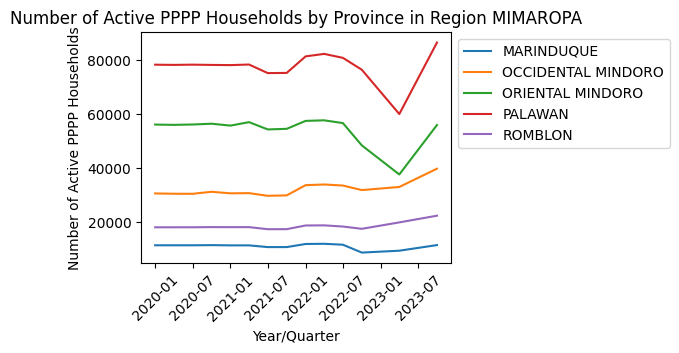

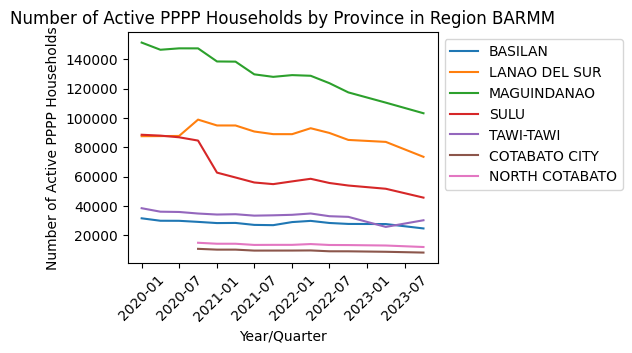

In [34]:
# Plot PPPP households by province for selected regions
for region in ['NCR', 'CAR', 'IV-A', 'MIMAROPA', 'BARMM']:
    fig, ax = plt.subplots(1,1,figsize=(4,3))
    sns.lineplot(df_province.loc[df_province.region==region],
                x='YearQuarter',y='grandtotal',hue='province',ax=ax)
    ax.set_title(f'Number of Active PPPP Households by Province in Region {region}')
    ax.set_ylabel('Number of Active PPPP Households')
    ax.set_xlabel('Year/Quarter')
    for label in ax.get_xticklabels():
        label.set_rotation(45)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

As shown, most regions experience a fall in PPPP participation in 2022, and a subsequent increase again in 2023. In 2022, a substantial number of households were removed from the program due to the results of Listahanan 3, a poverty assessment that identified families that were no longer classified as poor. However, there was dissatisfaction with this assessment as it was conducted before the onset of the pandemic, which worsened vulnerabilities for many families. Consequently, in 2023, the Department of Social Welfare and Development (DSWD) re-evaluated many of these households using the Social Welfare and Development Indicator (SWDI) tool, leading to the [reinstatement of over 700,000 households](https://www.pna.gov.ph/articles/1231289).

#### Geographical Coverage

For a study of the geographical coverage of the PPPP program, we use the `gdf_municipality` geo-dataframe and the `all_municipal_dfs` dataframe. Here, we gauge the amount of PPPP activity in each different locations relative to the number of households living under the poverty line. We use the population information from the 2020 HRSL data and the 2021 poverty incidence data here, assuming the relative numbers do not change significantly over the years of our analysis.

In [92]:
# Standardize column names
col_map = {'1':'set1', '10':'set10', '11':'set11', '12':'set12',
           '12m':'set12m', '2':'set2',
           '3':'set3', '4':'set4', '5':'set5', '6':'set6', '7':'set7',
           '7m':'set7m', '8':'set8', '8e':'set8e', '9':'set9',
           'ipsgida':'ipsingida', 'itenerantips':'itinerantips'}
for i,df in enumerate(all_municipal_dfs):
    col_names = df.columns
    col_names = [col_map[col] if col in col_map.keys() else col for col in col_names]
    all_municipal_dfs[i].columns = col_names
# Combine dataframes
df_municipality = pd.concat(all_municipal_dfs,axis=0)
df_municipality['YearQuarter'] = pd.to_datetime(df_municipality['year'].astype(str) + 'Q' + df_municipality['quarter'].astype(str)) # Create datetime column

In [106]:
for df in all_municipal_dfs:
    print(df['year'].unique()[0], df['quarter'].unique()[0])
    display(df.loc[df.province=='NORTH COTABATO',['region','province','municipality']].value_counts())
    print('\n\n')

2020 1


region  province        municipality               
XII     NORTH COTABATO  ALAMADA                        1
                        ALEOSAN                        1
                        PRESIDENT  ROXAS               1
                        PIKIT                          1
                        PIGKAWAYAN                     1
                        MIDSAYAP                       1
                        MATALAM                        1
                        MAKILALA                       1
                        MAGPET                         1
                        M'LANG                         1
                        LIBUNGAN                       1
                        KABACAN                        1
                        CITY OF KIDAPAWAN (Capital)    1
                        CARMEN                         1
                        BANISILAN                      1
                        ARAKAN                         1
                        ANTIPAS     




2020 2


region  province        municipality               
XII     NORTH COTABATO  ALAMADA                        1
                        ALEOSAN                        1
                        PRESIDENT  ROXAS               1
                        PIKIT                          1
                        PIGKAWAYAN                     1
                        MIDSAYAP                       1
                        MATALAM                        1
                        MAKILALA                       1
                        MAGPET                         1
                        M'LANG                         1
                        LIBUNGAN                       1
                        KABACAN                        1
                        CITY OF KIDAPAWAN (Capital)    1
                        CARMEN                         1
                        BANISILAN                      1
                        ARAKAN                         1
                        ANTIPAS     




2020 3


region  province        municipality               
XII     NORTH COTABATO  ALAMADA                        1
                        ALEOSAN                        1
                        PRESIDENT  ROXAS               1
                        PIKIT                          1
                        PIGKAWAYAN                     1
                        MIDSAYAP                       1
                        MATALAM                        1
                        MAKILALA                       1
                        MAGPET                         1
                        M'LANG                         1
                        LIBUNGAN                       1
                        KABACAN                        1
                        CITY OF KIDAPAWAN (Capital)    1
                        CARMEN                         1
                        BANISILAN                      1
                        ARAKAN                         1
                        ANTIPAS     




2020 4


region  province        municipality               
BARMM   NORTH COTABATO  ALEOSAN                        1
                        CARMEN                         1
XII     NORTH COTABATO  PRESIDENT ROXAS                1
                        PIKIT                          1
                        PIGKAWAYAN                     1
                        MIDSAYAP                       1
                        MATALAM                        1
                        MAKILALA                       1
                        MAGPET                         1
                        M'LANG                         1
                        LIBUNGAN                       1
                        KABACAN                        1
                        CITY OF KIDAPAWAN (CAPITAL)    1
                        CARMEN                         1
                        BANISILAN                      1
                        ARAKAN                         1
                        ANTIPAS     




2021 1


region  province        municipality               
BARMM   NORTH COTABATO  PIKIT                          2
                        ALEOSAN                        1
XII     NORTH COTABATO  KABACAN                        1
                        PRESIDENT ROXAS                1
                        PIKIT                          1
                        PIGKAWAYAN                     1
                        MIDSAYAP                       1
                        MATALAM                        1
                        MAKILALA                       1
                        MAGPET                         1
                        M'LANG                         1
                        LIBUNGAN                       1
                        CITY OF KIDAPAWAN (Capital)    1
BARMM   NORTH COTABATO  CARMEN                         1
XII     NORTH COTABATO  CARMEN                         1
                        BANISILAN                      1
                        ARAKAN      




2021 2


region  province        municipality               
BARMM   NORTH COTABATO  ALEOSAN                        1
                        CARMEN                         1
XII     NORTH COTABATO  PRESIDENT ROXAS                1
                        PIKIT                          1
                        PIGKAWAYAN                     1
                        MIDSAYAP                       1
                        MATALAM                        1
                        MAKILALA                       1
                        MAGPET                         1
                        M'LANG                         1
                        LIBUNGAN                       1
                        KABACAN                        1
                        CITY OF KIDAPAWAN (Capital)    1
                        CARMEN                         1
                        BANISILAN                      1
                        ARAKAN                         1
                        ANTIPAS     




2021 3


region  province        municipality                
BARMM   NORTH COTABATO  ALEOSAN                         1
                        CARMEN                          1
XII     NORTH COTABATO  PRESIDENT ROXAS                 1
                        PIKIT                           1
                        PIGKAWAYAN                      1
                        MIDSAYAP                        1
                        MATALAM                         1
                        MAKILALA                        1
                        MAGPET                          1
                        M'LANG                          1
                        LIBUNGAN                        1
                        KABACAN                         1
                        CITY OF KIDAPAWAN  (Capital)    1
                        CARMEN                          1
                        BANISILAN                       1
                        ARAKAN                          1
                   




2021 4


region  province        municipality                
BARMM   NORTH COTABATO  ALEOSAN                         1
                        CARMEN                          1
XII     NORTH COTABATO  PRESIDENT ROXAS                 1
                        PIKIT                           1
                        PIGKAWAYAN                      1
                        MIDSAYAP                        1
                        MATALAM                         1
                        MAKILALA                        1
                        MAGPET                          1
                        M'LANG                          1
                        LIBUNGAN                        1
                        KABACAN                         1
                        CITY OF KIDAPAWAN  (Capital)    1
                        CARMEN                          1
                        BANISILAN                       1
                        ARAKAN                          1
                   




2022 1


region  province        municipality                
BARMM   NORTH COTABATO  ALEOSAN                         1
                        CARMEN                          1
XII     NORTH COTABATO  PRESIDENT ROXAS                 1
                        PIKIT                           1
                        PIGKAWAYAN                      1
                        MIDSAYAP                        1
                        MATALAM                         1
                        MAKILALA                        1
                        MAGPET                          1
                        M'LANG                          1
                        LIBUNGAN                        1
                        KABACAN                         1
                        CITY OF KIDAPAWAN  (Capital)    1
                        CARMEN                          1
                        BANISILAN                       1
                        ARAKAN                          1
                   




2022 2


region  province        municipality               
BARMM   NORTH COTABATO  ALEOSAN                        1
                        CARMEN                         1
XII     NORTH COTABATO  PRESIDENT  ROXAS               1
                        PIKIT                          1
                        PIGKAWAYAN                     1
                        MIDSAYAP                       1
                        MATALAM                        1
                        MAKILALA                       1
                        MAGPET                         1
                        M'LANG                         1
                        LIBUNGAN                       1
                        KABACAN                        1
                        CITY OF KIDAPAWAN (Capital)    1
                        CARMEN                         1
                        BANISILAN                      1
                        ARAKAN                         1
                        ANTIPAS     




2022 3


region  province        municipality               
BARMM   NORTH COTABATO  ALEOSAN                        1
                        CARMEN                         1
XII     NORTH COTABATO  PRESIDENT  ROXAS               1
                        PIKIT                          1
                        PIGKAWAYA  N                   1
                        MIDSAYAP                       1
                        MATALAM                        1
                        MAKILALA                       1
                        MAGPET                         1
                        M'LANG                         1
                        LIBUNGAN                       1
                        KABACAN                        1
                        CITY OF KIDAPAWAN (Capital)    1
                        CARMEN                         1
                        BANISILAN                      1
                        ARAKAN                         1
                        ANTIPAS     




2022 4


region  province        municipality               
BARMM   NORTH COTABATO  ALEOSAN                        1
                        CARMEN                         1
XII     NORTH COTABATO  PRESIDENT ROXAS                1
                        PIKIT                          1
                        PIGKAWAYAN                     1
                        MIDSAYAP                       1
                        MATALAM                        1
                        MAKILALA                       1
                        MAGPET                         1
                        M'LANG                         1
                        LIBUNGAN                       1
                        KABACAN                        1
                        CITY OF KIDAPAWAN (Capital)    1
                        CARMEN                         1
                        BANISILAN                      1
                        ARAKAN                         1
                        ANTIPAS     




2023 2


region  province        municipality               
BARMM   NORTH COTABATO  ALEOSAN                        1
                        CARMEN                         1
XII     NORTH COTABATO  PRESIDENT ROXAS                1
                        PIKIT                          1
                        PIGKAWAYAN                     1
                        MIDSAYAP                       1
                        MATALAM                        1
                        MAKILALA                       1
                        MAGPET                         1
                        M'LANG                         1
                        LIBUNGAN                       1
                        KABACAN                        1
                        CITY OF KIDAPAWAN (Capital)    1
                        CARMEN                         1
                        BANISILAN                      1
                        ARAKAN                         1
                        ANTIPAS     




2023 4


region  province        municipality                
BARMM   NORTH COTABATO  ALEOSAN                         1
                        CARMEN                          1
XII     NORTH COTABATO  PRESIDENT ROXAS                 1
                        PIKIT                           1
                        PIGKAWAYAN                      1
                        MIDSAYAP                        1
                        MATALAM                         1
                        MAKILALA                        1
                        MAGPET                          1
                        M'LANG                          1
                        LIBUNGAN                        1
                        KABACAN                         1
                        CITY OF KIDAPAWAN  (Capital)    1
                        CARMEN                          1
                        BANISILAN                       1
                        ARAKAN                          1
                   

In [ ]:
# Calculate poor household proportion using 2021 poverty incidence estimate.
gdf_municipality['poor_household_indicator'] = gdf_municipality['population']*gdf_municipality['PI_2021']

# Place North Cotabato in 

In [98]:
gdf_municipality.loc[gdf_municipality.province=='NORTH COTABATO']

,region,province,municipality,geometry,population,PI_2021,poor_household_indicator
1224,XII,NORTH COTABATO,ALAMADA,"POLYGON ((124.59037 7.60932, 124.64598 7.60358...",69255.505160,47.983127,3.323096e+06
1225,XII,NORTH COTABATO,CARMEN,"POLYGON ((124.87546 7.43608, 124.8756 7.43591,...",115117.464792,40.547772,4.667757e+06
1226,XII,NORTH COTABATO,KABACAN,"POLYGON ((124.90957 7.21587, 124.90715 7.20207...",98809.015313,29.186395,2.883879e+06
1227,XII,NORTH COTABATO,CITY OF KIDAPAWAN (Capital),"POLYGON ((124.98711 7.10995, 124.98776 7.10988...",174400.634843,20.831657,3.633054e+06
1228,XII,NORTH COTABATO,LIBUNGAN,"POLYGON ((124.64407 7.33648, 124.64352 7.33455...",52754.327993,30.928170,1.631595e+06
1229,XII,NORTH COTABATO,MAGPET,"POLYGON ((125.16002 7.27912, 125.16039 7.27908...",45856.670149,33.532710,1.537698e+06
1230,XII,NORTH COTABATO,MAKILALA,"POLYGON ((125.18809 7.00282, 125.19014 7.00242...",97494.517226,28.242553,2.753494e+06
1231,XII,NORTH COTABATO,MATALAM,"POLYGON ((125.03491 7.32028, 125.03517 7.31956...",106370.308721,34.860321,3.708103e+06
1232,XII,NORTH COTABATO,MIDSAYAP,"MULTIPOLYGON (((124.56094 7.12141, 124.56112 7...",139130.267573,27.170876,3.780291e+06
1233,XII,NORTH COTABATO,M'LANG,"POLYGON ((124.9393 7.03014, 124.94418 7.02237,...",94957.502105,28.294940,2.686817e+06


In [ ]:
# Add geodata to PPPP dataframe
df_municipality = df_municipality.merge(gdf_municipality,on=['region','province','municipality'],how='left')
df_municipality = df_municipality[['region', 'province', 'municipality',                                     # Drop unneeded columns
                                   'grandtotal', 'YearQuarter', 'geometry', 'population',
                                   'PI_2021', 'poor_household_indicator']]

In [64]:
df_municipality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23037 entries, 0 to 23036
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   region                    23037 non-null  object        
 1   province                  23037 non-null  object        
 2   municipality              23037 non-null  object        
 3   grandtotal                23037 non-null  int64         
 4   YearQuarter               23037 non-null  datetime64[ns]
 5   geometry                  19657 non-null  geometry      
 6   population                19657 non-null  float64       
 7   PI_2021                   19657 non-null  float64       
 8   poor_household_indicator  19657 non-null  float64       
dtypes: datetime64[ns](1), float64(3), geometry(1), int64(1), object(3)
memory usage: 1.6+ MB


In [69]:
df_municipality.loc[pd.isna(df_municipality).any(axis=1)]
# .YearQuarter.min(), df_municipality.loc[pd.isna(df_municipality).any(axis=1)].YearQuarter.max()


,region,province,municipality,grandtotal,YearQuarter,geometry,population,PI_2021,poor_household_indicator
12,NCR,NCR FIRST DISTRICT,SANTA CRUZ,1843,2020-01-01,None,NaN,NaN,NaN
14,NCR,NCR FOURTH DISTRICT,CITY OF LASPIÑAS,6508,2020-01-01,None,NaN,NaN,NaN
15,NCR,NCR FOURTH DISTRICT,CITY OF MAKATI,4106,2020-01-01,None,NaN,NaN,NaN
16,NCR,NCR FOURTH DISTRICT,CITY OF MUNTINLUPA,9146,2020-01-01,None,NaN,NaN,NaN
17,NCR,NCR FOURTH DISTRICT,CITY OF PARAÑAQUE,7514,2020-01-01,None,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
22926,BARMM,NORTH COTABATO,KABACAN,941,2023-10-01,None,NaN,NaN,NaN
22927,BARMM,NORTH COTABATO,MIDSAYAP,2403,2023-10-01,None,NaN,NaN,NaN
22928,BARMM,NORTH COTABATO,PIGKAWAYAN,1114,2023-10-01,None,NaN,NaN,NaN
22929,BARMM,NORTH COTABATO,PIKIT,5918,2023-10-01,None,NaN,NaN,NaN


In [ ]:
df_municipality.loc[pd.isna(df_municipality).any(axis=1)]

In [85]:
# all_municipal_dfs[-1][['region','province','municipality']].groupby(['region','province']).count()
all_municipal_dfs[-1].loc[all_municipal_dfs[-1].province=='NORTH COTABATO'][['region','province','municipality']]

,region,province,municipality
1,XII,NORTH COTABATO,ALAMADA
3,XII,NORTH COTABATO,ALEOSAN
4,XII,NORTH COTABATO,ANTIPAS
5,XII,NORTH COTABATO,ARAKAN
6,XII,NORTH COTABATO,BANISILAN
7,XII,NORTH COTABATO,CARMEN
8,XII,NORTH COTABATO,CITY OF KIDAPAWAN (Capital)
11,XII,NORTH COTABATO,KABACAN
12,XII,NORTH COTABATO,LIBUNGAN
13,XII,NORTH COTABATO,MAGPET


In [86]:
municipality_shape.loc[municipality_shape.province.str.lower().str.startswith('north c')]
# municipality_shape.loc[municipality_shape.region.str.lower()=='xii'].province.unique()

,region,province,municipality,geometry,population
1224,XII,NORTH COTABATO,ALAMADA,"POLYGON ((124.59037 7.60932, 124.64598 7.60358...",69255.505160
1225,XII,NORTH COTABATO,CARMEN,"POLYGON ((124.87546 7.43608, 124.8756 7.43591,...",115117.464792
1226,XII,NORTH COTABATO,KABACAN,"POLYGON ((124.90957 7.21587, 124.90715 7.20207...",98809.015313
1227,XII,NORTH COTABATO,CITY OF KIDAPAWAN (Capital),"POLYGON ((124.98711 7.10995, 124.98776 7.10988...",174400.634843
1228,XII,NORTH COTABATO,LIBUNGAN,"POLYGON ((124.64407 7.33648, 124.64352 7.33455...",52754.327993
1229,XII,NORTH COTABATO,MAGPET,"POLYGON ((125.16002 7.27912, 125.16039 7.27908...",45856.670149
1230,XII,NORTH COTABATO,MAKILALA,"POLYGON ((125.18809 7.00282, 125.19014 7.00242...",97494.517226
1231,XII,NORTH COTABATO,MATALAM,"POLYGON ((125.03491 7.32028, 125.03517 7.31956...",106370.308721
1232,XII,NORTH COTABATO,MIDSAYAP,"MULTIPOLYGON (((124.56094 7.12141, 124.56112 7...",139130.267573
1233,XII,NORTH COTABATO,M'LANG,"POLYGON ((124.9393 7.03014, 124.94418 7.02237,...",94957.502105
